In [1]:
import os
import sys
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
from math import pi
import h5py
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import orbithunter as orb

# Table of contents
<a id='toc'></a>

## [1. Overview: Why orbithunter?](#intro)
    Why and when you should use orbithunter. 

# [2. Examples with the Kuramoto-Sivashinsky Equation](#KSE)
    Demonstrations of utilities using a specific equation

## [2.1 Initialization](#init)
    How to initialize an Orbit with no prior information

## [2.2 Orbit Hunting via Machine Learning (Numerical Optimization)](#hunt)
    How to apply custom and SciPy's numerical methods to search for solutions

## [2.3 Clipping: Extracting Subdomains](#clip)
    Extracting spatiotemporal subdomains from larger Orbits

## [2.4 Reading and Writing Orbit Data](#io)
    Detecting orbits which manifest within others; the theoretical motivation behind this project.

## [2.5 Gluing: Building Blocks of Turbulence](#glue)
    Combining spatiotemporal configurations of orbits; using orbits as literal building blocks.

## [2.6 Shadowing: Detecting Orbits in Other Orbits](#shadow)
    Detecting orbits which manifest within others; the theoretical motivation behind this project.
    
# [Extras](#extras)

## [E.1 Gudhi](#gudhi)
    How to use orbits with Gudhi, persistent homology tools (if extra package requirements are satisfied)

## [E.2 Keras](#keras)
    How to use orbits with Keras (if extra package requirements are satisfied)

    
## [E.3 Technical notes from the author](#footnotes)
    Comments on various portions of the notebooksfor a more technical audience


# 1. Overview: Why orbithunter?

<a id='intro'></a>

## A terse non-technical explanation

Certain equations are hard to solve for two reasons: 1. the number of variables, 2. the relations between those variables.
In fact, for a certain class of equations, nonlinear equations, there are seldom any exact solutions; they must
be solved using computers. In certain settings this is hard, even for computers to manage, and so new tools
must be developed. Orbithunter offers itself as one of these tools. 


## How to do it

By formulating turbulence as a space-time, variational formulation we can still find the same periodic orbits
in the dynamical systems approach; however, spacetime affords us with new capabilities not seen elsewhere. such as:

- The ability to find exponentially unstable solutions starting with modulated random noise
- The ability to include spatiotemporal domain sizes to vary as free parameters; essentially allowing the equations to     determine the important scales (or "learn" in machine learning parlance). 
- The ability to cut and paste (quite literally) periodic orbits together in a manner that is both supported by theory
  and also previously attempted in fluid dynamics research. 

# 2. Examples using the Spatiotemporal Kuramoto-Sivashinsky Equation
**[Return to table of contents](#toc)**
<a id='KSE'></a>

## 2.1 Orbit Initialization

**[Return to table of contents](#toc)**
<a id='init'></a>

Initial conditions can be easily initialized with random modulated noise by 

    1. Initialize an OrbitKS instance
    2. Use the populate method to fill its parameters and state

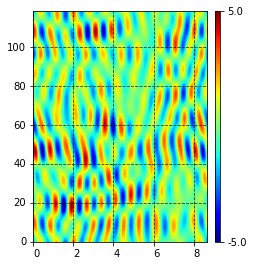

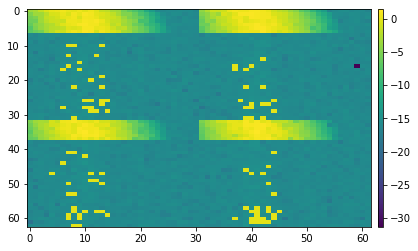

In [2]:
np.random.seed(0)
orbit = orb.OrbitKS().populate(seed=0, attr='all', discretization=(64, 64),
                               spatial_modulation='gaussian',
                              temporal_modulation='truncate').rescale(5)
orbit.plot(padding=True)
orbit.mode_plot()

The plots correspond to the physical field and the spectrum of spatiotemporal Fourier modes populated by modulation
via a specific choice out of a collection various strategies that are best left explained elsewhere. 

In [3]:
res = orbit.cost()
print(f"The cost function before any numerical optimization is equal to {res:.5f}")

The cost function before any numerical optimization is equal to 8807.93720


## 2.2 Finding periodic orbits via machine learning (nonlinear optimization).

**[Return to table of contents](#toc)**
<a id='hunt'></a>

Orbithunter offers high-level access to the SciPy ```optimize```, ```minimize``` and ```sparse.linalg``` solvers and
more. This allows the user to not have to figure out the specific type of input, parse the output, or learn the more involved
entities within SciPy. A soon as the user defines the methods
which can compute their equations, and compute the matrix-vector products with its Jacobian and its adjoint (transpose or complex conjugate, they immediately have access to over 40 numerical algorithms!

While numerical optimization is always available, finding a solution which constitutes an actual periodic orbit within
a prescribed tolerance is never guaranteed; this is the nature of the beast when it comes to nonlinear optimization, local minima can stop any optimization trial in its tracks. Let's apply some machine learning methods (numerical optimization of a cost function) to try to find a solution!

In [4]:
# Apply the hybrid method that was used as the primary method, historically. 
t0 = time.time_ns()/10**9
hunting_result = orb.hunt(orbit, methods=('adj', 'lsqr'), verbose=False,
                          preconditioning=[True, False], maxiter=[100000, 500],
                          scipy_kwargs={"atol":1e-4,"btol":1e-4})
t1 = time.time_ns()/10**9
print(f"The numerical optimization took {t1-t0} seconds to complete {hunting_result.maxiter} iterations for each method")

0
0
0
0.037820992720061355
0.7040595577919021
0
0
0
0
-0.010633070852309802
-0.2180683289464955
0
0
0
0
0.01123272634546594
0.24994761819700023
0
0
0
0
-0.008702309214156408
-0.20222484188994957
0
0
0
0
0.007055631092396606
0.16842384812027816
0
0
0
0
-0.005984302772531728
-0.14060806284794838
0
0
0
0
0.004648050122850718
0.0997936439956564
0
0
0
0
-0.004310852031293506
-0.09083838076577827
0
0
0
0
0.004261518607527491
0.07923413972834564
0
0
0
0
-0.0035461491177823812
-0.05621787084959824
0
0
0
0
0.003473933127628679
0.053786271085925506
0
0
0
0
-0.0027975878824712244
-0.041753886623819916
0
0
0
0
0.003059440649257676
0.0522145026213582
0
0
0
0
-0.0030040996219960364
-0.06026984541818874
0
0
0
0
0.002798123477754112
0.05821956157277949
0
0
0
0
-0.0022948989369907043
-0.04295072961681754
0
0
0
0
0.0027840276206460833
0.050555548442423305
0
0
0
0
-0.0028868496293444693
-0.04496023401834347
0
0
0
0
0.003032557401857634
0.04887585714794948
0
0
0
0
-0.002604256668904562
-0.0494323147166468

0
0
0
-0.00674444433205221
-0.1929286013094682
0
0
0
0
0.005188572977596268
0.14968684710938718
0
0
0
0
-0.00476117795731713
-0.1370954504962641
0
0
0
0
0.004361813047124082
0.11838569771408988
0
0
0
0
-0.0046426602737900495
-0.12058557988317911
0
0
0
0
0.005243880601399069
0.12919140189758072
0
0
0
0
-0.0054025498598750405
-0.12813445793666012
0
0
0
0
0.005585772352033974
0.12912068582028072
0
0
0
0
-0.00641601637251815
-0.14508236960078813
0
0
0
0
0.0048005367748422244
0.10969152342862051
0
0
0
0
-0.004422124808022168
-0.10627030224718594
0
0
0
0
0.004152962465441166
0.10946309760253518
0
0
0
0
-0.005684808002899045
-0.1573319147772767
0
0
0
0
0.0057775569262732305
0.1613869072999875
0
0
0
0
-0.005024108506136727
-0.13767821903952296
0
0
0
0
0.004832189044813504
0.1340873367804911
0
0
0
0
-0.005036613996080465
-0.1385568917002506
0
0
0
0
0.0050329742438720215
0.13637911918286766
0
0
0
0
-0.005318244725521415
-0.14527455762211733
0
0
0
0
0.005256423284549196
0.14380905393235976
0
0
0


0
0
0
0.0035224406677250783
0.04512497632341673
0
0
0
0
-0.004516143459075902
-0.06594536921493742
0
0
0
0
0.003669373605239331
0.06678377033719396
0
0
0
0
-0.004078498064112977
-0.08346425649393474
0
0
0
0
0.004131040020841602
0.0865535268184939
0
0
0
0
-0.003951666882134204
-0.08407419484687297
0
0
0
0
0.003869229960661851
0.0751341381170531
0
0
0
0
-0.0041097678338503614
-0.07225616792085997
0
0
0
0
0.00377058389711902
0.056500339720564424
0
0
0
0
-0.003737349484949091
-0.06071773637693725
0
0
0
0
0.0039926663547400635
0.07328590840220013
0
0
0
0
-0.004420431115294761
-0.09328872127639222
0
0
0
0
0.005378580206257257
0.1279135366691502
0
0
0
0
-0.00358103618950342
-0.08678591763905968
0
0
0
0
0.0029615301313858132
0.0681754496775404
0
0
0
0
-0.003948090610691248
-0.08463524630892238
0
0
0
0
0.004764544421532496
0.08915998552824472
0
0
0
0
-0.005920836612008368
-0.10181145978006483
0
0
0
0
0.005795196119313979
0.09564759636314206
0
0
0
0
-0.004970618395060343
-0.08057856850695568
0
0

0.0058398623448191415
0.15398016776135617
0
0
0
0
-0.0065873475223746595
-0.17661476037533658
0
0
0
0
0.004482714838787125
0.11986047297194162
0
0
0
0
-0.003617248303697696
-0.09584660827902146
0
0
0
0
0.00422713325419405
0.10773677126158238
0
0
0
0
-0.004737413620934621
-0.1194251283281026
0
0
0
0
0.005815263872664208
0.14683757865598504
0
0
0
0
-0.004924139531113893
-0.12627295621517484
0
0
0
0
0.005781895098172395
0.1440636648399727
0
0
0
0
-0.006632849308088546
-0.16730698568406038
0
0
0
0
0.005386700511116757
0.1385490923569218
0
0
0
0
-0.005675991979749978
-0.14895478524056877
0
0
0
0
0.005191193008808938
0.13568098524074654
0
0
0
0
-0.005972264561386963
-0.15636621946847154
0
0
0
0
0.0047922142819611865
0.12377333718774407
0
0
0
0
-0.0043360880645928745
-0.10801102568736674
0
0
0
0
0.004476510286455955
0.11048463259914862
0
0
0
0
-0.0067311027658616945
-0.16066451960728195
0
0
0
0
0.00663534283983663
0.16032404659946586
0
0
0
0
-0.00650434067323347
-0.15845424980685668
0
0
0
0
0

-0.004708485862073713
-0.08476532171268299
0
0
0
0
0.0045159645043959095
0.07841955421891346
0
0
0
0
-0.003388636043204937
-0.05972790048286531
0
0
0
0
0.0033608764916451647
0.0597859649158226
0
0
0
0
-0.0041709073446034505
-0.07460933203696907
0
0
0
0
0.00490784007785469
0.08423668311681841
0
0
0
0
-0.004475816215639571
-0.07465939236975744
0
0
0
0
0.005101789500502428
0.07998079559956066
0
0
0
0
-0.00442398411794656
-0.06822291943677779
0
0
0
0
0.0048788279877176035
0.07163112159767722
0
0
0
0
-0.004291769308005774
-0.06021640857690172
0
0
0
0
0.004046246783942511
0.05162101804452482
0
0
0
0
-0.004208160837111425
-0.05252310421458843
0
0
0
0
0.00523516721931659
0.06609383516868965
0
0
0
0
-0.004982713227466209
-0.06586398793638783
0
0
0
0
0.007428023998000537
0.10286880139791425
0
0
0
0
-0.0056458841658731775
-0.08308965952314948
0
0
0
0
0.006729115559121041
0.10045825654962413
0
0
0
0
-0.005846812546726357
-0.0863768713604113
0
0
0
0
0.005794662570500776
0.0833369748508199
0
0
0
0
-

-0.0033448936720803274
-0.13584773035171357
0
0
0
0
0.0030325734299710906
0.12119840849009722
0
0
0
0
-0.004352970005945714
-0.17724827241654018
0
0
0
0
0.003649621331442116
0.14674568260566723
0
0
0
0
-0.0036324085851713044
-0.1448598036136355
0
0
0
0
0.0029885103230374768
0.11824351272128496
0
0
0
0
-0.0029472508915092555
-0.11681587046826902
0
0
0
0
0.003040116229807042
0.12169836020465793
0
0
0
0
-0.003712826843297709
-0.1481386277554508
0
0
0
0
0.003752131004166592
0.14717934017514667
0
0
0
0
-0.00408888625185123
-0.15708845523430337
0
0
0
0
0.0033314949812949107
0.11848353157481424
0
0
0
0
-0.003249454225827114
-0.11235480906770184
0
0
0
0
0.0032055532770381384
0.10951422124692516
0
0
0
0
-0.0028360428711041797
-0.09611393813848611
0
0
0
0
0.0031194131609936704
0.11033027933572437
0
0
0
0
-0.0036825636351360555
-0.13232942786972926
0
0
0
0
0.0037367839530457847
0.13580417263072886
0
0
0
0
-0.004568214372682038
-0.16762377058092862
0
0
0
0
0.0038843271220286133
0.14515493759078754

0
0
0
0.0037440981473193867
0.014730635737725782
0
0
0
0
-0.004589879819022387
-0.021936528061602338
0
0
0
0
0.004472649764077867
0.02183172033219326
0
0
0
0
-0.004812092544223405
-0.024314735850506287
0
0
0
0
0.00381872368573507
0.02392653909581309
0
0
0
0
-0.003372870886155331
-0.02341225479788163
0
0
0
0
0.0046234434699986724
0.03312047123175825
0
0
0
0
-0.005585713438815294
-0.037582616770242945
0
0
0
0
0.005148163066027197
0.030445311409658518
0
0
0
0
-0.003835328389961132
-0.01801834922766887
0
0
0
0
0.0033665323032430784
0.011978605746602568
0
0
0
0
-0.004878448396033557
-0.015909914081614605
0
0
0
0
0.006499118273431961
0.024266004357738607
0
0
0
0
-0.005044626756991178
-0.022472250492943824
0
0
0
0
0.004915452426094243
0.021445810696678374
0
0
0
0
-0.004367838555614118
-0.019456791927760377
0
0
0
0
0.004239541628012135
0.017515441714565982
0
0
0
0
-0.0042592696669811045
-0.013011512376628663
0
0
0
0
0.004344352251577752
0.007773369936915052
0
0
0
0
-0.004806927054966298
-0.003

0
0
0
-0.0024648804548536157
-0.11430702317198747
0
0
0
0
0.0027038351379742344
0.12009366931143435
0
0
0
0
-0.0032899911602924416
-0.13865358203916822
0
0
0
0
0.0029057074912062944
0.12016571017006103
0
0
0
0
-0.0024256597728685254
-0.09635641491243216
0
0
0
0
0.001827291607062221
0.07462194105346559
0
0
0
0
-0.0019647821532618156
-0.08027665657557144
0
0
0
0
0.0027265149809140737
0.11640743366673385
0
0
0
0
-0.003156485551777828
-0.13582667404631787
0
0
0
0
0.002334983089533801
0.10282896306110047
0
0
0
0
-0.0023271247153753326
-0.10501149367287932
0
0
0
0
0.00246347630116831
0.11095914425668822
0
0
0
0
-0.002968055743241293
-0.1407893595173904
0
0
0
0
0.002653784208507219
0.12510114609375045
0
0
0
0
-0.0022816685272757944
-0.1052629022249352
0
0
0
0
0.002489677687172491
0.11210086992013057
0
0
0
0
-0.0023350348656091483
-0.10527781314619751
0
0
0
0
0.002280747718250825
0.1053053245824225
0
0
0
0
-0.0026822887901411284
-0.129941300215223
0
0
0
0
0.002338615517493646
0.116590817683023

0
0
0
0.0043481933669844075
0.06369847709612182
0
0
0
0
-0.004314540692720536
-0.06580848696107008
0
0
0
0
0.003953074644090973
0.055857259745580944
0
0
0
0
-0.004603852797907241
-0.05453868154966318
0
0
0
0
0.005044746264254696
0.04742154902072202
0
0
0
0
-0.004178664303580508
-0.036202874511719996
0
0
0
0
0.00415751735960497
0.03594177594639776
0
0
0
0
-0.0037126307596219783
-0.0412937132297362
0
0
0
0
0.004235241757496224
0.04830724632608905
0
0
0
0
-0.005162304373886738
-0.05991141158547681
0
0
0
0
0.006026282520806101
0.07017667328857254
0
0
0
0
-0.005441171606670191
-0.06516665024382215
0
0
0
0
0.004286066550343902
0.05013705268446138
0
0
0
0
-0.0031692487276454764
-0.037130004250109566
0
0
0
0
0.003875939980206725
0.04486218406124451
0
0
0
0
-0.004033500127394634
-0.04380565303673961
0
0
0
0
0.0038332666044914063
0.038963786880407476
0
0
0
0
-0.004142174766580619
-0.03969783820718338
0
0
0
0
0.0038871032474704554
0.03717709800322627
0
0
0
0
-0.005084376582976676
-0.0445445060254

0.0018731739631978324
0.056290012910473274
0
0
0
0
-0.0025392535881295945
-0.08284588932207884
0
0
0
0
0.002449756113020533
0.08155352520664351
0
0
0
0
-0.0028854203415082727
-0.10154363052689154
0
0
0
0
0.0025344104954387312
0.09517602196052301
0
0
0
0
-0.0022854562625513938
-0.0896692129631763
0
0
0
0
0.0020390638601383805
0.0886839019821726
0
0
0
0
-0.0014830055119321728
-0.0692374643875219
0
0
0
0
0.001296325743905633
0.07290977918162268
0
0
0
0
-0.0015008486859480158
-0.09165767569638392
0
0
0
0
0.00146959464784955
0.09534761010287104
0
0
0
0
-0.0016605293320324005
-0.11065865446908817
0
0
0
0
0.0011759045226563372
0.07799019099705239
0
0
0
0
-0.0010045271155652128
-0.06695283804188666
0
0
0
0
0.0011289768898842198
0.08033513358252328
0
0
0
0
-0.0013171037296442582
-0.09975885459666527
0
0
0
0
0.0011638293476064479
0.09087978800715299
0
0
0
0
-0.0010676657065914188
-0.08341667902264384
0
0
0
0
0.0008591430432254933
0.062164711643020766
0
0
0
0
-0.001081690769936203
-0.077086038090

0
0
0
0.001767610791793246
0.055072912515570956
0
0
0
0
-0.001480134900946496
-0.05157323069559345
0
0
0
0
0.001820075441436705
0.07303773223920014
0
0
0
0
-0.002085458323239386
-0.08867135066700486
0
0
0
0
0.0016790240803395903
0.06639169736695716
0
0
0
0
-0.0016238542833034403
-0.05606433280014111
0
0
0
0
0.0013116537597815565
0.0341634584460518
0
0
0
0
-0.0021637280090872277
-0.03863365051397209
0
0
0
0
0.0022645557273851214
0.030179769028106762
0
0
0
0
-0.0024775515652005913
-0.02996457998079373
0
0
0
0
0.0021764342152810665
0.02652698915369528
0
0
0
0
-0.002163461232292991
-0.039450992237390105
0
0
0
0
0.002440679691704792
0.05010608396504964
0
0
0
0
-0.0034322332781262614
-0.07770399783840057
0
0
0
0
0.0032339692746961315
0.0734666207045136
0
0
0
0
-0.0033137108163216657
-0.07029166355423297
0
0
0
0
0.002819197109286009
0.05384303215168098
0
0
0
0
-0.0025977808969975926
-0.04527635837224913
0
0
0
0
0.0024295342304203856
0.0373481834897033
0
0
0
0
-0.0029723964755823677
-0.0430323

0
0
0
-0.004152417514378547
-0.044300862767481526
0
0
0
0
0.003912289643763572
0.04369385082149445
0
0
0
0
-0.004317292204882356
-0.05144458495874218
0
0
0
0
0.00445828218988043
0.0513252378319577
0
0
0
0
-0.0038544595854395755
-0.04072818386527556
0
0
0
0
0.004524291940758324
0.05194401117717675
0
0
0
0
-0.003357860605450627
-0.03917535678629501
0
0
0
0
0.004813133766359728
0.05479090222818253
0
0
0
0
-0.004677715339055349
-0.050701989871998414
0
0
0
0
0.005294782898460593
0.06066166860542086
0
0
0
0
-0.00545022205661611
-0.06568789360717744
0
0
0
0
0.004608405333001388
0.061683906118337684
0
0
0
0
-0.003322633140924432
-0.0459226680705141
0
0
0
0
0.0037458030203691537
0.05031318999942483
0
0
0
0
-0.003977316758811117
-0.0517242573322213
0
0
0
0
0.0055439101842043445
0.07016546029909056
0
0
0
0
-0.006292861862301718
-0.08412647019175985
0
0
0
0
0.005250441951738556
0.06964523693346625
0
0
0
0
-0.004931082859578317
-0.0696238496549959
0
0
0
0
0.004626977848691782
0.06362516646684375
0


0.0036369972742441798
0.07290288836542837
0
0
0
0
-0.004820935682857886
-0.09468004513736927
0
0
0
0
0.0037341779756907612
0.06457430490227552
0
0
0
0
-0.003981056657153192
-0.06056708150880816
0
0
0
0
0.0039807133381572855
0.05450974815447035
0
0
0
0
-0.004396363999531035
-0.060318381300765826
0
0
0
0
0.004875216801286692
0.06902236072350024
0
0
0
0
-0.004876099830066973
-0.08091316630937011
0
0
0
0
0.59225513911222
7.273125853797283
0
0
0
0
0.00017132426365658302
0.05610781001674802
0
0
0
0
-0.00032387457987085856
-0.07845447875568576
0
0
0
0
0.000503595258704676
0.08850642021284703
0
0
0
0
-0.0006890508164161548
-0.09423354550752493
0
0
0
0
0.0009519416535894576
0.09713429349295341
0
0
0
0
-0.0012263562612137712
-0.09561018361054717
0
0
0
0
0.0011913408535841326
0.07528610956346476
0
0
0
0
-0.001685023877351947
-0.09554404516314782
0
0
0
0
0.002288146407611288
0.1039024229799292
0
0
0
0
-0.0017838923187380607
-0.06917699179681847
0
0
0
0
0.002633915985493398
0.08110484281813543
0
0


0
0
0
0.007510018182979007
-0.02048241960212533
0
0
0
0
-0.007468167055618245
0.0167513076612873
0
0
0
0
0.00811642560666625
-0.014159335482423844
0
0
0
0
-0.007299624780399573
0.010251057051740358
0
0
0
0
0.007267757452457683
-0.004810709173797525
0
0
0
0
-0.005754556771372131
0.0049206081089887685
0
0
0
0
0.0060864921482972
-0.009113825253461055
0
0
0
0
-0.006305995148072559
0.012638311320573525
0
0
0
0
0.007570018575853548
-0.02171640636079972
0
0
0
0
-0.008527882293923318
0.026368292437265118
0
0
0
0
0.007373714591591485
-0.022801626085184244
0
0
0
0
-0.005223879525317307
0.01639452117300848
0
0
0
0
0.007252607668128504
-0.02211816159903236
0
0
0
0
-0.00779830101073328
0.019705790502276707
0
0
0
0
0.010273346004555976
-0.02526688707883132
0
0
0
0
-0.006676219717040637
0.013600166173755316
0
0
0
0
0.006249258459403916
-0.011581397139406547
0
0
0
0
-0.007556454983070837
0.015012581631573972
0
0
0
0
0.009699882251334967
-0.018753691618367506
0
0
0
0
-0.007817708831386428
0.01468289427

-0.006054271310187072
-0.05637407997508542
0
0
0
0
0.005727472437736888
0.055617022008262844
0
0
0
0
-0.005230405553737843
-0.051205772581724734
0
0
0
0
0.0059695103097725105
0.06417931128270685
0
0
0
0
-0.0064330285474139175
-0.06970167584103705
0
0
0
0
0.005249089933643456
0.05354598732207297
0
0
0
0
-0.005350424326438898
-0.04894064864489891
0
0
0
0
0.005702375223460857
0.04485408138844286
0
0
0
0
-0.006377494291059398
-0.04341277659747446
0
0
0
0
0.005777820434533473
0.042020063282790746
0
0
0
0
-0.005638768439817592
-0.04763973004247923
0
0
0
0
0.006294019117536722
0.05973298569404641
0
0
0
0
-0.0069245243881223455
-0.07157826217139465
0
0
0
0
0.008041865432636023
0.0828681638350988
0
0
0
0
-0.0071640616313291905
-0.07517236179231244
0
0
0
0
0.004874564694185382
0.04747941814136371
0
0
0
0
-0.007022329113919428
-0.06255952542992411
0
0
0
0
0.007079599407798764
0.051817663534865464
0
0
0
0
-0.007698922450132469
-0.05157660582374467
0
0
0
0
0.0052785213571184325
0.029590369620469688

0
0
0
-0.004919621692968214
-0.08354673920154618
0
0
0
0
0.0060589159430996
0.09209122879582408
0
0
0
0
-0.0054854301721764314
-0.07157917131115708
0
0
0
0
0.007088353124240565
0.07538654796833362
0
0
0
0
-0.006611665461169239
-0.05522738122887345
0
0
0
0
0.006032808773025013
0.05163616808993113
0
0
0
0
-0.006687644276300139
-0.06113948190650623
0
0
0
0
0.008513894344121456
0.08078358671814506
0
0
0
0
-0.006207457003674844
-0.05901219599455443
0
0
0
0
0.006504758884033492
0.059425117009423455
0
0
0
0
-0.006204109351854124
-0.0630104667411047
0
0
0
0
0.010407099844335133
0.11507546834115115
0
0
0
0
-0.008743199995689573
-0.0958691030864457
0
0
0
0
0.007176232166753438
0.07392000822936173
0
0
0
0
-0.005835152182554957
-0.05262066266681262
0
0
0
0
0.0055782941975645265
0.0414525507938364
0
0
0
0
-0.007771418956904284
-0.05192926542137623
0
0
0
0
0.010596905696495126
0.0719054360646855
0
0
0
0
-0.00912933523034884
-0.07242331703011637
0
0
0
0
0.008070098841207086
0.0668949131767774
0
0
0
0

0.008356617263424817
-0.02560705622798686
0
0
0
0
-0.007979108718618079
0.025466142239061317
0
0
0
0
0.010282407837330698
-0.03553616510636742
0
0
0
0
-0.011254582941301513
0.03649044133203684
0
0
0
0
0.0081206786530922
-0.026845164818077926
0
0
0
0
-0.00794436310397698
0.021986962420909136
0
0
0
0
0.006603110297008655
-0.01743655266357706
0
0
0
0
-0.0075464377568912454
0.021667877820142702
0
0
0
0
0.006324158684116996
-0.013788830569606956
0
0
0
0
-0.006364050181859537
0.012514512944018282
0
0
0
0
0.0071331252119837705
-0.018601592355232545
0
0
0
0
-0.011205648711146805
0.03601064817446931
0
0
0
0
0.010672711822734481
-0.036601128875285785
0
0
0
0
-0.008509902425514944
0.029561174430918574
0
0
0
0
0.005395857723123978
-0.019632063766812202
0
0
0
0
-0.006902430028479959
0.026860972435689873
0
0
0
0
0.008511484607428808
-0.039306893618209104
0
0
0
0
-0.009127042261030395
0.042293749041906824
0
0
0
0
0.008239831161227165
-0.03669152455382298
0
0
0
0
-0.007027659041321501
0.03196508086836

0
0
0
-0.01116342005671865
-0.016023706138756123
0
0
0
0
0.010850186006279555
0.016690491923572855
0
0
0
0
-0.009958683903483657
-0.02019554501159416
0
0
0
0
0.008399311911786219
0.02158875421658478
0
0
0
0
-0.009800498746050792
-0.023889300545716828
0
0
0
0
0.011037491020512786
0.02908498602632664
0
0
0
0
-0.008361174501219903
-0.026083687702567797
0
0
0
0
0.008842206243002148
0.028142507604017843
0
0
0
0
-0.008906949282063464
-0.02545953964173557
0
0
0
0
0.010748057422083446
0.03110962509591111
0
0
0
0
-0.011017241075294532
-0.023650996642421814
0
0
0
0
0.009627270166477759
0.01748011018162499
0
0
0
0
-0.007784425019326792
-0.013491020353472594
0
0
0
0
0.01190152925780765
0.02305018720019564
0
0
0
0
-0.010542011798144712
-0.021011574976869053
0
0
0
0
0.010194496729077112
0.02015521627529544
0
0
0
0
-0.008271828553096315
-0.022703259275867693
0
0
0
0
0.009643303770699652
0.03126382818672957
0
0
0
0
-0.013327379971268372
-0.05182471176154095
0
0
0
0
0.011590121417076521
0.0441800936481

-0.013797362391177986
-0.038394790154409504
0
0
0
0
0.020370428461888385
0.058058912216776754
0
0
0
0
-0.01997334025013888
-0.05433102889259466
0
0
0
0
0.018815528944713025
0.05188568785726741
0
0
0
0
-0.018881065980705335
-0.05430555780560676
0
0
0
0
0.01832340985130163
0.04985134389602934
0
0
0
0
-0.019601788170813143
-0.0535709360103243
0
0
0
0
0.02264869045164618
0.05897560748315264
0
0
0
0
-0.017467173252508492
-0.049583924102803247
0
0
0
0
0.01569928792661136
0.046663586679725005
0
0
0
0
-0.01623813144823856
-0.05825169198024114
0
0
0
0
0.018344865059464917
0.06734327826680785
0
0
0
0
-0.022091535836288537
-0.07823951849022946
0
0
0
0
0.023114558990980336
0.07854041720276728
0
0
0
0
-0.024509753047542736
-0.07595234167468325
0
0
0
0
0.02090708415596223
0.05768009565667054
0
0
0
0
-0.017049156991826436
-0.041870220837791426
0
0
0
0
0.016475137798815067
0.03790108080131719
0
0
0
0
-0.01735083591404913
-0.04026610914238896
0
0
0
0
0.014185048360366824
0.03323856705528455
0
0
0
0
-0.

0.007953804765030444
-0.008637430060571313
0
0
0
0
-0.0074287757270717234
0.008392548453747308
0
0
0
0
0.0064357219027120546
-0.011134515872576705
0
0
0
0
-0.007055716669740835
0.020455232864790264
0
0
0
0
0.007508287157010751
-0.030622703757324385
0
0
0
0
-0.009129687294346702
0.04045789196243087
0
0
0
0
0.009541249831938556
-0.04039276883211456
0
0
0
0
-0.008511146774452505
0.03418977587402088
0
0
0
0
0.005655344287447259
-0.01888404022805623
0
0
0
0
-0.005271332382939106
0.011082345207580824
0
0
0
0
0.005867378353209796
-0.007071714497451755
0
0
0
0
-0.007662886650404175
0.006021469596843558
0
0
0
0
0.00870050908849333
-0.01677453649123834
0
0
0
0
-0.006763628834467421
0.017124398368992738
0
0
0
0
0.007032303339246928
-0.028386398587652024
0
0
0
0
-0.005798078749370605
0.03019624809398562
0
0
0
0
0.006567969965121397
-0.03814319327020891
0
0
0
0
-0.006388101896338898
0.03391113018914552
0
0
0
0
0.006001188289430782
-0.027561380936501453
0
0
0
0
-0.0061645977678342085
0.0206135467967

0
0
0
-0.008124411230899981
-0.0531071391395243
0
0
0
0
0.008438512328405383
0.04997902238898846
0
0
0
0
-0.007976350763425207
-0.050764161022795656
0
0
0
0
0.012272882697947556
0.08738805834251502
0
0
0
0
-0.011183751262386668
-0.07669076187250712
0
0
0
0
0.009187833764626506
0.056273142066860404
0
0
0
0
-0.007905855795030576
-0.034723345460222696
0
0
0
0
0.00717815765105888
0.024739092689391184
0
0
0
0
-0.00990512314980039
-0.03235205884918762
0
0
0
0
0.013309004318393283
0.04682054980752864
0
0
0
0
-0.012009318296304854
-0.05281476783515413
0
0
0
0
0.011236513914168356
0.05079247565329139
0
0
0
0
-0.007016476595523409
-0.030142030468122798
0
0
0
0
0.008748324305674628
0.03260563028887161
0
0
0
0
-0.008895961847317007
-0.02754182264403391
0
0
0
0
0.008414891054324318
0.026300001717437734
0
0
0
0
-0.011468407825729115
-0.03590702279100656
0
0
0
0
0.01316306674736396
0.04738862593097483
0
0
0
0
-0.012560985472414871
-0.04778295365631879
0
0
0
0
0.0106250657450846
0.04273078820634027
0


0.02066500691880976
0.007702850001525858
0
0
0
0
-0.03876403600778724
-0.0002606557443760665
0
0
0
0
0.034009835789087485
-0.0016564536411737153
0
0
0
0
-0.031162651314985294
0.0070314991822494404
0
0
0
0
0.018918033412471346
-0.008515358827106046
0
0
0
0
-0.02149845219567271
0.015240662427593418
0
0
0
0
0.028110282967137894
-0.0201109098451841
0
0
0
0
-0.027571717551833592
0.02002262878913745
0
0
0
0
0.02703549791546966
-0.009826824715606622
0
0
0
0
-0.02389171033034002
0.007487079091957587
0
0
0
0
0.0231360359720469
-0.00276390094755818
0
0
0
0
-0.024110040610099387
-0.003231392908321768
0
0
0
0
0.021962912538741396
0.00437383992540192
0
0
0
0
-0.025241180128616727
-0.006885594705031552
0
0
0
0
0.020283105310181314
0.008592380879663067
0
0
0
0
-0.021066348388391762
-0.006985555137812299
0
0
0
0
0.019946967547126732
0.001521018636393086
0
0
0
0
-0.016422114773593503
-0.0021369191683951543
0
0
0
0
0.020794158969305507
0.00299222377307025
0
0
0
0
-0.02017767084302174
0.00025745716173984

-0.00597903198838257
-0.020557490058837107
0
0
0
0
0.0076364703129970036
0.02220680055253632
0
0
0
0
-0.007052182036094264
-0.018642579935441297
0
0
0
0
0.006265290011282667
0.017785075777347496
0
0
0
0
-0.005006610279626182
-0.018432050443974776
0
0
0
0
0.007325788510162019
0.036563049373144044
0
0
0
0
-0.006807389407818064
-0.03367544637253461
0
0
0
0
0.006209801222811714
0.03405696401218117
0
0
0
0
-0.004935717984027646
-0.028437277182997947
0
0
0
0
0.005524837506944026
0.03282884329850911
0
0
0
0
-0.008089848007309879
-0.050808219927451805
0
0
0
0
0.0068282622943004025
0.038585803049196676
0
0
0
0
-0.0064319165877444115
-0.034703162316005315
0
0
0
0
0.005832238006104238
0.029944062722961424
0
0
0
0
-0.0051125539128268
-0.01784292548272832
0
0
0
0
0.006051268255369439
0.01832032691564404
0
0
0
0
-0.006943449598463763
-0.013109505395424116
0
0
0
0
0.006782951127803938
0.012878417178407155
0
0
0
0
-0.007530233748041779
-0.011321344593411142
0
0
0
0
0.006511019550456275
0.0149453283880

-0.01310245231951538
-0.020463002629800862
0
0
0
0
0.011387620097788985
0.013870365001826417
0
0
0
0
-0.01257303041588967
-0.014742690322768847
0
0
0
0
0.016960888960795863
0.019010804893827133
0
0
0
0
-0.014904048773657664
-0.023969477781799996
0
0
0
0
0.019328316936440864
0.03813694588950584
0
0
0
0
-0.018021980492770543
-0.04383786760473261
0
0
0
0
0.021855317629120807
0.05981757439382159
0
0
0
0
-0.01876281000859426
-0.05476833282951358
0
0
0
0
0.017408247856193302
0.05135309678034132
0
0
0
0
-0.016961589457719414
-0.04904467463688289
0
0
0
0
0.019051344836456627
0.046355199712271915
0
0
0
0
-0.019827869685052665
-0.03976207999825469
0
0
0
0
0.022290395055129756
0.04200284438915124
0
0
0
0
-0.018133145604072445
-0.03003576612425012
0
0
0
0
0.019141796097958328
0.03008257144044993
0
0
0
0
-0.02118307639189278
-0.03191625590317681
0
0
0
0
0.020684467761619026
0.031609138185554365
0
0
0
0
-0.021319922361569696
-0.035062621703302405
0
0
0
0
0.020488161722059046
0.03292022053896528
0
0


-0.015867041624142746
-0.010840394912928788
0
0
0
0
0.013103754105413213
0.005773293426295931
0
0
0
0
-0.015237690652162492
-0.003631367202794579
0
0
0
0
0.016996522437352772
-0.00010098762791219444
0
0
0
0
-0.01244357914269048
-0.002136965458699226
0
0
0
0
0.011463281926553352
0.001306302435241874
0
0
0
0
-0.011080110335993818
-0.007869986774364577
0
0
0
0
0.011419093473234776
0.010571525544262383
0
0
0
0
-0.015847049304198828
-0.01522677799393827
0
0
0
0
0.012020563262325007
0.009362521009652023
0
0
0
0
-0.015096319065562927
-0.005857089036073978
0
0
0
0
0.012550338799565451
0.0027283716723479736
0
0
0
0
-0.013404814030079083
-0.003895849068724994
0
0
0
0
0.01268595069711736
0.0049495937058992535
0
0
0
0
-0.01368684936183803
-0.008049204686283668
0
0
0
0
0.012294808888727344
0.00798128513721916
0
0
0
0
-0.014021738204218938
-0.01954235862405587
0
0
0
0
0.012717580955887122
0.016660353128372402
0
0
0
0
-0.014049833740387454
-0.019944412483432015
0
0
0
0
0.011518334809222338
0.01917242

-0.0073885145194933464
-0.011075938781986677
0
0
0
0
0.010204608230281197
0.009982453636886416
0
0
0
0
-0.00978664252723284
-0.005785266243160035
0
0
0
0
0.013232223080841732
0.002295958295587479
0
0
0
0
-0.01025931725989035
-0.0015434578013443013
0
0
0
0
0.009311869420002948
0.0010420919052849893
0
0
0
0
-0.007665462568897439
-0.0036418233930969705
0
0
0
0
0.008628525538847501
0.01118749693063609
0
0
0
0
-0.010955104513286004
-0.021557236057599256
0
0
0
0
0.011177757541307221
0.02316141273763145
0
0
0
0
-0.01041625868998178
-0.019244562257726753
0
0
0
0
0.009890249398582043
0.013505165891115308
0
0
0
0
-0.007936457670441108
-0.011043900026356886
0
0
0
0
0.00947707868410258
0.012023083391711747
0
0
0
0
-0.008733708471142411
-0.017468470363898717
0
0
0
0
0.010586616756254726
0.02463037184142182
0
0
0
0
-0.009478876133516919
-0.02386667581345409
0
0
0
0
0.008779582702278063
0.01913070334938506
0
0
0
0
-0.00878337492719255
-0.020127247756440873
0
0
0
0
0.01072419528140954
0.02042168333933

0
0
0
0.02296835819206916
0.04764573716605185
0
0
0
0
-0.023477219957351587
-0.04508320661211515
0
0
0
0
0.02176097983999615
0.039101343278297215
0
0
0
0
-0.02014645010584972
-0.03508420205685932
0
0
0
0
0.017485172740021197
0.029338534191892546
0
0
0
0
-0.0204037605205572
-0.028621013518739854
0
0
0
0
0.018949081094584087
0.027961962287088072
0
0
0
0
-0.026154445204881797
-0.03723720277029369
0
0
0
0
0.020745636931749037
0.030630811336471286
0
0
0
0
-0.019868279344757524
-0.03320129079533948
0
0
0
0
0.01793463198795423
0.03177971075414468
0
0
0
0
-0.017426614503694007
-0.034266747689243315
0
0
0
0
0.02114277773237587
0.04357685388856508
0
0
0
0
-0.02460725647903925
-0.0508457943538984
0
0
0
0
0.020424680399225525
0.03474271808937887
0
0
0
0
-0.022738212344994534
-0.03602492907007558
0
0
0
0
0.017683579289617557
0.028731480012839636
0
0
0
0
-0.022269881973413466
-0.03910405938602751
0
0
0
0
0.020878513411280993
0.04293757179261816
0
0
0
0
-0.01968232580038893
-0.04217417634045198
0
0
0

0
0
0
-0.014277820103371685
-0.02845755046411309
0
0
0
0
0.012647118388602746
0.01567740489764793
0
0
0
0
-0.012361286347945864
-0.01246583593402678
0
0
0
0
0.013673318165235012
0.00998884065032893
0
0
0
0
-0.015765295396835632
-0.016885351196189672
0
0
0
0
0.015405982014309054
0.018303304587195618
0
0
0
0
-0.011240166351583498
-0.015378240858757764
0
0
0
0
0.01148112575725917
0.01362280956788673
0
0
0
0
-0.012649970100804158
-0.016948154468249214
0
0
0
0
0.01537979431353493
0.021781328276851388
0
0
0
0
-0.014029026734049859
-0.020729517103437924
0
0
0
0
0.015545377055455967
0.021920745116258147
0
0
0
0
-0.015165182697285649
-0.022659454938661575
0
0
0
0
0.019914585948732945
0.025307119478419536
0
0
0
0
-0.012713127371511061
-0.01349892489646803
0
0
0
0
0.011921449814466682
0.010428526410756313
0
0
0
0
-0.010594347259519835
-0.008229063433872265
0
0
0
0
0.01238659514379992
0.009154905655713594
0
0
0
0
-0.01647456320509358
-0.01665493987576087
0
0
0
0
0.017210062943962143
0.015230088176

0.006008876220697093
0.0008339454390872272
0
0
0
0
-0.006208146909506325
0.004051526544567782
0
0
0
0
0.006598182225387156
-0.005682895846561804
0
0
0
0
-0.008323194134123591
0.006936604630512331
0
0
0
0
0.01180400844729727
-0.007807875977011997
0
0
0
0
-0.009981165630331391
0.008592475342819057
0
0
0
0
0.00778965355118714
-0.006613750591979972
0
0
0
0
-0.008310642108667847
0.003121884830026725
0
0
0
0
0.008709331095881066
-0.0015075065364124416
0
0
0
0
-0.009145448504355592
-0.003546787944921176
0
0
0
0
0.006682154526511358
0.0016576083073016315
0
0
0
0
-0.008932980532674212
-0.002619455013229397
0
0
0
0
0.009962216472084496
-0.0012766268541648696
0
0
0
0
-0.010849559690228246
0.003910684832982528
0
0
0
0
0.007820069828653615
-0.005150429403539832
0
0
0
0
-0.007658199704996455
0.0059081944415588575
0
0
0
0
0.008440630322543989
-0.004860459804141435
0
0
0
0
-0.012910550955068418
0.010619215303445367
0
0
0
0
0.010243989806514111
-0.016989419993025213
0
0
0
0
-0.010124327647403796
0.0214

0.01420208487945677
0.026738539661988494
0
0
0
0
-0.0162846369237946
-0.028226350146614062
0
0
0
0
0.017292750194564603
0.022307954073066433
0
0
0
0
-0.016623837237669817
-0.023550665780190903
0
0
0
0
0.01790911319661519
0.030507917279494343
0
0
0
0
-0.01973129612574953
-0.042102625180887844
0
0
0
0
0.02430345237065705
0.05883767376978859
0
0
0
0
-0.021886199692751088
-0.05630721222168561
0
0
0
0
0.016777313216243393
0.042134702251727885
0
0
0
0
-0.0176913717037818
-0.04449971217853491
0
0
0
0
0.01903795782761862
0.043036975503630656
0
0
0
0
-0.023501660187689795
-0.05327982187113319
0
0
0
0
0.02424308727457515
0.049453632905322155
0
0
0
0
-0.018847346836377885
-0.03654534104893496
0
0
0
0
0.022748650791015085
0.03945509591799896
0
0
0
0
-0.021491323090375478
-0.032988857117989746
0
0
0
0
0.02113685262782135
0.02711896947360155
0
0
0
0
-0.018625084632045392
-0.019246282158445455
0
0
0
0
0.019281894931577746
0.014943007255401737
0
0
0
0
-0.017671372296849445
-0.01348144622849372
0
0
0
0

0
0
0
0.03516525056213104
0.031924669116520206
0
0
0
0
-0.0240005517529036
-0.017927274419669667
0
0
0
0
0.022688814476666624
0.01338443804613945
0
0
0
0
-0.022196381919752088
-0.008611324574553578
0
0
0
0
0.028333558012512035
0.011367686085292431
0
0
0
0
-0.03560267159507388
-0.01967701274267363
0
0
0
0
0.02996480783949568
0.01680504652880059
0
0
0
0
-0.03669039501805917
-0.0167721839332502
0
0
0
0
0.02961844971217843
0.013789954960636671
0
0
0
0
-0.032029862754924754
-0.01977899861481169
0
0
0
0
0.02697430951601153
0.019895925628696614
0
0
0
0
-0.02638381714671998
-0.021085797141083783
0
0
0
0
0.026466876877186803
0.020143729417754573
0
0
0
0
-0.03442705170198985
-0.02725027289358266
0
0
0
0
0.03111443955650651
0.022471715880450396
0
0
0
0
-0.033094159445143316
-0.026341224482490593
0
0
0
0
0.026046355565971714
0.020954033478252507
0
0
0
0
-0.02833470788428951
-0.023818525158320197
0
0
0
0
0.028245131849415336
0.022487470322784277
0
0
0
0
-0.03107649932918244
-0.02358586008360283
0
0

0
0
0
-0.022068915466050748
-0.01996309756561971
0
0
0
0
0.017439890552289995
0.0212019261204966
0
0
0
0
-0.014561661038871647
-0.019762008738818886
0
0
0
0
0.019766877675406632
0.03364054464581321
0
0
0
0
-0.021499093298960593
-0.036821411866499024
0
0
0
0
0.01986638254244205
0.03652524203512318
0
0
0
0
-0.01985167753386765
-0.03246386108012128
0
0
0
0
0.016884361443279546
0.02717026960463548
0
0
0
0
-0.014924106790082232
-0.01892256364316073
0
0
0
0
0.018106515420662668
0.01603164697487308
0
0
0
0
-0.015905517769220712
-0.013830166911107713
0
0
0
0
0.02003600212181885
0.0203518300150182
0
0
0
0
-0.016118068309321838
-0.01903026751131435
0
0
0
0
0.01805323879537124
0.025667465970474156
0
0
0
0
-0.017108581780838357
-0.021730571374727323
0
0
0
0
0.01815982727686041
0.02252157175235845
0
0
0
0
-0.015428583441670578
-0.021210417886868414
0
0
0
0
0.017294928025961272
0.022221136416640707
0
0
0
0
-0.017782532908050427
-0.025345944474314132
0
0
0
0
0.02076250313476596
0.029324551164560675
0

0
0
0
0.0007912900672389819
0.08839050441951694
0
0
0
0
-0.0012310230021030124
-0.1011032882273666
0
0
0
0
0.001748047240728292
0.09344609402529591
0
0
0
0
-0.002606953072077717
-0.09519182784462353
0
0
0
0
0.0039018115750752793
0.09983719881702893
0
0
0
0
-0.004414288532237132
-0.08692058178881139
0
0
0
0
0.004792160168297141
0.08195835391413304
0
0
0
0
-0.006841070248952702
-0.0966023201321578
0
0
0
0
0.007656840161440477
0.09432009657853359
0
0
0
0
-0.0075634188386849615
-0.08279405907339898
0
0
0
0
0.00922738421531946
0.09372131641852882
0
0
0
0
-0.008398752633396334
-0.0777112548694031
0
0
0
0
0.01109487008766754
0.09221329426015716
0
0
0
0
-0.010151450897896092
-0.07343184980859167
0
0
0
0
0.010192937214093627
0.06708356521131838
0
0
0
0
-0.011237060271519859
-0.06984908740395358
0
0
0
0
0.010986727914643488
0.0702774382378761
0
0
0
0
-0.011401836218931592
-0.08319297744325897
0
0
0
0
0.012621877568250428
0.09587998486334158
0
0
0
0
-0.010800950323386526
-0.07535146719160335
0
0


0.017950526746833853
0.013298352470690342
0
0
0
0
-0.019180372992918585
-0.015052933666657579
0
0
0
0
0.021444187284592055
0.011713287583666273
0
0
0
0
-0.013634083465211744
-0.006817381576338192
0
0
0
0
0.01484830493096472
0.005757791001724054
0
0
0
0
-0.015418814492945989
-0.005171328761662727
0
0
0
0
0.01885358713974661
0.006434136564222699
0
0
0
0
-0.021741082878278074
-0.003874699507914791
0
0
0
0
0.016922597742131278
0.00706021109522845
0
0
0
0
-0.01611360929695932
-0.007198469448403672
0
0
0
0
0.018143834756585858
0.008091152641134473
0
0
0
0
-0.014860364680020442
-0.0038649929034209217
0
0
0
0
0.015963910514034008
0.0010474916189488228
0
0
0
0
-0.014463722955132081
0.0033433189822130566
0
0
0
0
0.021161109134818456
-0.004218874758299559
0
0
0
0
-0.02211469284620486
0.005969371295394375
0
0
0
0
0.01805882690184303
-0.005755984352249333
0
0
0
0
-0.016619265141534924
0.005949037768567255
0
0
0
0
0.018315180709466063
-0.0038548340916136183
0
0
0
0
-0.01685294779044307
0.00441647055

0
0
0
-0.015437184448011928
-0.037251443840117054
0
0
0
0
0.01069169319685667
0.026443746017113787
0
0
0
0
-0.011985771056411361
-0.025577091062665605
0
0
0
0
0.012228825363671692
0.024374911980837015
0
0
0
0
-0.02240280242595382
-0.03980182296231014
0
0
0
0
0.019332614683179518
0.03123525480789028
0
0
0
0
-0.014236345612848585
-0.020348694635522625
0
0
0
0
0.010527320922812307
0.015126406708719776
0
0
0
0
-0.013014442295028239
-0.01770376486511961
0
0
0
0
0.015606238307564446
0.024392244472228614
0
0
0
0
-0.01787500513489967
-0.033819137840106046
0
0
0
0
0.014164978669541176
0.024810204630874483
0
0
0
0
-0.016148406948038943
-0.029787204509951436
0
0
0
0
0.016356016614382032
0.032339139576914346
0
0
0
0
-0.015328271015063405
-0.03429962035898234
0
0
0
0
0.017647093948516362
0.041630038925351186
0
0
0
0
-0.015083364739303898
-0.03507293516073068
0
0
0
0
0.016118729811650193
0.04148821764655503
0
0
0
0
-0.01762187649225014
-0.04669491325390676
0
0
0
0
0.015127274373390258
0.040161761281

0
0
0
-0.009160416146566796
-0.008078774543323015
0
0
0
0
0.008406023912421469
0.012044511977877096
0
0
0
0
-0.01031837832583027
-0.01594969239906704
0
0
0
0
0.01316615637983866
0.023921976624600227
0
0
0
0
-0.01016743761372734
-0.01612462968380684
0
0
0
0
0.008861542704465559
0.011537378629304214
0
0
0
0
-0.00760827877105208
-0.0100089924625971
0
0
0
0
0.01170447101403721
0.01906622159231754
0
0
0
0
-0.011379748164379092
-0.019189406431139058
0
0
0
0
0.008928517538073135
0.014997767751750437
0
0
0
0
-0.007513733754008784
-0.010355200887050105
0
0
0
0
0.008369150242162705
0.008893700036697465
0
0
0
0
-0.009043944557427677
-0.005667080024937857
0
0
0
0
0.01031964100854265
0.0016275835468944988
0
0
0
0
-0.007940062497926195
-0.0002568210724887196
0
0
0
0
0.009150036645588963
0.0021871793150345744
0
0
0
0
-0.009158373169849018
-0.009324386541542577
0
0
0
0
0.007942861189957025
0.012275376944046868
0
0
0
0
-0.010764368092107636
-0.015982523382118318
0
0
0
0
0.009272311410089482
0.011419415

0.014768570822459373
0.03021161998600528
0
0
0
0
-0.017240310242990737
-0.03381130741241419
0
0
0
0
0.014884433174020596
0.03319571055313986
0
0
0
0
-0.014323740219679143
-0.03974601098672433
0
0
0
0
0.016212114181020688
0.05300714604277523
0
0
0
0
-0.01929964415165372
-0.06702549409627594
0
0
0
0
0.016908867671998475
0.05565966537851368
0
0
0
0
-0.014450724962082532
-0.03756276870109032
0
0
0
0
0.010092406016247883
0.020560995999507295
0
0
0
0
-0.013664337131718229
-0.02317397734841813
0
0
0
0
0.013821067442411024
0.019519749817769272
0
0
0
0
-0.01618484465554089
-0.024822479317814432
0
0
0
0
0.012321867734961812
0.016819894071470286
0
0
0
0
-0.011728427752610912
-0.021346398310159352
0
0
0
0
0.015717033774185353
0.042250493445474775
0
0
0
0
-0.019386709088458673
-0.06426986785858635
0
0
0
0
0.017757507647257163
0.062472403620052415
0
0
0
0
-0.020623049167086856
-0.06964380448427451
0
0
0
0
0.017109303658822125
0.052329633407929906
0
0
0
0
-0.016989830491422678
-0.049451240755042106
0

-0.015013578104562606
0.02180461852322452
0
0
0
0
0.016711680081990647
-0.021231082995068283
0
0
0
0
-0.019267737713720083
0.02267635726213343
0
0
0
0
0.020864882332972942
-0.02214993131230602
0
0
0
0
-0.017578857691425316
0.0186186568969435
0
0
0
0
0.017601253989512525
-0.025407813440333642
0
0
0
0
-0.018051555686593303
0.030976067682386175
0
0
0
0
0.020913538478026288
-0.032849599772173464
0
0
0
0
-0.017656252694852277
0.021040403191461953
0
0
0
0
0.01607562788063944
-0.016064491324495795
0
0
0
0
-0.01820942732414117
0.01579239212218994
0
0
0
0
0.022726676984556545
-0.023792154632939343
0
0
0
0
-0.024156710581844328
0.02866365630278148
0
0
0
0
0.02091448042075001
-0.027994514773888365
0
0
0
0
-0.01443138780654209
0.015964118805571317
0
0
0
0
0.018423077636615853
-0.02276053640131853
0
0
0
0
-0.02184837134731294
0.024809526462378086
0
0
0
0
0.02300112960412268
-0.026338067526354002
0
0
0
0
-0.023179531218481753
0.027449577121248958
0
0
0
0
0.01774052527466709
-0.020674413965473447
0
0

0.014400335252785898
-0.023912979842380746
0
0
0
0
-0.021093745736464026
0.04559033107880018
0
0
0
0
0.021158523597663532
-0.041112598411165734
0
0
0
0
-0.01969045577618038
0.03793640932694127
0
0
0
0
0.015631509900864742
-0.02119851481614166
0
0
0
0
-0.01595794399523826
0.019967919633851246
0
0
0
0
0.018835237005766118
-0.02131588828226233
0
0
0
0
-0.017649667438082713
0.021271521370079087
0
0
0
0
0.0163766310846947
-0.02298589901111841
0
0
0
0
-0.01605727945829955
0.025156072679758577
0
0
0
0
0.020622880909694108
-0.03761964302106561
0
0
0
0
-0.021984535923630796
0.0332875381231334
0
0
0
0
0.020369169522623864
-0.02071980300873442
0
0
0
0
-0.015100901417904263
0.013733216985925141
0
0
0
0
0.016703711980597696
-0.013496898430517823
0
0
0
0
-0.015303880547957099
0.014075219325025859
0
0
0
0
0.018893443809598846
-0.014064807345475081
0
0
0
0
-0.01559555842370418
0.011069378363454549
0
0
0
0
0.014562544267086358
-0.011049041193603117
0
0
0
0
-0.017050158213154643
0.010150726374499517
0
0

-0.015538009341031136
-0.033686954280542684
0
0
0
0
0.01445221945950263
0.02694628195363631
0
0
0
0
-0.015271250910896442
-0.01899246742078002
0
0
0
0
0.01839066597024337
0.016504497661885872
0
0
0
0
-0.015289735603711182
-0.014283530398613983
0
0
0
0
0.019274129496028244
0.0228931338351747
0
0
0
0
-0.01898846446568512
-0.03348170835061303
0
0
0
0
0.014503429383412304
0.030389344230801647
0
0
0
0
-0.012544254536655483
-0.02942009164524822
0
0
0
0
0.011688518097938335
0.026252640261157704
0
0
0
0
-0.017289334775351474
-0.03612218855377851
0
0
0
0
0.016836035411289106
0.03145446328955698
0
0
0
0
-0.0158498437007977
-0.029388148176103145
0
0
0
0
0.014171726156377394
0.026366957187010938
0
0
0
0
-0.013485776835985815
-0.02864155509494362
0
0
0
0
0.014087537073279461
0.030096718432729964
0
0
0
0
-0.012402785018776669
-0.024178996817999458
0
0
0
0
0.012319576922502991
0.02304263328720496
0
0
0
0
-0.015390451303870968
-0.03156017012895028
0
0
0
0
0.016170778047541436
0.04170428910049471
0
0
0

-0.019220869156795717
-0.05949071570422017
0
0
0
0
0.01727194251830778
0.04505148284937083
0
0
0
0
-0.01287751051253414
-0.02889686075343522
0
0
0
0
0.015375030342504396
0.023539127238121127
0
0
0
0
-0.013548970586816098
-0.024126548562496797
0
0
0
0
0.011897918078824758
0.02446425974077477
0
0
0
0
-0.018950511073782355
-0.05158523598938826
0
0
0
0
0.019944091843460802
0.06140473027068406
0
0
0
0
-0.02035564861745197
-0.07034207712745831
0
0
0
0
0.015119164623703073
0.05549962320424445
0
0
0
0
-0.014404668730037514
-0.05029918883376218
0
0
0
0
0.01611153524232407
0.05204502603852645
0
0
0
0
-0.01362702740220582
-0.04306065916592289
0
0
0
0
0.010878085187407918
0.028876834346425365
0
0
0
0
-0.013010855331923445
-0.024602081922526588
0
0
0
0
0.017295941831084065
0.0333623792438842
0
0
0
0
-0.020145510427770123
-0.039067048110831726
0
0
0
0
0.01628160043466689
0.03802771227947171
0
0
0
0
-0.01655329717531435
-0.04957133730071271
0
0
0
0
0.017578113287387495
0.06051144560812578
0
0
0
0
-0.

-0.020643609707617597
0.017105430874239453
0
0
0
0
0.024405223320840035
-0.016597839423010245
0
0
0
0
-0.02600733582362787
0.010059037277443606
0
0
0
0
0.026312643999738806
-0.009123649725257381
0
0
0
0
-0.0214508011203395
0.00473449480277897
0
0
0
0
0.019003814625551573
-0.0022315799420827885
0
0
0
0
-0.02018268166623312
0.0043603556526552595
0
0
0
0
0.023821412234960534
-0.006641234442603308
0
0
0
0
-0.019705946622672818
0.004867389940221671
0
0
0
0
0.02726934322576978
-0.012691653417076539
0
0
0
0
-0.02501703838302855
0.012205064983447292
0
0
0
0
0.027450799217224764
-0.01711117737074393
0
0
0
0
-0.01955143121693502
0.013793714799750459
0
0
0
0
0.020002229653483364
-0.012170936906434632
0
0
0
0
-0.02394159700913595
0.008678599487495062
0
0
0
0
0.025809446328062
-0.004978178439996509
0
0
0
0
-0.02130289424570741
0.003702302977409789
0
0
0
0
0.021631713264637926
-0.009727304167790503
0
0
0
0
-0.021225264068238547
0.012450710917914795
0
0
0
0
0.02750854213545865
-0.013695448380207939
0

0
0
0
0.011895892572752212
-0.0009238147190187306
0
0
0
0
-0.011029959169892732
-0.002030998774587689
0
0
0
0
0.01146505758450441
0.00265236067770541
0
0
0
0
-0.014960146170149067
-0.0012565396459297792
0
0
0
0
0.015933602964058956
-0.0036619826130952614
0
0
0
0
-0.0153183957012934
0.003976761988044736
0
0
0
0
0.010905715410590437
-0.004144681275115322
0
0
0
0
-0.011708048839435563
0.002679418430403598
0
0
0
0
0.014233663934584593
-0.0011088421915299875
0
0
0
0
-0.013788366128497183
-0.000547083233181084
0
0
0
0
0.014625381776733302
0.0014106322828341903
0
0
0
0
-0.015419669710212943
-0.0010231585113424032
0
0
0
0
0.01384981394433647
-0.008303629286075049
0
0
0
0
-0.01426952699957627
0.012365258359243441
0
0
0
0
0.01007532059452194
-0.01177821627677583
0
0
0
0
-0.01508910300390769
0.02048109410089762
0
0
0
0
0.01617088765219403
-0.0268935177374195
0
0
0
0
-0.014994215897429887
0.024234068515406156
0
0
0
0
0.012547766503274764
-0.01667955300131138
0
0
0
0
-0.0115446116383691
0.011504438

-0.009033080120152755
0.002326882915567835
0
0
0
0
0.009764994175970359
-0.0009706914496108493
0
0
0
0
-0.01040225806036354
-0.005373157466614301
0
0
0
0
0.009810401202558579
0.009751941280017362
0
0
0
0
-0.006660439019958835
-0.006990987275213371
0
0
0
0
0.00871129909403596
0.008259132873422736
0
0
0
0
-0.008313155900192671
-0.001712285775249547
0
0
0
0
0.012373492653659637
-0.0012250123914876686
0
0
0
0
-0.009725859764109288
0.002480488013276371
0
0
0
0
0.00898534987321117
-0.0031499979437249566
0
0
0
0
-0.009286130344266494
0.0037428880840764643
0
0
0
0
0.0097823921347296
0.001275794148146249
0
0
0
0
-0.01129951929255394
-0.004681575446271331
0
0
0
0
0.011613523007714222
0.008553396292544363
0
0
0
0
-0.007731164098145899
-0.007213321534109687
0
0
0
0
0.008073318679859586
0.010098872115023593
0
0
0
0
-0.009173728365784652
-0.009539488135526002
0
0
0
0
0.009500989749309737
0.008465348072773257
0
0
0
0
-0.009358616438813076
-0.006810105076308769
0
0
0
0
0.009746519505359553
0.004195067

0
0
0
-0.01701492310315251
-0.006166807197991003
0
0
0
0
0.0211615601675572
0.007410287339854717
0
0
0
0
-0.022112920578010817
-0.0027218381701717216
0
0
0
0
0.02016994286339255
0.0018375371166372012
0
0
0
0
-0.018016209262788612
0.0008223730839786371
0
0
0
0
0.018134439199697275
0.0006031586717434996
0
0
0
0
-0.0163807592129607
-0.0074782454853361425
0
0
0
0
0.01891839522606097
0.010828831526568643
0
0
0
0
-0.01593358388774795
-0.007336314557350122
0
0
0
0
0.023913059644353325
0.00791179164106998
0
0
0
0
-0.02672214634108634
-0.002962077266046629
0
0
0
0
0.0210792699404569
-0.0010137933231766825
0
0
0
0
-0.019273617107266616
-0.0012108594461176076
0
0
0
0
0.01659128293982451
0.00022799396987397512
0
0
0
0
-0.021251552835427224
-0.00024090878493310307
0
0
0
0
0.023664571905042658
0.0024362366896448482
0
0
0
0
-0.022491095339647448
-0.0036227828945301693
0
0
0
0
0.02043220210319625
0.0059605073326338435
0
0
0
0
-0.01687666689028179
-0.006093461401194616
0
0
0
0
0.020227439701178622
0.00

0
0
0
0.026990298952841222
-0.022421073073792264
0
0
0
0
-0.02402122285708916
0.020106207620386847
0
0
0
0
0.025548413129250745
-0.020829715006866204
0
0
0
0
-0.023844751463911944
0.020488529089882662
0
0
0
0
0.0238207130622565
-0.02095986466157847
0
0
0
0
-0.022068656125964377
0.021120393823775778
0
0
0
0
0.01971280575325314
-0.019762697332696096
0
0
0
0
-0.021402207165944407
0.02174312386501072
0
0
0
0
0.03390026360356174
-0.03628671786369757
0
0
0
0
-0.025890722721840644
0.03279404526983877
0
0
0
0
0.027862617573313306
-0.03501582998168431
0
0
0
0
-0.019927680754514107
0.022578195846615
0
0
0
0
0.024939362206137582
-0.024153837965847004
0
0
0
0
-0.027836173711887725
0.026345789733373964
0
0
0
0
0.03016961120171682
-0.030284428209760995
0
0
0
0
-0.023862916068503506
0.023435368940172188
0
0
0
0
0.022423557589243547
-0.02129577009348159
0
0
0
0
-0.025935102979535284
0.02602475016714026
0
0
0
0
0.03313005443987545
-0.036925346978949024
0
0
0
0
-0.029787610702958902
0.04167731786947596


0.007863741952148723
0.0232897120573648
0
0
0
0
-0.010853162480137955
-0.0239667039736037
0
0
0
0
0.011100209990668507
0.02437154896512485
0
0
0
0
-0.0084271612336092
-0.021763271213121896
0
0
0
0
0.00756083084409258
0.025582798575845545
0
0
0
0
-0.009423783529392054
-0.03531573098356244
0
0
0
0
0.008960335898057496
0.030810114371100476
0
0
0
0
-0.009074812327609273
-0.025330728514347037
0
0
0
0
0.00834815878479675
0.02434639919511133
0
0
0
0
-0.009137486720659956
-0.023777903636927947
0
0
0
0
0.009267341778307635
0.027938272006210078
0
0
0
0
-0.00979462577420168
-0.03167977583010074
0
0
0
0
0.00874315299502156
0.029157842042861842
0
0
0
0
-0.010637094819446184
-0.036725326412947644
0
0
0
0
0.007937943997036092
0.030849830920752646
0
0
0
0
-0.007283197341328588
-0.029818767695947875
0
0
0
0
0.006210126778180555
0.027894028083875144
0
0
0
0
-0.006820918466001526
-0.025703224675253447
0
0
0
0
0.010474564038802215
0.03232124855142126
0
0
0
0
-0.011446390412652455
-0.033402828448846275
0
0

0.014579648975097058
0.04056658157890617
0
0
0
0
-0.013624350712708837
-0.04206246015479276
0
0
0
0
0.017557406809027426
0.060061065657885604
0
0
0
0
-0.01321461357339763
-0.047427055043668016
0
0
0
0
0.010807037673211896
0.040860100839706065
0
0
0
0
-0.011082448475492704
-0.04018342041124204
0
0
0
0
0.012788214991754365
0.0394037212886823
0
0
0
0
-0.014893512325691244
-0.04272737421022191
0
0
0
0
0.01521038199169914
0.03939384031227528
0
0
0
0
-0.01187853358147826
-0.03047428985878614
0
0
0
0
0.016135719760528428
0.04176483984798639
0
0
0
0
-0.01614038424553379
-0.032469612866796706
0
0
0
0
0.01439086618979063
0.027729863721852446
0
0
0
0
-0.01296711088683396
-0.023151345475859175
0
0
0
0
0.013280014810693859
0.02160234325249027
0
0
0
0
-0.011871555529218631
-0.02388516078036432
0
0
0
0
0.013383005678621178
0.026333451476154134
0
0
0
0
-0.012387339526821086
-0.022900353729082827
0
0
0
0
0.01787931719935074
0.03165000799495657
0
0
0
0
-0.019121126682530312
-0.028619626481434346
0
0
0
0

0
0
0
0.017259933716724254
-0.04675534351865528
0
0
0
0
-0.027372012612420657
0.07548108144763657
0
0
0
0
0.022982768952868382
-0.06176916727127812
0
0
0
0
-0.023795453439627905
0.06679842546382411
0
0
0
0
0.01824331975199023
-0.04898968231921838
0
0
0
0
-0.020595845769706113
0.056402464408107346
0
0
0
0
0.020952038806801184
-0.056803301463027304
0
0
0
0
-0.016372308780267995
0.041782010373203816
0
0
0
0
0.01660080995076311
-0.03860119154355605
0
0
0
0
-0.020624054739357918
0.044253847342988775
0
0
0
0
0.021146986696096343
-0.04725959863979562
0
0
0
0
-0.02038838743148929
0.047838319309594965
0
0
0
0
0.013264591393107927
-0.02652446225604876
0
0
0
0
-0.013790425503458912
0.023194187277947302
0
0
0
0
0.01580310469505952
-0.02835512869906131
0
0
0
0
-0.015011697107212795
0.02474323294725685
0
0
0
0
0.015298147268016062
-0.022805177130816465
0
0
0
0
-0.016222791266683367
0.026499630596354632
0
0
0
0
0.014778289778312774
-0.023011562804878972
0
0
0
0
-0.013427046162288493
0.022299211934978

0
0
0
0.010939489914511978
-0.005830159454756425
0
0
0
0
-0.008558252024825658
-0.004863537367381135
0
0
0
0
0.010988356795376937
0.012813149719497999
0
0
0
0
-0.012024764631218121
-0.008518823886409198
0
0
0
0
0.011760634775289273
0.006406130729231341
0
0
0
0
-0.011049664302733441
-0.0009778545011734524
0
0
0
0
0.009855873801769627
-0.0009168735243368822
0
0
0
0
-0.0106117094258302
0.0059989677129417985
0
0
0
0
0.010518878312896598
-0.004479569000735883
0
0
0
0
-0.010960328951474136
0.0032615226101439386
0
0
0
0
0.010538826897871938
-0.005009037943514953
0
0
0
0
-0.01179879919004003
0.0017410465011054926
0
0
0
0
0.01029117535635664
0.0027538391553421876
0
0
0
0
-0.014707485231909364
-0.004114049281927953
0
0
0
0
0.009956364968761455
0.002388520703648027
0
0
0
0
-0.01021255756241672
0.001386581024581424
0
0
0
0
0.01169736681379135
-0.007584452616722266
0
0
0
0
-0.013215650791358172
0.00975873079003685
0
0
0
0
0.0129950842246238
-0.01107291129043811
0
0
0
0
-0.012004560158444776
0.00746

0
0
0
0.007313901238787525
-0.027396659287715078
0
0
0
0
-0.006814627529227012
0.02647490228748924
0
0
0
0
0.007113343634865392
-0.02804060716392541
0
0
0
0
-0.007896678165135713
0.03190860730436811
0
0
0
0
0.006657947186427636
-0.024703315606640158
0
0
0
0
-0.005732784478134531
0.017289339010835642
0
0
0
0
0.005923866230450373
-0.01740696786401543
0
0
0
0
-0.006466442737026883
0.018758417755871722
0
0
0
0
0.008166463619457413
-0.02266360231761624
0
0
0
0
-0.006843504157916189
0.020067634733360443
0
0
0
0
0.0065562178334766
-0.0224522389246079
0
0
0
0
-0.005351746046813072
0.018415249479274566
0
0
0
0
0.005670467265930093
-0.019262484810884613
0
0
0
0
-0.0061877417501117705
0.02367855459108003
0
0
0
0
1.7116339679485673
0.03915284547784733
0
0
0
0
0.0004206592126532664
0.07188367242902079
0
0
0
0
-0.00066526676079923
-0.07770942788395241
0
0
0
0
0.0010008347955208553
0.07456012458268126
0
0
0
0
-0.0015496312305545744
-0.06990601939814121
0
0
0
0
0.0023710984892402506
0.0655888559043705

0
0
0
0.015024893015133548
-0.02486931400717415
0
0
0
0
-0.014878364043603546
0.02417671296462312
0
0
0
0
0.01677409070963905
-0.026766815648627363
0
0
0
0
-0.01812352542967679
0.026927181726380412
0
0
0
0
0.022654630165425623
-0.03711069748274059
0
0
0
0
-0.01955339485189117
0.03916863297784376
0
0
0
0
0.020277791357956872
-0.04534220949247501
0
0
0
0
-0.016738159525613222
0.043808625081420555
0
0
0
0
0.014059847274414936
-0.038177092106059796
0
0
0
0
-0.01670989995100175
0.04855694607166326
0
0
0
0
0.0161184914076897
-0.04385954319339617
0
0
0
0
-0.01729414389972264
0.04305955172120294
0
0
0
0
0.016563202691390094
-0.030154013139083283
0
0
0
0
-0.015145086724920504
0.02564601952283728
0
0
0
0
0.019047241879064196
-0.03145906456967185
0
0
0
0
-0.019223020400852907
0.03421900914930237
0
0
0
0
0.021393967407765353
-0.0409371843311648
0
0
0
0
-0.01509399737081229
0.028113484001585098
0
0
0
0
0.012812032809747709
-0.023082237721639177
0
0
0
0
-0.015411479383975725
0.028454701326127846
0
0

0
0
0
-0.013791334787200972
0.009349547765445504
0
0
0
0
0.014363818530969118
-0.013675925946359637
0
0
0
0
-0.012752528554103129
0.015798315581839042
0
0
0
0
0.014422989322197294
-0.01649248393857628
0
0
0
0
-0.01599246673667977
0.015864809467110417
0
0
0
0
0.01382920056941676
-0.012745512067189574
0
0
0
0
-0.013121026926702337
0.010389222071617918
0
0
0
0
0.012332996701219418
-0.011965686566458696
0
0
0
0
-0.012522524909938229
0.015186142148796176
0
0
0
0
0.015248934104982372
-0.022869059408695526
0
0
0
0
-0.012741748336590844
0.017369246618523477
0
0
0
0
0.016339949234930824
-0.016284426769494504
0
0
0
0
-0.014831853902023894
0.010019989239066938
0
0
0
0
0.015977579201036755
-0.007915525064855416
0
0
0
0
-0.011793623267265893
0.006996810142534572
0
0
0
0
0.011498442484960748
-0.006673240672980082
0
0
0
0
-0.012918866071357907
0.009978371537119144
0
0
0
0
0.01577169371976977
-0.007842727386975789
0
0
0
0
-0.01593312556255366
0.007636979618297929
0
0
0
0
0.014936262017328925
-0.004985

-0.018039760517845966
-0.006044054235765429
0
0
0
0
0.011021823386047444
0.002709102877774514
0
0
0
0
-0.010662367541146587
-0.010156329862402606
0
0
0
0
0.014480110691781086
0.01541150773041366
0
0
0
0
-0.01678360579330511
-0.025090966209686497
0
0
0
0
0.01866971887223373
0.027868978333118515
0
0
0
0
-0.01599549402666893
-0.018071753405846044
0
0
0
0
0.014792410596305853
0.011209383016474058
0
0
0
0
-0.018231454564444957
-0.007223991917958147
0
0
0
0
0.01572255874255285
0.002333214469290156
0
0
0
0
-0.015819343822700203
-0.003763104331175936
0
0
0
0
0.015465393477010307
0.008049258874133134
0
0
0
0
-0.017367936964629193
-0.015150075397705924
0
0
0
0
0.014330394346626557
0.016649580709274348
0
0
0
0
-0.015424723233184546
-0.027813247099502603
0
0
0
0
0.012447118090799115
0.022593674938791074
0
0
0
0
-0.018486689047569616
-0.035528039953073645
0
0
0
0
0.014692497729365235
0.02936620638796374
0
0
0
0
-0.015686980865336066
-0.02967799870409493
0
0
0
0
0.017022474523338448
0.03273160694949

0
0
0
0.009074810292323739
0.061153908285101595
0
0
0
0
-0.010219733491815262
-0.06360630018628591
0
0
0
0
0.010055801501650053
0.06403687369159132
0
0
0
0
-0.009791227939501507
-0.07078832054708427
0
0
0
0
0.011622487850419748
0.08860679200140795
0
0
0
0
-0.009831083568662134
-0.06981398833021639
0
0
0
0
0.01208978720104642
0.07947560719902344
0
0
0
0
-0.009677504417814925
-0.05109680792885343
0
0
0
0
0.011268278724786161
0.05256496325561904
0
0
0
0
-0.01135748327172866
-0.042334751128661585
0
0
0
0
0.013696276519636542
0.05097833122801766
0
0
0
0
-0.010589589840832782
-0.041893265264860584
0
0
0
0
0.009761359837458971
0.0455842265667271
0
0
0
0
-0.010604116756431275
-0.04572845983185203
0
0
0
0
0.012963423066208093
0.0580429638727423
0
0
0
0
-0.012978188333544286
-0.05282106067488001
0
0
0
0
0.01299986654945596
0.04711964050636054
0
0
0
0
-0.009387737275372936
-0.022079371512351065
0
0
0
0
0.007945049397675626
0.020884712457106075
0
0
0
0
-0.011401289768662951
-0.03346571559057876
0


0
0
0
0.01783327626734118
-0.01611106254933587
0
0
0
0
-0.021687818617780373
0.01604159880622924
0
0
0
0
0.022209078807203946
-0.015307301218330998
0
0
0
0
-0.02524626158603166
0.01594095219100445
0
0
0
0
0.02299516185812094
-0.014994383344060464
0
0
0
0
-0.018198105008581197
0.011387328588654665
0
0
0
0
0.01897830358096513
-0.0170339464926297
0
0
0
0
-0.022762800866275232
0.030403642895891904
0
0
0
0
0.01845440762908894
-0.02745855603857737
0
0
0
0
-0.020580684897151928
0.03216332681904818
0
0
0
0
0.02011964473563336
-0.019947082847667354
0
0
0
0
-0.023977925775458993
0.01874461501899111
0
0
0
0
0.020219082762763484
-0.012250919480932355
0
0
0
0
-0.017061304740720942
0.01425294480664631
0
0
0
0
0.02201288907604868
-0.02269644843022977
0
0
0
0
-0.023940879762021722
0.02804535729904175
0
0
0
0
0.029270691231164818
-0.04360237498610819
0
0
0
0
-0.022367126705952138
0.03744390864759333
0
0
0
0
0.01811157558208294
-0.03507216621097506
0
0
0
0
-0.017733757433677336
0.0376915820611799
0
0
0


0
0
0
-0.0093737104530442
0.002408371111073604
0
0
0
0
0.011441784846327211
0.0008156497967530436
0
0
0
0
-0.011429573702418356
-0.0010986786164387053
0
0
0
0
0.009160201013304994
-0.000600199315577777
0
0
0
0
-0.01344831960268054
0.005374438362653439
0
0
0
0
0.012080089815107128
-0.001288573108977873
0
0
0
0
-0.012529784198045135
-0.002046783458466708
0
0
0
0
0.010153051653436653
0.005135333832651637
0
0
0
0
-0.011729260659815211
-0.00417260250534399
0
0
0
0
0.013046408092531174
0.007968510722882264
0
0
0
0
-0.011179591214333123
-0.0025397348087488505
0
0
0
0
0.00840346612956576
0.004364796015598058
0
0
0
0
-0.00873957482728789
-0.0023494085529966
0
0
0
0
0.00972832040538511
0.00020641309263443226
0
0
0
0
-0.011914246876186727
0.002621371184815397
0
0
0
0
0.010097198715764234
-0.0013095252406219624
0
0
0
0
-0.011537956965486712
0.0051480417942951695
0
0
0
0
0.012240064496713969
-0.0062782043120404715
0
0
0
0
-0.013879210877975872
0.007044194521355229
0
0
0
0
0.011305423686864319
-0.00

-0.00869023316871248
-0.02031209412092832
0
0
0
0
0.007037513348280662
0.016961914538893688
0
0
0
0
-0.0053512369168705965
-0.011154452990245195
0
0
0
0
0.007850581725053093
0.019847124412426406
0
0
0
0
-0.008689705133101945
-0.019693921757775144
0
0
0
0
0.008331473509557387
0.01799193821058728
0
0
0
0
-0.005763519606768742
-0.009720655908813686
0
0
0
0
0.005764658548380306
0.00797930346894828
0
0
0
0
-0.005594804939359922
-0.007618931891583492
0
0
0
0
0.007184661466702163
0.018470542899892108
0
0
0
0
-0.005660981073888698
-0.017008818975974303
0
0
0
0
0.007724086032780259
0.026924308298020092
0
0
0
0
-0.007676382183001673
-0.022537708997128512
0
0
0
0
0.006945101177618056
0.02218572026033403
0
0
0
0
-0.0051773219055468505
-0.013703082223208504
0
0
0
0
0.005205336584207249
0.01296189102585432
0
0
0
0
-0.006689358739737688
-0.018182685023655658
0
0
0
0
0.007112419909307635
0.018691430450787017
0
0
0
0
-0.006783025349729776
-0.01437187586869185
0
0
0
0
0.007208290611281062
0.014540380481

-0.014602862297410835
-0.03021944818457771
0
0
0
0
0.019500472268542204
0.0481523844104229
0
0
0
0
-0.01613522433001257
-0.044426318835566005
0
0
0
0
0.012489926018452526
0.035075168844727174
0
0
0
0
-0.012607053733496559
-0.033156831838987245
0
0
0
0
0.015220281553921688
0.0302141104629711
0
0
0
0
-0.01672192022462258
-0.0286327940661818
0
0
0
0
0.017017225781707276
0.02765559124702108
0
0
0
0
-0.013420030031878723
-0.02256936062128306
0
0
0
0
0.017459890084424654
0.03464619336715514
0
0
0
0
-0.018522944733029793
-0.03065644210135186
0
0
0
0
0.014673978482023724
0.024133252014814654
0
0
0
0
-0.013967286013508062
-0.020316276061709142
0
0
0
0
0.015577852683491563
0.020960944602999184
0
0
0
0
-0.013664512644678207
-0.02028370587711217
0
0
0
0
0.015096405122114173
0.025738900039422422
0
0
0
0
-0.013886904595864478
-0.020502729497367367
0
0
0
0
0.02049984190096691
0.029715757206738573
0
0
0
0
-0.023857115891503168
-0.02992204405213134
0
0
0
0
0.018484688369502227
0.01937633919562139
0
0
0

0
0
0
0.0200899121964854
-0.034314185813214146
0
0
0
0
-0.031265073515437176
0.05541884933122207
0
0
0
0
0.02626681244488924
-0.047167828823877246
0
0
0
0
-0.027111744679168527
0.04663929019516173
0
0
0
0
0.019156068249711618
-0.030871568106277475
0
0
0
0
-0.021830837533699927
0.0323484786584708
0
0
0
0
0.023373819034315665
-0.033964341429168016
0
0
0
0
-0.018104576511542146
0.027301129690226526
0
0
0
0
0.02009939643958512
-0.029231411984446815
0
0
0
0
-0.023918679560308354
0.0300813400449197
0
0
0
0
0.02705242552528367
-0.03604342714271639
0
0
0
0
-0.02413530108930145
0.031835238053137475
0
0
0
0
0.01958797469435311
-0.02491297557012139
0
0
0
0
-0.021624090553025013
0.02452466832212715
0
0
0
0
0.026255497931752518
-0.02995362840093581
0
0
0
0
-0.022838831713317027
0.022612564477769125
0
0
0
0
0.022860095236872387
-0.019393544012736998
0
0
0
0
-0.024306228889262992
0.014040905544072417
0
0
0
0
0.02142818506446791
-0.011450783379159876
0
0
0
0
-0.019976581210276324
0.013726269274951674


-0.01333242988962591
-0.018454996326691786
0
0
0
0
0.014079250680013712
0.015348330490397695
0
0
0
0
-0.011952265218553162
-0.013369504760975355
0
0
0
0
0.010740629164964863
0.011669864398715977
0
0
0
0
-0.009199253038532026
-0.009202686348129045
0
0
0
0
0.01044686209973347
0.013747975560616731
0
0
0
0
-0.013410009848717225
-0.01821258868828409
0
0
0
0
0.011180263606275602
0.015204804710971203
0
0
0
0
-0.013442655544598822
-0.02354665817678693
0
0
0
0
0.009433196905150312
0.015914930552595127
0
0
0
0
-0.012756315778263944
-0.018351465492898546
0
0
0
0
0.01083901304514095
0.01396647863911536
0
0
0
0
-0.010080049724433621
-0.014289923188086128
0
0
0
0
0.010983346749475797
0.013952470388564167
0
0
0
0
-0.01335153413241387
-0.013013765376539562
0
0
0
0
0.012883249372959637
0.010068031144539002
0
0
0
0
-0.01430646310202498
-0.01002886814213936
0
0
0
0
0.011486527530406892
0.005988242194520107
0
0
0
0
-0.012443648364927088
-0.009274796619229229
0
0
0
0
0.012987239348969715
0.0115297042079495

0.010899771226702604
0.05193671082104893
0
0
0
0
-0.011877871590758166
-0.05240087593522842
0
0
0
0
0.011875574386224623
0.053161371173895695
0
0
0
0
-0.011217907943392762
-0.05895202039122224
0
0
0
0
0.013557409839984104
0.07528124271880215
0
0
0
0
-0.011660485643924893
-0.060134677027434955
0
0
0
0
0.01375991385768582
0.06526436548547188
0
0
0
0
-0.011424969911785909
-0.045050962450478065
0
0
0
0
0.012913435237072956
0.043025810439501995
0
0
0
0
-0.013126899102973863
-0.03594247928984335
0
0
0
0
0.016024461678608635
0.039743503574863864
0
0
0
0
-0.012500204190298183
-0.03517936093260532
0
0
0
0
0.011445717299143588
0.0341603529236317
0
0
0
0
-0.012441340716381238
-0.03371159851251169
0
0
0
0
0.015157685051140539
0.038730400318904734
0
0
0
0
-0.015988685520908145
-0.036873308285024636
0
0
0
0
0.01558884260584086
0.03009873899246805
0
0
0
0
-0.011356194433729403
-0.011305779155837201
0
0
0
0
0.009632109659748452
0.008575242259072339
0
0
0
0
-0.013600826364523302
-0.018098025443441683
0

-0.0271536167224581
0.008266576216978764
0
0
0
0
0.022538868462335444
-0.00991914925017488
0
0
0
0
-0.02742079688831413
0.00880291108162239
0
0
0
0
0.028133032308816492
-0.005985732123099139
0
0
0
0
-0.02897531423180805
-0.0006770583604762219
0
0
0
0
0.024057582749971548
0.00407263267827074
0
0
0
0
-0.01982288351343228
-0.006992209212369418
0
0
0
0
0.023253834867838056
0.005470346830568309
0
0
0
0
-0.02921943878178423
0.0007300027102244336
0
0
0
0
0.022625760302500696
-0.009233913252310995
0
0
0
0
-0.0224894910098436
0.010509222979902042
0
0
0
0
0.019223010041577556
-0.007658696704108969
0
0
0
0
-0.026459397946322523
0.0075976780929163205
0
0
0
0
0.02239822663584256
-0.005566860699302756
0
0
0
0
-0.021245651221060594
0.0037352380646804703
0
0
0
0
0.023602624114981537
-0.006244225249475033
0
0
0
0
-0.03072793120513639
0.011914928814115294
0
0
0
0
0.033305142654426384
-0.020277345546850775
0
0
0
0
-0.02708721582401362
0.02018572691416678
0
0
0
0
0.018117979103032717
-0.016989518561455683

0
0
0
0.01816582433051066
0.016628047835579907
0
0
0
0
-0.013693757729516434
-0.009922844764349185
0
0
0
0
0.014273775395980197
0.0018949068933903953
0
0
0
0
-0.010528945158204527
-0.0004916169423177956
0
0
0
0
0.012789547178573817
-0.002905814825371175
0
0
0
0
-0.011165200848815835
-0.0028748799656912
0
0
0
0
0.012041284841106552
0.0027914298776142194
0
0
0
0
-0.015343490827674583
-0.006328840241479678
0
0
0
0
0.015911074441583222
0.007463163435021768
0
0
0
0
-0.014807491808847897
-0.012426999022687988
0
0
0
0
0.014294527764228845
0.01124582588531893
0
0
0
0
-0.015340192579067786
-0.012704694972468808
0
0
0
0
0.018555828259907276
0.009575051840620939
0
0
0
0
-0.013004114952316844
-0.004359209479746124
0
0
0
0
0.01233496902766656
0.0043189102466361495
0
0
0
0
-0.010885501532851323
-0.0025083566427115183
0
0
0
0
0.013881783230325254
-0.002045857809429139
0
0
0
0
-0.01561354955142305
0.002709396684020746
0
0
0
0
0.013001601755750762
0.0007960791343672069
0
0
0
0
-0.015379512802630507
-0.

-0.017116360589153872
-0.035894988634673386
0
0
0
0
0.014312116371574944
0.028801435395458857
0
0
0
0
-0.014067702039365023
-0.0287540484362845
0
0
0
0
0.014328672190538466
0.027806221333953655
0
0
0
0
-0.01717243664515211
-0.03273702616113904
0
0
0
0
0.015724537825740736
0.03088879513995511
0
0
0
0
-0.015473484400268077
-0.03351233433805951
0
0
0
0
0.011194357385962394
0.026302997504574974
0
0
0
0
-0.012195498250761057
-0.029626359018129843
0
0
0
0
0.014712321313134722
0.03540498871511671
0
0
0
0
-0.016712992672627908
-0.043630748393089946
0
0
0
0
0.016316515909998476
0.0407645799348156
0
0
0
0
-0.01552829069151172
-0.041609040854587345
0
0
0
0
0.011289925779012286
0.029719367685303495
0
0
0
0
-0.011024676608388764
-0.02923013706070197
0
0
0
0
0.0107310507783025
0.0306915259299726
0
0
0
0
-0.015549725095933574
-0.0433810266632505
0
0
0
0
0.016368799324598414
0.04223264745310902
0
0
0
0
-0.014690778749770709
-0.03481690545602086
0
0
0
0
0.015860860921660027
0.03191147750791511
0
0
0
0


0
0
0
-0.012018376394559617
-0.031600710824276096
0
0
0
0
0.014485711451336087
0.03597767752605615
0
0
0
0
-0.01959185184738384
-0.049913377099657485
0
0
0
0
0.016790320158301886
0.04253506561739537
0
0
0
0
-0.014788201937111488
-0.03940592303736258
0
0
0
0
0.01761091292545449
0.04784753465818801
0
0
0
0
-0.018875425893118428
-0.053316839808927964
0
0
0
0
0.01673962643881796
0.05378722174242348
0
0
0
0
-0.01625684984078243
-0.05655639298186144
0
0
0
0
0.009988764919405004
0.03488326338220397
0
0
0
0
-0.014557928531348414
-0.04515526081887641
0
0
0
0
0.015493409379592654
0.03826612284443322
0
0
0
0
-0.016085051937218008
-0.03614987476851959
0
0
0
0
0.0140445449482317
0.022481716343959495
0
0
0
0
-0.01371332406099159
-0.026312466572252186
0
0
0
0
0.01732975256440733
0.04300326595038744
0
0
0
0
-0.018822144436758004
-0.0573063236272751
0
0
0
0
0.018436255937103265
0.06087186133314386
0
0
0
0
-0.020939943429911623
-0.07266353761898736
0
0
0
0
0.019352152929351482
0.06571027928077423
0
0
0


0
0
0
-0.019715268006063817
0.02486748212884027
0
0
0
0
0.018802980070363788
-0.026960135249968386
0
0
0
0
-0.023238633099931398
0.026667575413144785
0
0
0
0
0.024621335399459317
-0.021917032124102308
0
0
0
0
-0.019573063067993723
0.01544162656432255
0
0
0
0
0.020135411018264392
-0.01608190189040318
0
0
0
0
-0.017268994655470105
0.015699841224739743
0
0
0
0
0.022580666842216175
-0.022443991564783185
0
0
0
0
-0.020122658850203506
0.01703755583114928
0
0
0
0
0.018511517252583036
-0.012999196343873842
0
0
0
0
-0.018792434907705793
0.014944010718581568
0
0
0
0
0.025425604731825212
-0.02313036051621802
0
0
0
0
-0.024010536412319046
0.024410544663247886
0
0
0
0
0.024941107062455076
-0.02715336227096087
0
0
0
0
-0.015346890971443946
0.016586815970256172
0
0
0
0
0.01720674766131373
-0.01977359942702194
0
0
0
0
-0.023921689670720434
0.03195776949422553
0
0
0
0
0.02420891146631658
-0.030957792048924
0
0
0
0
-0.024069448909708843
0.03022026216880979
0
0
0
0
0.019993381097263688
-0.021828458581483

0
0
0
-0.016228302751108873
-0.0038769891534288538
0
0
0
0
0.017647832233541886
0.003709967958403356
0
0
0
0
-0.0184611426087186
-0.000977083437230379
0
0
0
0
0.014866240761991334
-0.004398741553110291
0
0
0
0
-0.012879788456303397
0.0025009163501653825
0
0
0
0
0.012548090791858606
-0.0021049014477252975
0
0
0
0
-0.016802842663186497
-0.000630265436966586
0
0
0
0
0.017342142135862285
-0.006139688363302813
0
0
0
0
-0.01775032230317191
0.002981710607585962
0
0
0
0
0.017038132545939284
-0.007631046750898613
0
0
0
0
-0.015356230445113105
0.00556823417990585
0
0
0
0
0.017027847403837677
-0.004369863677367205
0
0
0
0
-0.015058224705177913
0.0016169242216678612
0
0
0
0
0.01268737015614583
-0.00305472434790582
0
0
0
0
-0.013552988677669402
-0.0004760798861888625
0
0
0
0
0.01251427658994439
0.003211544120879046
0
0
0
0
-0.01422988469842699
-0.003832264764026051
0
0
0
0
0.01563246672916915
0.001849857566008616
0
0
0
0
-0.01343975592536649
0.00019489534522773528
0
0
0
0
0.01649063247745409
-0.001

0
0
0
-0.012244651205585277
-0.006708881235291455
0
0
0
0
0.015562499024448409
0.011252496563488982
0
0
0
0
-0.015133093571889968
-0.014557537034777464
0
0
0
0
0.018998922197324235
0.017951189196786625
0
0
0
0
-0.017017290024230015
-0.016802871066808424
0
0
0
0
0.01674365199789619
0.013595572011857921
0
0
0
0
-0.016045496768582763
-0.009925925574083358
0
0
0
0
0.015233965297102312
0.0036712508442953715
0
0
0
0
-0.018693059766360286
0.0009434152513629704
0
0
0
0
0.016191308989230897
-0.004845574801490452
0
0
0
0
-0.011316064634015141
0.006080070770887032
0
0
0
0
0.013006240776186626
-0.004786143403923074
0
0
0
0
-0.012382767835527119
-0.001436173421977816
0
0
0
0
0.015662481616918505
0.002315821609938448
0
0
0
0
-0.017663814592904895
-0.004084441036876472
0
0
0
0
0.018208563604839523
0.0012477602262385458
0
0
0
0
-0.016861164879917463
-0.00031060513709687334
0
0
0
0
0.013108278761463464
-0.000792648969340904
0
0
0
0
-0.01192222390986766
-0.00019854989504191855
0
0
0
0
0.0144608665005380

0
0
-0.02001515611856098
-0.0491717932257563
0
0
0
0
0.0213460164816138
0.04435827170207822
0
0
0
0
-0.02392379298301814
-0.04387416491044345
0
0
0
0
0.02013325802992313
0.028116341984015452
0
0
0
0
-0.01824429993966096
-0.028483169531064726
0
0
0
0
0.024018319077200388
0.040052225612852654
0
0
0
0
-0.028426651818926372
-0.056544165343598914
0
0
0
0
0.026367880753655804
0.056770934095369395
0
0
0
0
-0.029210540123431404
-0.06377175197987493
0
0
0
0
0.026131580956092963
0.05987873499663399
0
0
0
0
-0.023904148109016414
-0.057541732315932875
0
0
0
0
0.0192499196569405
0.04175702785025397
0
0
0
0
-0.0185411997921828
-0.038341687829547805
0
0
0
0
0.025667542853173828
0.055952229478235256
0
0
0
0
-0.028568779999127422
-0.06541699078082279
0
0
0
0
0.024289041974262127
0.05210999432539402
0
0
0
0
-0.01777181177086942
-0.03567792759079699
0
0
0
0
0.0178235164177189
0.029777107633184148
0
0
0
0
-0.02204603644328448
-0.03227780248632161
0
0
0
0
0.023786248726515486
0.030213287571921404
0
0
0
0
-

0.028407791443669252
-0.005419310220364381
0
0
0
0
-0.025445322981450295
0.005259637779835946
0
0
0
0
0.028650328729341326
-0.011388313602686814
0
0
0
0
-0.018317471572958294
0.0066605552693214595
0
0
0
0
0.02048513396086553
-0.011376631409124364
0
0
0
0
-0.025565717441364617
0.019860767787961843
0
0
0
0
0.02627340105699899
-0.0202399211642819
0
0
0
0
-0.02564258882980427
0.016725033028565716
0
0
0
0
0.02388470547932812
-0.013217382787247453
0
0
0
0
-0.02071134647618338
0.00919618128301513
0
0
0
0
0.021471542446545738
-0.009026614212209186
0
0
0
0
-0.016731410202565477
0.003862435079526838
0
0
0
0
0.022226868676469173
-0.00649187087548384
0
0
0
0
-0.02890361242440356
0.005944881967291062
0
0
0
0
0.02926894018082698
-0.009749579796975357
0
0
0
0
-0.02444625132333818
0.007546551001390245
0
0
0
0
0.021903746364388577
-0.009093341233556174
0
0
0
0
-0.024803339617075974
0.0052072567964274235
0
0
0
0
0.02623305261374435
-0.009150113226311995
0
0
0
0
-0.0241056613969816
0.00524560685973663
0


0
0
0
-0.014295506822759475
-0.0009555262634454491
0
0
0
0
0.01186815320088053
-0.0018299232017665577
0
0
0
0
-0.011154102585763074
0.001914375234679473
0
0
0
0
0.010547319830710278
-0.00166590603916063
0
0
0
0
-0.01138742238488595
0.0027186215563951644
0
0
0
0
0.009974631272848221
-0.0013199633551664255
0
0
0
0
-0.009729568308588704
-0.0008838178284469448
0
0
0
0
0.0087551575630509
-0.0009614755003754903
0
0
0
0
-0.0110080336037063
0.0009595160230160115
0
0
0
0
0.011969236593755431
-6.480254263559978e-05
0
0
0
0
-0.010751595575199693
-0.0005883921948901772
0
0
0
0
0.011498690237738255
0.008285215635591084
0
0
0
0
-0.010798774514122611
-0.007285436354182648
0
0
0
0
0.012181910054269334
0.008321054193230428
0
0
0
0
-0.010854518288509673
-0.004580117047658838
0
0
0
0
0.0090051198341271
0.002835921331483358
0
0
0
0
-0.009458677540565449
-0.00043058845264001556
0
0
0
0
0.008912950118554518
-0.001829607821674701
0
0
0
0
-0.012317783570787107
-0.002317744924037391
0
0
0
0
0.01429598339173257

0
0
0
-0.011385380644114575
-0.004159071770925358
0
0
0
0
0.012244374578208508
0.004636540817037553
0
0
0
0
-0.009307840948428849
-0.009205090742699252
0
0
0
0
0.013023444367494304
0.013284509274275009
0
0
0
0
-0.012468482081044154
-0.01623547213629346
0
0
0
0
0.0174116743639624
0.021053015628519772
0
0
0
0
-0.013663592667564686
-0.015011224995134539
0
0
0
0
0.010508022308421633
0.00942652438396076
0
0
0
0
-0.009313628881534036
-0.013866900877007145
0
0
0
0
0.012842444558233754
0.01334538457420003
0
0
0
0
-0.014045813604500008
-0.014992093453249753
0
0
0
0
0.013723845479350216
0.01407097272015711
0
0
0
0
-0.010651741018441751
-0.013490327055084943
0
0
0
0
0.013722779694644305
0.017444939861422884
0
0
0
0
-0.013318885968085005
-0.012285148538371201
0
0
0
0
0.011087083646538657
0.005532688325188219
0
0
0
0
-0.010406613002882615
-0.0048774938196470795
0
0
0
0
0.012239628454868326
0.0019062866513347458
0
0
0
0
-0.01385842682161905
-0.0056099520753421
0
0
0
0
0.015679316875709823
0.00941203

-0.022726168012882506
-0.005295873059162059
0
0
0
0
0.023416829847773706
0.013137616122129665
0
0
0
0
-0.01929383870883521
-0.012139331851588653
0
0
0
0
0.020686454117133112
0.010658641724419276
0
0
0
0
-0.02660752781571743
-0.010697900235191809
0
0
0
0
0.03165018422875234
0.01121176558723817
0
0
0
0
-0.03483800238982447
-0.010364198026941818
0
0
0
0
0.023066612786194582
0.0028468128048517714
0
0
0
0
-0.017940468213885768
0.0001253339248319998
0
0
0
0
0.02205856449401425
-0.0038123182327766923
0
0
0
0
-0.024436661520681392
0.007856195021489707
0
0
0
0
0.02600698349657712
-0.01378320341443662
0
0
0
0
-0.025030960721602376
0.009017816924509233
0
0
0
0
0.02001257515905956
-0.005757075506770926
0
0
0
0
-0.021731688677590212
0.0014852519819414701
0
0
0
0
0.02598451496282529
0.003473767344430107
0
0
0
0
-0.021379617058795992
-0.003349970862547108
0
0
0
0
0.02798035791363957
0.002355930557362796
0
0
0
0
-0.021269080752125934
-0.0011556802334117776
0
0
0
0
0.026940294412353145
0.00146038821325

0
0
0
-0.024202655282028
0.015263038047365833
0
0
0
0
0.02420395091817993
-0.014923533642260785
0
0
0
0
-0.021216897350273253
0.012882945214462921
0
0
0
0
0.020342830838644594
-0.011816192429417945
0
0
0
0
-0.021047813909108936
0.011649858035815457
0
0
0
0
0.021402780435983988
-0.009856312804854134
0
0
0
0
-0.024476089981486225
0.00785967320599888
0
0
0
0
0.021626951330057972
-0.004845696795111644
0
0
0
0
-0.01649189903747919
0.006141291033282399
0
0
0
0
0.017298591265825895
-0.01052028135280964
0
0
0
0
-0.02362550577376198
0.018826751782091502
0
0
0
0
0.027071640647705356
-0.018606778682843758
0
0
0
0
-0.02404458857430685
0.01564873101000928
0
0
0
0
0.01525475637912753
-0.007119876891528923
0
0
0
0
-0.01507425139237828
0.0031661042374913494
0
0
0
0
0.0206846780699943
-0.00262229337618655
0
0
0
0
-0.02069559658516655
0.004349694506245427
0
0
0
0
0.019565485565069776
-0.0032505950256311485
0
0
0
0
-0.01781526472322692
0.002993626301154053
0
0
0
0
0.018093618381335407
-0.0012441112118110

0
0
0
0.014934371505903096
0.0070815251118812915
0
0
0
0
-0.015027100317371445
-0.00935763157447985
0
0
0
0
0.013646286447159341
0.012505400693976881
0
0
0
0
-0.016201128698823865
-0.01741346093564491
0
0
0
0
0.01519836418948475
0.014304585293560879
0
0
0
0
-0.019540588425591403
-0.013067971956178752
0
0
0
0
0.014750618476691837
0.01132647816191593
0
0
0
0
-0.016941658617422504
-0.007788163087257513
0
0
0
0
0.017740788294037187
0.010694566091785524
0
0
0
0
-0.01543405124769566
-0.009642936204739473
0
0
0
0
0.01503383329213599
0.011251806122729944
0
0
0
0
-0.015566295621422156
-0.012421100089521919
0
0
0
0
0.017591039821908423
0.011001905648069845
0
0
0
0
-0.021909559456795284
-0.012409046260715066
0
0
0
0
0.01511579132567452
0.00962809374609906
0
0
0
0
-0.01418756973954222
-0.009007363254436369
0
0
0
0
0.018124013785186403
0.010008726187020742
0
0
0
0
-0.017167114634075557
-0.006307640665389808
0
0
0
0
0.016824689106270635
0.005564184742117404
0
0
0
0
-0.013895008793169891
-0.005431391

0
0
0
0.009000113615714917
-0.016377727823029393
0
0
0
0
-0.00816268594463138
0.011680928552960854
0
0
0
0
0.009927373855388295
-0.011953405842749499
0
0
0
0
-0.01055379194157973
0.006300130151262595
0
0
0
0
0.009431165377112376
-0.0017887658546089165
0
0
0
0
-0.009119596873843559
0.0010394014877833611
0
0
0
0
1.957831066502235
1.0121232813562584
0
0
0
0
0.0009230392576391983
0.05997649768859486
0
0
0
0
-0.0014367888271142816
-0.07014253226761605
0
0
0
0
0.002119291707270083
0.07470990779024647
0
0
0
0
-0.0031441813205708804
-0.07663299596605942
0
0
0
0
0.004716007735092818
0.07922636455330472
0
0
0
0
-0.0055835697269329765
-0.07015525438068218
0
0
0
0
0.0059164785902994605
0.06035043346598187
0
0
0
0
-0.008290003536790042
-0.07265453397268144
0
0
0
0
0.0089942990060221
0.07293582096769358
0
0
0
0
-0.009460224996054123
-0.06978358174632165
0
0
0
0
0.01142663360548458
0.08183073056747775
0
0
0
0
-0.00956743128129319
-0.06192446605515637
0
0
0
0
0.013343681541842605
0.06950499834303353
0

0
0
0
0.02560757241822129
0.014700855633149289
0
0
0
0
-0.02464871955079933
-0.015567288127030085
0
0
0
0
0.03112682607732719
0.0227086936546654
0
0
0
0
-0.03338418140354489
-0.022023928227800627
0
0
0
0
0.0328688302398983
0.02446276217836811
0
0
0
0
-0.02633533667564837
-0.025018172701684695
0
0
0
0
0.03504023926925976
0.033349025075650844
0
0
0
0
-0.03228648406470704
-0.029604505034689622
0
0
0
0
0.037142450769320254
0.03618365740856836
0
0
0
0
-0.030690356902403293
-0.028029910057151258
0
0
0
0
0.022087088091566967
0.022556402986636956
0
0
0
0
-0.02360360401717987
-0.02594083461352404
0
0
0
0
0.02944038930449224
0.03776427133056233
0
0
0
0
-0.032860740322574425
-0.04041718042370858
0
0
0
0
0.03515180987277087
0.03722605483740391
0
0
0
0
-0.023797596321443487
-0.01544755364159477
0
0
0
0
0.029759219091658247
0.0162759685613984
0
0
0
0
-0.02858596544234928
-0.008198912144072512
0
0
0
0
0.02736096758659405
0.007317871127029361
0
0
0
0
-0.029416404616611328
-0.012491306364777226
0
0
0
0

0.010677380309363538
0.010722208878399067
0
0
0
0
-0.012848223790419383
-0.014302861435799907
0
0
0
0
0.012916949386474018
0.017521162526793144
0
0
0
0
-0.012373310647474935
-0.01648512913674848
0
0
0
0
0.0116162344566294
0.013047684296889529
0
0
0
0
-0.01486654070707336
-0.0095616910747299
0
0
0
0
0.015026856151003808
0.008232541417736133
0
0
0
0
-0.01454905403385883
-0.0030479668920371425
0
0
0
0
0.008283902967278997
0.004175365512411617
0
0
0
0
-0.008240196251430175
-0.005121770977163487
0
0
0
0
0.011227801936708873
0.008243212510034882
0
0
0
0
-0.01314092935429876
-0.012184472255579039
0
0
0
0
0.012954811425037453
0.009024039041635961
0
0
0
0
-0.009561589014859274
-0.0067787399231834765
0
0
0
0
0.008649710145530332
0.007860610288703669
0
0
0
0
-0.011001375083335202
-0.009498207489209792
0
0
0
0
0.011654351553944687
0.01133875200949918
0
0
0
0
-0.01262044934179417
-0.009470306043291448
0
0
0
0
0.009876810637713002
0.0072189644483202035
0
0
0
0
-0.010070470521351503
-0.00209598415717

0
0
0
0.011541735703332985
-0.009686165902914068
0
0
0
0
-0.008925720363541534
0.011164511615988618
0
0
0
0
0.010307082494259046
-0.013835418229053846
0
0
0
0
-0.010246064960653263
0.005554255739964305
0
0
0
0
0.011550868700789297
-0.0031517215660134944
0
0
0
0
-0.008197566566646478
0.00098909204017048
0
0
0
0
0.009140820935151294
0.0006291707208576624
0
0
0
0
-0.010736434492195931
0.0002550839036229783
0
0
0
0
0.010664163932028485
-0.0014535184014284831
0
0
0
0
-0.008540158625443607
0.0040029820512480245
0
0
0
0
0.011190372748481227
-0.0002567981015727091
0
0
0
0
-0.011614534798638927
-0.004823517604680159
0
0
0
0
0.014383025516027917
0.007400439979206246
0
0
0
0
-0.011028846499562208
-0.007470333990490878
0
0
0
0
0.007756921084349179
0.004208332092225764
0
0
0
0
-0.00923457664511011
-0.0035929691865931508
0
0
0
0
0.011146345228164782
0.00228165580080802
0
0
0
0
-0.012579068218592004
-0.003961676590543454
0
0
0
0
0.0138211508284435
0.007123496364901957
0
0
0
0
-0.009655456406243544
-0

0
0
0
0.024384638763109066
-0.002368035919207066
0
0
0
0
-0.028780027605723738
0.006767456760680411
0
0
0
0
0.027653301968700222
-0.008369237050509315
0
0
0
0
-0.028332280869275046
0.005093324861548738
0
0
0
0
0.02136789409914301
-0.0019865438875246717
0
0
0
0
-0.02203253497523314
-0.0035838833924942046
0
0
0
0
0.028711625392359462
0.005879437480242089
0
0
0
0
-0.02545774300007031
-0.006520072713379319
0
0
0
0
0.030010926089020052
0.00473544916503617
0
0
0
0
-0.02239670529594643
-0.004579075588990495
0
0
0
0
0.02831295679087595
0.005435339595974401
0
0
0
0
-0.022705333781130155
-0.005699725189902
0
0
0
0
0.0219028364370178
0.008541736922532631
0
0
0
0
-0.020989643274411395
-0.008866609670235085
0
0
0
0
0.022215628479874957
0.016487863049627186
0
0
0
0
-0.027421512895193102
-0.023408120081402313
0
0
0
0
0.029971917209241913
0.022643335282160455
0
0
0
0
-0.02769816071999859
-0.010566622554633628
0
0
0
0
0.02796547590108605
0.004207360042499632
0
0
0
0
-0.020648200018583307
0.001398641346

0
0
0
-0.01924508808734354
-0.004924664554420098
0
0
0
0
0.024533768568075973
0.003611923866966506
0
0
0
0
-0.02899407859419081
-0.0010879673685669003
0
0
0
0
0.029828618649698893
0.0011509992992809396
0
0
0
0
-0.02557293225572572
0.0020696208974753535
0
0
0
0
0.020075243984885187
-0.00036201188507901765
0
0
0
0
-0.019102085674080317
-0.0051683674714490075
0
0
0
0
0.02697238891950192
0.010572165921948143
0
0
0
0
-0.025579804066033798
-0.010255233001557569
0
0
0
0
0.026558854841316842
0.012719371795359969
0
0
0
0
-0.025270077801597533
-0.014708126402002433
0
0
0
0
0.022324749198994912
0.01615309024308231
0
0
0
0
-0.02914099434716335
-0.0193362574533916
0
0
0
0
0.025266291563855896
0.017654486320979632
0
0
0
0
-0.025559252193428132
-0.010106035921043638
0
0
0
0
0.019073419360166207
0.006034535895790628
0
0
0
0
-0.018536663014932318
-0.0035771390096002594
0
0
0
0
0.019595543019952415
0.002589129817196322
0
0
0
0
-0.020242058532699333
-0.00829580062651503
0
0
0
0
0.018213298214784648
0.010

0
0
0
0.024952061104116612
0.001950991175259178
0
0
0
0
-0.02223117784664249
0.0008543043791540856
0
0
0
0
0.0209768314546036
0.0012426819627276648
0
0
0
0
-0.02241533772765902
0.00011734909848470934
0
0
0
0
0.022999402732019312
0.006271716412375633
0
0
0
0
-0.023762225091453922
-0.0088012647696788
0
0
0
0
0.02051212222685054
0.008705668191179782
0
0
0
0
-0.027260486560866853
-0.00936668880367068
0
0
0
0
0.021293798416650318
0.009808385234969708
0
0
0
0
-0.02205352317419125
-0.005811862394672223
0
0
0
0
0.024015976074160412
0.0027765984734978875
0
0
0
0
-0.026322244220126596
-0.0008762143105506214
0
0
0
0
0.022463721832234485
0.0013141074357449637
0
0
0
0
-0.020835879456235835
-0.0037922444354866825
0
0
0
0
0.018644444579511327
0.007671396262164946
0
0
0
0
-0.023823142881449717
-0.013774651110793705
0
0
0
0
0.030034496964944993
0.02172669735333478
0
0
0
0
-0.032347203158378454
-0.025051743157358763
0
0
0
0
0.023864541290837125
0.020167697070289876
0
0
0
0
-0.015782372256191703
-0.01031

0
0
0
-0.008326287229594982
-0.026646660786725285
0
0
0
0
0.008854098525107414
0.021579888947512622
0
0
0
0
-0.006868236320170655
-0.011098170713042577
0
0
0
0
0.007973913809136727
0.01069126415928864
0
0
0
0
-0.006906535117574868
-0.0144963036542968
0
0
0
0
0.0052524173725982705
0.01726901017074742
0
0
0
0
-0.005813318723118005
-0.025824234682340883
0
0
0
0
0.0075877726978108
0.028184356900293694
0
0
0
0
-0.007651339581603978
-0.025106223956217796
0
0
0
0
0.009444472509846901
0.02549476882162329
0
0
0
0
-0.007542624874505566
-0.02158740544148128
0
0
0
0
0.007960249008392577
0.025120147168333593
0
0
0
0
-0.006184044070859722
-0.020745713091263378
0
0
0
0
0.005254224990227896
0.018414782920541942
0
0
0
0
-0.0053882530785082745
-0.0188535090671522
0
0
0
0
0.006639719911024886
0.027137639083400108
0
0
0
0
-0.008458119087780047
-0.039901855547775526
0
0
0
0
0.008666998191685973
0.04841029055912856
0
0
0
0
-0.007018560520036664
-0.0353497403598308
0
0
0
0
0.0051897821093568235
0.02532106139

0.02422080522775186
0.022173701960561974
0
0
0
0
-0.021454256645493698
-0.01880805673346032
0
0
0
0
0.024235903822791463
0.019758652214790683
0
0
0
0
-0.03363858714601297
-0.02402981925315647
0
0
0
0
0.033372963338324436
0.023747282682082607
0
0
0
0
-0.03492472869906124
-0.0208041754516945
0
0
0
0
0.022721691287448675
0.012180874422552532
0
0
0
0
-0.022501697281025326
-0.00911297836398388
0
0
0
0
0.026840991647539898
0.00948831158686796
0
0
0
0
-0.02877295125815394
-0.007197609387638203
0
0
0
0
0.027532155148731065
0.005730304613006923
0
0
0
0
-0.029096254268670657
-0.008202863585635274
0
0
0
0
0.021903456244425565
0.006101381338138614
0
0
0
0
-0.023048673188156482
-0.00793812596346061
0
0
0
0
0.025367215677039166
0.0084218214511927
0
0
0
0
-0.0272538888066178
-0.009194190702362886
0
0
0
0
0.0327978815029867
0.007773236418965866
0
0
0
0
-0.024071129927872012
-0.005271630113743859
0
0
0
0
0.027592081633408892
0.009003541598066211
0
0
0
0
-0.023189305073208412
-0.007563371693921815
0
0
0

0.025153504774932636
0.017133944988994735
0
0
0
0
-0.02162658093202233
-0.015247840203467644
0
0
0
0
0.023555585027531818
0.01912681742272974
0
0
0
0
-0.025037769224890552
-0.016609454627026465
0
0
0
0
0.025920625548246954
0.012159837310062253
0
0
0
0
-0.02650965275767568
-0.009278302350631288
0
0
0
0
0.02483264127278897
0.009856096152757062
0
0
0
0
-0.016362248080134173
-0.010006023684111492
0
0
0
0
0.024206579311843113
0.018563690985311705
0
0
0
0
-0.025587549974413183
-0.018903120896622907
0
0
0
0
0.03741116914363687
0.024654981851602108
0
0
0
0
-0.028832553594412058
-0.017231303237786127
0
0
0
0
0.023113050400460407
0.012637666395030491
0
0
0
0
-0.01834305020317831
-0.012815526971564264
0
0
0
0
0.020912233150830496
0.01928782658448447
0
0
0
0
-0.02369270401286034
-0.023292579558254433
0
0
0
0
0.026212985082832544
0.026521020273005944
0
0
0
0
-0.023702204264210592
-0.019296839018546934
0
0
0
0
0.02272914350575126
0.02305342403823716
0
0
0
0
-0.024357725401693252
-0.02602608095574026

-0.00948387848264177
-0.03599826563455195
0
0
0
0
0.008858794252512462
0.03190790906807103
0
0
0
0
-0.010896824639680239
-0.03333339637268248
0
0
0
0
0.011665895727537554
0.03138060687824232
0
0
0
0
-0.01060130328694667
-0.027040486676881182
0
0
0
0
0.011545595639758448
0.03129181152386911
0
0
0
0
-0.01049316250595059
-0.025442235104073792
0
0
0
0
0.009438745463004716
0.028986069950433343
0
0
0
0
-0.011063892600991726
-0.04047587876678179
0
0
0
0
0.009485878857840725
0.03556154408523072
0
0
0
0
-0.011620860898423424
-0.04283772138001296
0
0
0
0
0.009361453472105527
0.032887030876152155
0
0
0
0
-0.010045475217839075
-0.034201236652500216
0
0
0
0
0.010853118880031227
0.03409152089721947
0
0
0
0
-0.011521320670119895
-0.03348810480368007
0
0
0
0
0.011939456013020744
0.034953288889403154
0
0
0
0
-0.00993399336803415
-0.032880705687215524
0
0
0
0
0.007838196911699562
0.02658016278546166
0
0
0
0
-0.008890491532767686
-0.03164291609043054
0
0
0
0
0.01039236784454035
0.03720523643556336
0
0
0


0.02254596149407696
0.010693659144438287
0
0
0
0
-0.026222263410132694
-0.015594383262746528
0
0
0
0
0.024323331245242674
0.017222498327119765
0
0
0
0
-0.025138490404067303
-0.020389517098950278
0
0
0
0
0.021840001095477762
0.016181715864765245
0
0
0
0
-0.021391682811028833
-0.01339768426541104
0
0
0
0
0.02380557300889871
0.005517805985339322
0
0
0
0
-0.029502035731512322
0.003072447100342962
0
0
0
0
0.02174383731775072
-0.003860753413405714
0
0
0
0
-0.0255256692923796
0.002516111631740095
0
0
0
0
0.0210968696669361
-0.001023853135503258
0
0
0
0
-0.025616285494661557
-0.007910258270532562
0
0
0
0
0.024234264855820472
0.015669016179994208
0
0
0
0
-0.023478686556140705
-0.021031654687139623
0
0
0
0
0.021150465202563216
0.018995540849742257
0
0
0
0
-0.019454420894273766
-0.020643736792849268
0
0
0
0
0.021420011017365268
0.017986325617606387
0
0
0
0
-0.028243706015669178
-0.02223478901202614
0
0
0
0
0.027492405239026043
0.018670487941590947
0
0
0
0
-0.029609317801163264
-0.0188831186841607

0
0
0
0.012337979312001798
0.011587839732865679
0
0
0
0
-0.018322048953720155
-0.01044707535623854
0
0
0
0
0.016986958654850646
0.005619474906761671
0
0
0
0
-0.02085365971030518
-0.006351765075759585
0
0
0
0
0.014633207827248874
0.004920596092998467
0
0
0
0
-0.013403417859000061
-0.004139412152578245
0
0
0
0
0.01485006912783349
0.008205919906185665
0
0
0
0
-0.012765763622315313
-0.011420846878082985
0
0
0
0
0.0127159057806466
0.016042290320070093
0
0
0
0
-0.012864956363625809
-0.016219627496248275
0
0
0
0
0.014520694257875907
0.016191109687180728
0
0
0
0
-0.020663903977817276
-0.014964924431242697
0
0
0
0
0.018376127010839616
0.007921131453257855
0
0
0
0
-0.014195203020201068
-0.006457222507918455
0
0
0
0
0.015107796005817334
0.011205750398254
0
0
0
0
-0.015361390197192654
-0.012510309254763532
0
0
0
0
0.01575625586424403
0.013245590349722605
0
0
0
0
-0.015430551830223193
-0.010707540895963222
0
0
0
0
0.0154054718461999
0.0023675922571295784
0
0
0
0
-0.017283749608914382
0.000190720657

0
0
0
-0.011099337719819528
-0.014240114466542352
0
0
0
0
0.008503127700007829
0.010838852295164823
0
0
0
0
-0.008149086603899064
-0.011066465935686198
0
0
0
0
0.011649976223346648
0.012423811050271523
0
0
0
0
-0.01088135766775455
-0.015744343171525354
0
0
0
0
0.011229809936245914
0.016500776429411522
0
0
0
0
-0.008360759810543298
-0.01659184767008555
0
0
0
0
0.009641660003293239
0.020306254663886015
0
0
0
0
-0.009537058767800128
-0.022597812516160852
0
0
0
0
0.010136976256072025
0.02056640991386745
0
0
0
0
-0.010955044137931177
-0.02004366445328797
0
0
0
0
0.010478588705722934
0.015511670998005931
0
0
0
0
-0.00906287048741995
-0.013276611643413774
0
0
0
0
0.009888193621905732
0.010468139379857083
0
0
0
0
-0.007028400083972708
-0.010380756545636577
0
0
0
0
0.009104487483275213
0.011404055510643307
0
0
0
0
-0.008115929996308367
-0.014192172047609787
0
0
0
0
0.009849578503147868
0.021049561482415945
0
0
0
0
-0.010229249816396144
-0.01846251870623083
0
0
0
0
0.00998159055761621
0.00946906

0
0
0
-0.01655484160631878
-0.028258154642795658
0
0
0
0
0.011055140014367224
0.025077567127772475
0
0
0
0
-0.017743018906899496
-0.052029303035280826
0
0
0
0
0.018140688458521993
0.054168587311645776
0
0
0
0
-0.017428695427608436
-0.04666121284301875
0
0
0
0
0.01576539286971198
0.033050748861763846
0
0
0
0
-0.01479667083112271
-0.028230983011978898
0
0
0
0
0.017128362304917287
0.028924590547790008
0
0
0
0
-0.022753830538790504
-0.04014612062253259
0
0
0
0
0.019144730712632105
0.030147382733316075
0
0
0
0
-0.022703706197078483
-0.03164125104577157
0
0
0
0
0.01952346614991068
0.02481908674836455
0
0
0
0
-0.017624888224108473
-0.02287866859849407
0
0
0
0
0.014001607102514637
0.018808131209922318
0
0
0
0
-0.01578697810325593
-0.022072405392444008
0
0
0
0
0.023224937336440137
0.03579941126057124
0
0
0
0
-0.024753839028113612
-0.042447790960364544
0
0
0
0
0.019156468670879088
0.02944949166325543
0
0
0
0
-0.015999399231220648
-0.0257846477392493
0
0
0
0
0.01525615590064737
0.0258350847127194

0.02223769268844361
-0.011809674539159945
0
0
0
0
-0.023968504253684977
0.010014026957603405
0
0
0
0
0.024864715063029546
-0.002779350667003113
0
0
0
0
-0.022610197184212578
0.002119372782837729
0
0
0
0
0.025121061590809752
0.0003983418817019096
0
0
0
0
-0.025451501164416992
0.0006790818996509054
0
0
0
0
0.028130068160493724
-0.00042957406298497444
0
0
0
0
-0.017723457868214533
0.0006652439904150522
0
0
0
0
0.018668134855446106
0.0031940029961862837
0
0
0
0
-0.023136173848274877
-0.0005833116150665966
0
0
0
0
0.027342903020143375
-0.0006494073669842133
0
0
0
0
-0.027936876838506847
0.0034775640405128264
0
0
0
0
0.024517078284677574
-0.003072088491502987
0
0
0
0
-0.02288827204146962
7.671428972500676e-05
0
0
0
0
0.024934670655795552
-0.00015825797522032268
0
0
0
0
-0.02108198190360787
0.0022908691685258717
0
0
0
0
0.022470878724815423
3.719167691264395e-05
0
0
0
0
-0.02538276013461913
0.0005940889941109116
0
0
0
0
0.029336422612498428
0.006323904775428402
0
0
0
0
-0.02466508714789442
-0

0
0
0
-0.03268496595397452
-0.016412019204717902
0
0
0
0
0.02926970603858631
0.014559499027880791
0
0
0
0
-0.03398345645925901
-0.01565198450651509
0
0
0
0
0.030144914222149308
0.021301783128548336
0
0
0
0
-0.02889116569594874
-0.0235800928745178
0
0
0
0
0.027681454064856195
0.02847588028717352
0
0
0
0
-0.031498509240722984
-0.03502097169922538
0
0
0
0
0.02366019577508887
0.024906743780026153
0
0
0
0
-0.02699221301421893
-0.024389403134287273
0
0
0
0
0.023982570016733967
0.025618667984080298
0
0
0
0
-0.03235271207151595
-0.03110732869435452
0
0
0
0
0.030331076856424822
0.02781103815972182
0
0
0
0
-0.027859637164458696
-0.026936916709641177
0
0
0
0
0.031013264448705672
0.03324591868986526
0
0
0
0
-0.03232284142947004
-0.03239430658899259
0
0
0
0
0.03101396739906626
0.03177545780369795
0
0
0
0
-0.027579019879751608
-0.02535927915469649
0
0
0
0
0.021130386520616603
0.01876609178162448
0
0
0
0
-0.024443805266760966
-0.021198022977925425
0
0
0
0
0.023987497336265033
0.01816195236068044
0
0


0
0
0
0.01561739958811479
0.04874811555506419
0
0
0
0
-0.01525183718785685
-0.04860319282290911
0
0
0
0
0.021638450964040542
0.0651530872202708
0
0
0
0
-0.0230064600324195
-0.0704901096981786
0
0
0
0
0.023279964618725356
0.07535917820528831
0
0
0
0
-0.01851325675512614
-0.05969797976006671
0
0
0
0
0.01615317311774653
0.05630398341528447
0
0
0
0
-0.012742739678080846
-0.047014947814082955
0
0
0
0
0.01761185670819072
0.06789950993923376
0
0
0
0
-0.01739579933431475
-0.07185295181106481
0
0
0
0
0.016759435815002856
0.06748504985361697
0
0
0
0
-0.016334481246784355
-0.06932958801848925
0
0
0
0
0.01650666650196659
0.06197082263750765
0
0
0
0
-0.017330909894963255
-0.05810654241849948
0
0
0
0
0.014854660983791132
0.04789264895767594
0
0
0
0
-0.014015648841328169
-0.04916437838215604
0
0
0
0
0.01723653349448914
0.05687431915837045
0
0
0
0
-0.0167035190008537
-0.05446616245333904
0
0
0
0
0.020440137315699918
0.06683709165865395
0
0
0
0
-0.01574178809733378
-0.05108235379276001
0
0
0
0
0.013764

0
0
0
-0.015963476425222216
-0.051205116834884344
0
0
0
0
0.014353703150625485
0.0353116749311464
0
0
0
0
-0.013179974162576935
-0.02933806927752804
0
0
0
0
0.014801822172268069
0.034658045675143655
0
0
0
0
-0.01991517633792639
-0.05217431737771242
0
0
0
0
0.01647387537870311
0.0456100182764202
0
0
0
0
-0.02042190149357363
-0.05301494038812759
0
0
0
0
0.01703064602487233
0.043143668320801104
0
0
0
0
-0.01621847482211548
-0.04345907039081505
0
0
0
0
0.011765949317684973
0.029957845086538322
0
0
0
0
-0.013663441351401125
-0.0350033355200772
0
0
0
0
0.019241917918006324
0.05073527481421644
0
0
0
0
-0.021695075397782922
-0.05902121171848351
0
0
0
0
0.01675193172971435
0.042339672486656446
0
0
0
0
-0.013907257091503493
-0.030797231678739257
0
0
0
0
0.012849640056901297
0.02624425934427348
0
0
0
0
-0.017318978864253112
-0.034418576840418304
0
0
0
0
0.019038637595622385
0.03685019612293627
0
0
0
0
-0.016367369832946402
-0.03302085038224995
0
0
0
0
0.01903260107446911
0.04318891772324368
0
0
0

0.02493454619607484
0.009896113630940326
0
0
0
0
-0.02610859946670197
-0.004004574941065279
0
0
0
0
0.02654668346918104
0.00676914251201206
0
0
0
0
-0.01912613765677115
-0.003357577418399734
0
0
0
0
0.02112543469601573
0.00789043558369215
0
0
0
0
-0.023752640106460582
-0.011917361757941156
0
0
0
0
0.02745867287877961
0.010929515593099754
0
0
0
0
-0.026209139341030946
-0.009382279147451928
0
0
0
0
0.023271546454824845
0.010660997043399073
0
0
0
0
-0.023502387397549528
-0.008896209355198408
0
0
0
0
0.02373556507734928
0.011279414037527965
0
0
0
0
-0.018994728259536676
-0.00857496721041704
0
0
0
0
0.024828501095483846
0.009560846036361061
0
0
0
0
-0.02638812453316213
-0.014721391276733138
0
0
0
0
0.03384767266715162
0.02499461441354657
0
0
0
0
-0.025065908998862775
-0.016248848628147048
0
0
0
0
0.0211323377000926
0.014646761085495277
0
0
0
0
-0.023622678724567893
-0.011773296367549882
0
0
0
0
0.02836268260101335
0.01612379363338022
0
0
0
0
-0.023159417521424846
-0.009321810998882643
0
0
0

0
0
0
-0.019909014930480428
-0.0008895474093602238
0
0
0
0
0.020174335497213883
-2.543203877077747e-05
0
0
0
0
-0.017337711082823778
-0.00274121830644039
0
0
0
0
0.019878799677937
0.012788245724528042
0
0
0
0
-0.01684246762905186
-0.013740320242435223
0
0
0
0
0.018352848229067718
0.019666216898754547
0
0
0
0
-0.013510047091572854
-0.01379538085569134
0
0
0
0
0.01601689036398074
0.01709098625436953
0
0
0
0
-0.018772123801884158
-0.017534348959146715
0
0
0
0
0.016556173579009216
0.012778327226596633
0
0
0
0
-0.02042305182509852
-0.010541150669194997
0
0
0
0
0.019782218307152998
0.01070810260771575
0
0
0
0
-0.022354176838014758
-0.010951903139771998
0
0
0
0
0.0198954658186883
0.007896160890372136
0
0
0
0
-0.015666531636026524
-0.007002245134132167
0
0
0
0
0.01726024776806839
0.008960406815171039
0
0
0
0
-0.016924187259654572
-0.007775836990561743
0
0
0
0
0.01383233259290994
0.0027590931789166864
0
0
0
0
-0.01789675300559728
0.001211276749931304
0
0
0
0
0.019438107549718038
-0.004398285060

0
0
0
0.013938950965357374
0.018359991977043612
0
0
0
0
-0.013421476804327401
-0.016004294910918863
0
0
0
0
0.009576475824357448
0.016937957677633297
0
0
0
0
-0.011408023760675606
-0.017735121634975717
0
0
0
0
0.01068006765318635
0.016841122528696673
0
0
0
0
-0.013885875920550596
-0.019350065308618596
0
0
0
0
0.015133317570160171
0.023838793697642986
0
0
0
0
-0.015436890132162153
-0.025035575636787346
0
0
0
0
0.010858666913620333
0.020098291894908842
0
0
0
0
-0.010925792450106801
-0.015255328267120526
0
0
0
0
0.009811161930367683
0.01677575957463726
0
0
0
0
-0.014225186095663752
-0.024875655970036926
0
0
0
0
0.013634075497165606
0.023801460676607933
0
0
0
0
-0.012183176647057125
-0.021854648589185257
0
0
0
0
0.013464956594227138
0.021134268496629232
0
0
0
0
-0.011708784565319675
-0.017132938762334377
0
0
0
0
0.010800883079290554
0.01553156444715828
0
0
0
0
-0.012055635413114923
-0.021349298909876777
0
0
0
0
0.011577473852323359
0.021830525149539773
0
0
0
0
-0.013625883677110403
-0.0179

0
0
0
-0.019930554748155027
-0.04488528595045674
0
0
0
0
0.01916694465463228
0.03363617837167328
0
0
0
0
-0.017365068417213997
-0.030370974160185766
0
0
0
0
0.018941910346010792
0.0257049034882312
0
0
0
0
-0.022897746952236567
-0.027701130376229927
0
0
0
0
0.02077182487193042
0.020300461840637957
0
0
0
0
-0.02600090933508148
-0.022102867655207213
0
0
0
0
0.02152441431198471
0.012972895324174527
0
0
0
0
-0.020373003440068944
-0.009541738963993912
0
0
0
0
0.015393050722474601
0.007645156387925837
0
0
0
0
-0.01637486381606195
-0.010777882282087042
0
0
0
0
0.024580544913011385
0.020439351934236703
0
0
0
0
-0.027911941525591486
-0.029616230357232494
0
0
0
0
0.022508972598274425
0.021547552490287038
0
0
0
0
-0.015922192364793194
-0.013740714817893854
0
0
0
0
0.015054874948994847
0.01076200878097434
0
0
0
0
-0.021436060524543422
-0.01916103595578653
0
0
0
0
0.022868614810716763
0.021878477530825072
0
0
0
0
-0.01957754500388346
-0.017155530319413147
0
0
0
0
0.021762689480194795
0.0161031120566

0
0
0
-0.027440544104798462
-0.016865272239765933
0
0
0
0
0.026230799175534888
0.0136694248416243
0
0
0
0
-0.017559578768753727
-0.009893097936916785
0
0
0
0
0.01882458975433526
0.00915874698517998
0
0
0
0
-0.019980224677686474
-0.007248898096382718
0
0
0
0
0.028738815276018414
0.010324237609707996
0
0
0
0
-0.027424985717310668
-0.014260015976210778
0
0
0
0
0.02259307210615093
0.014717724256575223
0
0
0
0
-0.02228183147390372
-0.020839696735302907
0
0
0
0
0.021368281726918563
0.015708315859929566
0
0
0
0
-0.019688706521468598
-0.015156969297985762
0
0
0
0
0.022221948358278523
0.010967676626849287
0
0
0
0
-0.021181087492872765
-0.014235681307054455
0
0
0
0
0.031852728688332006
0.02341546601826341
0
0
0
0
-0.02405970663089576
-0.020019025514793322
0
0
0
0
0.018695637727859725
0.014311140801757908
0
0
0
0
-0.021495851080759878
-0.015359766492355004
0
0
0
0
0.023468636203266835
0.015521697234968842
0
0
0
0
-0.024439752765527324
-0.01881371120993356
0
0
0
0
0.020699131912062005
0.0183441440

0
0
0
0.025778862113393208
0.027228274993881006
0
0
0
0
-0.023910444947748213
-0.024560087324757382
0
0
0
0
0.029231391642200934
0.028112005640135284
0
0
0
0
-0.03923470674931086
-0.033321552095258056
0
0
0
0
0.034029363540086996
0.028012616402020782
0
0
0
0
-0.03294646225492472
-0.02703428928512093
0
0
0
0
0.0303513278185284
0.027840902369988662
0
0
0
0
-0.038986381050032604
-0.03922171251864646
0
0
0
0
0.033524739913207084
0.04109256032494795
0
0
0
0
-0.02376017541049344
-0.03119470611584262
0
0
0
0
0.024101306093322835
0.0345373709966536
0
0
0
0
-0.02994852073033177
-0.03750408136676117
0
0
0
0
0.028104098328049002
0.030924996738192285
0
0
0
0
-0.03671989227074272
-0.034549495669644756
0
0
0
0
0.035800589941923026
0.029960943145393635
0
0
0
0
-0.04178228568750026
-0.03168185728801782
0
0
0
0
0.03696154204703488
0.023120281369380463
0
0
0
0
-0.023809600177101212
-0.014630833658438824
0
0
0
0
0.02653693524483604
0.01556964318380522
0
0
0
0
-0.029992612824420443
-0.020131738162743162
0

-0.026259773875935
0.00418469254451394
0
0
0
0
0.0330783457918369
-0.005012131889889212
0
0
0
0
-0.020474973883016685
0.0018499968226463202
0
0
0
0
0.016653959474353035
-0.0018128422433716397
0
0
0
0
-0.017645623525583295
-0.004923964280436347
0
0
0
0
0.02045449191497343
0.010859972432526286
0
0
0
0
-0.022852687942432795
-0.015727001198443384
0
0
0
0
0.02493689228930386
0.016249090612258297
0
0
0
0
-0.021097113913228705
-0.012773604244290394
0
0
0
0
0.025472462585088514
0.009046265328330808
0
0
0
0
-0.023580293001519367
-0.006056139061372179
0
0
0
0
0.023189906892300844
0.0015614913425641159
0
0
0
0
-0.01809844088269347
-0.004869013542462183
0
0
0
0
0.02581551975312713
0.0017999137756604005
0
0
0
0
-0.025245787171352767
0.0009744671811956285
0
0
0
0
0.022395560518778616
-0.0011156171347425157
0
0
0
0
-0.019115052737518214
-0.0023418206108463467
0
0
0
0
0.022842084066235925
0.0012394486879648639
0
0
0
0
-0.020853765317379914
-0.0020853396164758667
0
0
0
0
0.02343649582701494
-0.00267838

0.01825152971973937
0.10322634944279217
0
0
0
0
-0.016964423169010173
-0.08424837703395811
0
0
0
0
0.016250650634051043
0.06916266494140286
0
0
0
0
-0.017565055787931997
-0.06989519693755711
0
0
0
0
0.018542925290169144
0.07410425954881446
0
0
0
0
-0.016954137395421637
-0.07210591629300847
0
0
0
0
0.018674283651071124
0.08117287282966569
0
0
0
0
-0.016849312041267314
-0.07006844740622899
0
0
0
0
0.020401283953799206
0.08145199566023428
0
0
0
0
-0.016404164243104334
-0.07007964362384309
0
0
0
0
0.017460889404053655
0.07576454362463328
0
0
0
0
-0.01723016548902348
-0.07647946058478369
0
0
0
0
0.02243749224322487
0.09723504550774095
0
0
0
0
-0.017508958254168972
-0.07454496332949993
0
0
0
0
0.015389051417565072
0.05627032084575696
0
0
0
0
-0.016679142503884695
-0.05754184628899765
0
0
0
0
0.022703072999497975
0.07629015084063692
0
0
0
0
-0.020642788109185566
-0.0706097956478133
0
0
0
0
0.019778575122584175
0.06710998687759566
0
0
0
0
-0.014424144332412167
-0.047554006548275435
0
0
0
0
0.0

0
0
0
-0.024272990595858586
-0.010841258555589942
0
0
0
0
0.026215791585282533
0.007969025380730877
0
0
0
0
-0.024849682977970425
-0.00438713793735953
0
0
0
0
0.028546759119082422
0.003910582499386152
0
0
0
0
-0.026006649693639302
-0.011660432614151643
0
0
0
0
0.021432538435849746
0.009844064624142192
0
0
0
0
-0.019916292187920098
-0.01193491862342645
0
0
0
0
0.024665991377765335
0.013893383189880246
0
0
0
0
-0.027411100522199458
-0.010234135641087714
0
0
0
0
0.025904143029808268
0.002513259881083975
0
0
0
0
-0.023264030682281042
0.0002858621054025344
0
0
0
0
0.02027669836579336
-0.0029970053035655994
0
0
0
0
-0.026520942347471186
0.0009130138020801257
0
0
0
0
0.020304617132945756
0.0016109903639684973
0
0
0
0
-0.021182997756891978
-0.0018885373796573277
0
0
0
0
0.02354496172970517
0.0029933476787965974
0
0
0
0
-0.02979342672814942
-0.005717897164431408
0
0
0
0
0.035124026423324135
0.006431196771563039
0
0
0
0
-0.02749189247571345
-0.005989549380962616
0
0
0
0
0.018104376959872125
0.00

0
0
0
0.03176249986541892
0.011883269624368966
0
0
0
0
-0.032673731660543465
-0.018150994492871782
0
0
0
0
0.029654252566845337
0.01953336385395341
0
0
0
0
-0.032335231678640386
-0.027670254224299702
0
0
0
0
0.022407347483595873
0.017897310129929307
0
0
0
0
-0.024938264264589987
-0.02034431382280461
0
0
0
0
0.02213040354492938
0.01663638155837037
0
0
0
0
-0.030116471751288024
-0.020145349279824545
0
0
0
0
0.0419005764562639
0.020637280540079486
0
0
0
0
-0.035832085148515616
-0.01587526415694088
0
0
0
0
0.03198862841321636
0.013608441922345959
0
0
0
0
-0.03186361866807758
-0.016797294032822433
0
0
0
0
0.03520305928807851
0.02643906394654721
0
0
0
0
-0.03420938883249837
-0.030162411703598502
0
0
0
0
0.02290354152620459
0.022177757972584575
0
0
0
0
-0.022119123484229616
-0.018615803099294583
0
0
0
0
0.023105948867047466
0.016383284353529877
0
0
0
0
-0.02455762380793527
-0.016856458878126167
0
0
0
0
0.02348371365921701
0.015016252845782651
0
0
0
0
-0.019612442038697796
-0.00816382680772801

-0.013515287690805835
-0.0003413197598597478
0
0
0
0
0.016520791459997762
-0.0037116261284974505
0
0
0
0
-0.014887274580646882
-0.003912966072126498
0
0
0
0
0.019635888075586652
0.01228753070828305
0
0
0
0
-0.0166520844794586
-0.014589517174592526
0
0
0
0
0.017445537623180296
0.014076961010401724
0
0
0
0
-0.016953014495605698
-0.013517070443857332
0
0
0
0
0.01867762833877937
0.010690247165765202
0
0
0
0
-0.01973473762383625
-0.014121623732117967
0
0
0
0
0.0160097215054595
0.007179021048691418
0
0
0
0
-0.014522606740430743
-0.0068014685694688225
0
0
0
0
0.015580362942466893
0.0040189295293230854
0
0
0
0
-0.012962529796526304
-0.005801660976966307
0
0
0
0
0.01916207612606516
0.006521608894639984
0
0
0
0
-0.02061741958026457
-0.009147450044626495
0
0
0
0
0.016984890037607687
0.008429458971629647
0
0
0
0
-0.0132204985626443
-0.008162705843953164
0
0
0
0
0.012708092495309629
0.00975066542810359
0
0
0
0
-0.013692858588191668
-0.014757063361309171
0
0
0
0
0.02011175913176642
0.020490169766169

-0.015009484421913489
-0.034731708772055885
0
0
0
0
0.014442631317576355
0.030312446291160904
0
0
0
0
-0.01902685252785244
-0.04563269897799564
0
0
0
0
0.0230521045758218
0.05224484786671162
0
0
0
0
-0.022457106763913423
-0.05096035758880179
0
0
0
0
0.021207335526663585
0.04345884307372662
0
0
0
0
-0.015542557398260586
-0.03364817590751265
0
0
0
0
0.017546680807109635
0.03713715985610443
0
0
0
0
-0.016476282426070327
-0.03634427688220842
0
0
0
0
0.014716430895851059
0.03051753255179757
0
0
0
0
-0.02205505369639632
-0.04555235737591367
0
0
0
0
0.023693118589680585
0.04284136876615887
0
0
0
0
-0.023418860004901867
-0.03873746008722266
0
0
0
0
0.01788037205095151
0.026414636034647804
0
0
0
0
-0.01659947306692744
-0.024293466026995267
0
0
0
0
0.02021908594100088
0.029311225639282474
0
0
0
0
-0.01833369578561378
-0.03150109400548227
0
0
0
0
0.014553075155047805
0.027781411702970694
0
0
0
0
-0.015672657281898962
-0.03384717515273391
0
0
0
0
0.01957110130012036
0.04214462026848354
0
0
0
0
-0.

-0.022877639665449336
0.029924187006171752
0
0
0
0
0.017326310288231894
-0.02628341281469109
0
0
0
0
-0.01715398898512126
0.026501344809589506
0
0
0
0
0.01929814188227797
-0.02998191122753624
0
0
0
0
-0.0279107623533328
0.03743895474176605
0
0
0
0
0.02655679266327645
-0.033672204197692936
0
0
0
0
-0.023860330683931293
0.029112214197928463
0
0
0
0
0.021505762886518204
-0.026521783096327942
0
0
0
0
-0.02223416473611621
0.028050510907836886
0
0
0
0
0.022317122111015567
-0.02515397977061183
0
0
0
0
-0.020925239551997977
0.02388614318512582
0
0
0
0
0.019529641465064376
-0.022823131481320435
0
0
0
0
-0.022745586856953066
0.025107465572245437
0
0
0
0
0.020093412510842
-0.02300583797428672
0
0
0
0
-0.017160225953195052
0.01702486543138728
0
0
0
0
0.021126585455679043
-0.025187945650107655
0
0
0
0
-0.022948559274133026
0.02539077407638139
0
0
0
0
0.02693223064403936
-0.027584504554587493
0
0
0
0
-0.017754281284015336
0.01715180812431757
0
0
0
0
0.015216453590035268
-0.016787717981426472
0
0
0
0

0.01964748110089518
-0.002187652644308434
0
0
0
0
-0.023131077102250486
-0.00028048187502781595
0
0
0
0
0.025050318891228197
0.0016518606959024917
0
0
0
0
-0.01740622169593822
-0.003048968212597849
0
0
0
0
0.020417836480356832
0.003039253436849286
0
0
0
0
-0.020965607993697
-0.00032946475932329864
0
0
0
0
0.020358234968740656
0.0005243018759195185
0
0
0
0
-0.017989181857369613
-0.00605181601391086
0
0
0
0
0.017544239288039186
0.003912317935071342
0
0
0
0
-0.016405413715591892
-0.0037372786468768387
0
0
0
0
0.02457916807631621
0.005954289302224396
0
0
0
0
-0.020186997440722998
-0.006939893769042433
0
0
0
0
0.017917124352544472
0.003114415915167769
0
0
0
0
-0.015895389674376665
-0.004167264720843057
0
0
0
0
0.01704497007543411
0.0027019613857385345
0
0
0
0
-0.02336673144288709
-0.007543997598199878
0
0
0
0
0.023707886756659757
0.008810967425948966
0
0
0
0
-0.02101408443531659
-0.006644408556805196
0
0
0
0
0.021315483455664377
0.006960270694718308
0
0
0
0
-0.018788499852094638
-0.00011890

0
0
0
0.030277629210667286
0.025669092154738785
0
0
0
0
-0.023119940383274373
-0.024280909283087987
0
0
0
0
0.01730480092142724
0.01704263201779326
0
0
0
0
-0.027004614743997023
-0.03025708255260815
0
0
0
0
0.035428807398429706
0.035380946414881397
0
0
0
0
-0.03136431049845678
-0.03326295547972658
0
0
0
0
0.025599995866285925
0.02404473174149093
0
0
0
0
-0.02432252321435022
-0.02262834804887356
0
0
0
0
0.024198121925966
0.018577621049052646
0
0
0
0
-0.03214094008240703
-0.024802214664317566
0
0
0
0
0.02443003123207566
0.01749081656807106
0
0
0
0
-0.028459648712646425
-0.022463442218424598
0
0
0
0
0.025081929669690334
0.016866815677461955
0
0
0
0
-0.026418863173889
-0.016021210714311358
0
0
0
0
0.025878429918666297
0.015717234188821563
0
0
0
0
-0.025194207679273235
-0.014049076445719516
0
0
0
0
0.024904166866009454
0.013444564915994097
0
0
0
0
-0.02854914408652566
-0.02007028751356202
0
0
0
0
0.031247759834718045
0.024406924474974227
0
0
0
0
-0.03081219000343236
-0.027613352921414036
0


0
0
0
-0.01593143177758664
-0.024978267407144015
0
0
0
0
0.012011970977711072
0.01785189043268059
0
0
0
0
-0.014387873184579611
-0.014429473703042449
0
0
0
0
0.015449970251736798
0.008338569962446876
0
0
0
0
-0.01888723570536224
-0.00950344676365432
0
0
0
0
0.01790961466431553
0.009304015641457011
0
0
0
0
-0.011502483133785504
-0.007410005569273984
0
0
0
0
0.014238712124732883
0.005626121681729483
0
0
0
0
-0.016694790042031893
-0.01620985624541473
0
0
0
0
0.021389874585829246
0.017743136740119552
0
0
0
0
-0.01942825001437741
-0.01887727118994998
0
0
0
0
0.01644363335972125
0.015504826576957403
0
0
0
0
-0.015214616295088822
-0.015119092735703174
0
0
0
0
0.01632217262093115
0.019192201901441767
0
0
0
0
-0.014107047123318998
-0.01727303584140879
0
0
0
0
0.016824489930293157
0.020768038740985036
0
0
0
0
-0.01522997265207975
-0.018853861861610637
0
0
0
0
0.01568026139541219
0.016325528168964036
0
0
0
0
-0.016372872275270497
-0.01707713708192708
0
0
0
0
0.018078932414226614
0.015688160665789

0
0
0
0.02663146938686392
0.022949106882669768
0
0
0
0
-0.030447182889022983
-0.028395330502946077
0
0
0
0
0.033491971324449296
0.02779995420586976
0
0
0
0
-0.03274280689146499
-0.023326111975741255
0
0
0
0
0.022447138057045672
0.009592246139402358
0
0
0
0
-0.02379754631079156
-0.009555253065211083
0
0
0
0
0.020033159067533265
0.006602075432056441
0
0
0
0
-0.020769856185949457
-0.007155769977535008
0
0
0
0
0.023145433401466617
0.0047845923249774545
0
0
0
0
-0.029291737986413133
-0.0016736740705413165
0
0
0
0
0.026740134501995652
-0.0008992565292802938
0
0
0
0
-0.029848315172545214
2.1872584879823213e-05
0
0
0
0
0.026882578008511054
0.0023861702561132677
0
0
0
0
-0.026587568210673176
-0.005722094542156263
0
0
0
0
0.023571800639688698
0.0049566696611335875
0
0
0
0
-0.024624296154172203
-0.0026860321081618767
0
0
0
0
0.027077400867356927
-0.008156775424564682
0
0
0
0
-0.030793666112404347
0.012526508124585129
0
0
0
0
0.02564130451054769
-0.012479507530835375
0
0
0
0
-0.026455258257704284


-0.026661193438619907
0.007448749622944172
0
0
0
0
0.02118006416473802
-0.0034870897396341825
0
0
0
0
-0.025260181320663575
0.0042656293100985
0
0
0
0
0.02824591940423991
-0.0074383198616708515
0
0
0
0
-0.03506682352302136
0.01104840769676136
0
0
0
0
0.02821407206303836
-0.011701129458270272
0
0
0
0
-0.023381639439204037
0.008717492128974715
0
0
0
0
0.020943488899873897
-0.005898491385293884
0
0
0
0
-0.028820650310534778
0.007184946709989452
0
0
0
0
0.031523010365732795
-0.00856098427599443
0
0
0
0
-0.025405038322774593
0.009640371853217356
0
0
0
0
0.025884720842112116
-0.012134877339604354
0
0
0
0
-0.026176195941388133
0.016785138616067202
0
0
0
0
0.03122151453494212
-0.02101912423252945
0
0
0
0
-0.035754622636724416
0.019160409712067398
0
0
0
0
0.026699229529925598
-0.009171864889484614
0
0
0
0
-0.02732483807873219
0.008443740265496654
0
0
0
0
0.027302088073092232
-0.006855100547361612
0
0
0
0
-0.02805035763748379
0.004467374516094607
0
0
0
0
0.03215570585670307
-0.005167272315699949

0
0
0
0.018545484322884255
0.0164902362643261
0
0
0
0
-0.018176609310046127
-0.019254985716716338
0
0
0
0
0.019659350234800615
0.025506856872050773
0
0
0
0
-0.014104050325495318
-0.019700164571460583
0
0
0
0
0.015381271263464752
0.022427130160735526
0
0
0
0
-0.013789823272055189
-0.02115243402089253
0
0
0
0
0.019221775943831915
0.030761661382330625
0
0
0
0
-0.017811182771847525
-0.02892023637500166
0
0
0
0
0.016679867140550086
0.025931641508549187
0
0
0
0
-0.02069324724647666
-0.026824981718605704
0
0
0
0
0.025800677889153995
0.031244939011671666
0
0
0
0
-0.022649774764181615
-0.026913024175849735
0
0
0
0
0.017144495343418355
0.016932704832387593
0
0
0
0
-0.011059160653973906
-0.012510317846421334
0
0
0
0
0.01660944563983944
0.018619322594758785
0
0
0
0
-0.021403174674638873
-0.027238589404685598
0
0
0
0
0.018346217452354832
0.024949124269300082
0
0
0
0
-0.016252101057801026
-0.023209634601787796
0
0
0
0
0.01543126143538279
0.023102224937458563
0
0
0
0
-0.014817679413685097
-0.02262549

0
0
0
-0.01290081956967794
0.011090815978524717
0
0
0
0
0.010981071170560588
-0.014109839650021319
0
0
0
0
-0.015034485354444556
0.01918221871143074
0
0
0
0
0.01390774833585883
-0.02397534215459049
0
0
0
0
-0.01453354475122468
0.02468453437553086
0
0
0
0
0.013151507547458547
-0.020770984613870194
0
0
0
0
-0.011822507244704263
0.012952551108608571
0
0
0
0
0.012676002202804404
-0.013064003423555038
0
0
0
0
-0.014866709039518337
0.018946755633287737
0
0
0
0
0.012686367468486377
-0.020690657445977482
0
0
0
0
-0.012393357386046192
0.02060072300717841
0
0
0
0
0.011222358187543009
-0.018207861958294123
0
0
0
0
-0.013392004146849367
0.02020779344771301
0
0
0
0
0.01134310171056246
-0.013037155800350168
0
0
0
0
2.1431816342615337
0.6790184658260772
0
0
0
0
0.0020325250620656854
0.057029573490731955
0
0
0
0
-0.0031514744144716315
-0.06508171905595089
0
0
0
0
0.0045363286814573385
0.06716801065880065
0
0
0
0
-0.006688261178502885
-0.06689676132366862
0
0
0
0
0.009238490030552228
0.0645812150998936

0.031090843136398753
0.02124028832043116
0
0
0
0
-0.02789698905309071
-0.020446932128718273
0
0
0
0
0.02879664013847361
0.021075646371113355
0
0
0
0
-0.02480690388987572
-0.018187992384720266
0
0
0
0
0.027055521342833098
0.020566414471127607
0
0
0
0
-0.023077561459215874
-0.017367941838358117
0
0
0
0
0.03212839326449284
0.02507388121490201
0
0
0
0
-0.033218773940333346
-0.024654430302658268
0
0
0
0
0.03445325826968823
0.022029000270869403
0
0
0
0
-0.029347012730706584
-0.014172263246817703
0
0
0
0
0.03122519748939504
0.009360810409787883
0
0
0
0
-0.0264907248542823
-0.010539783078966445
0
0
0
0
0.02765650794148095
0.016320424443760206
0
0
0
0
-0.026261964043500927
-0.02368387659510131
0
0
0
0
0.032598212824824474
0.032836334525652724
0
0
0
0
-0.03609443439697578
-0.040592555523470436
0
0
0
0
0.029459411720390627
0.03390717810085401
0
0
0
0
-0.026124975557127315
-0.026240387942934314
0
0
0
0
0.03343452498203627
0.030044644508745933
0
0
0
0
-0.03220261448815437
-0.028623115442161323
0
0


0
0
0
0.039542272377027066
0.010765255833005992
0
0
0
0
-0.04346964527489655
-0.014732629724192068
0
0
0
0
0.044622977960075146
0.015628775753304153
0
0
0
0
-0.04207022834264456
-0.01174248381142701
0
0
0
0
0.03324498655403812
0.005842131733775785
0
0
0
0
-0.05065250431421476
-0.007164973111450942
0
0
0
0
0.04581249833914353
0.008443611070508044
0
0
0
0
-0.050087830285540334
-0.0076712392775962835
0
0
0
0
0.03987620867059836
0.0020815673528943035
0
0
0
0
-0.04297637355802326
0.001586311756941841
0
0
0
0
0.04510430244377373
-0.002866069161899952
0
0
0
0
-0.04181659804898088
0.00024433474828029067
0
0
0
0
0.030663697073516183
0.00279230610217446
0
0
0
0
-0.03763236035941421
-0.004986258855708676
0
0
0
0
0.04006086031186885
0.007224725395957585
0
0
0
0
-0.04641355309770959
-0.005680372735114478
0
0
0
0
0.0467970710448858
0.006114282361807329
0
0
0
0
-0.04866765374566233
-0.0077305227848408955
0
0
0
0
0.049364373557017636
0.009872521725886312
0
0
0
0
-0.03994895805570097
-0.013141410058192

-0.022923910294997962
0.013932379272143627
0
0
0
0
0.02626001382192442
-0.016927230689710672
0
0
0
0
-0.03074017999176241
0.023685597729874233
0
0
0
0
0.04118179985278696
-0.02937793498930653
0
0
0
0
-0.029417597395973154
0.021327061888867987
0
0
0
0
0.02293006999628339
-0.013969667452602003
0
0
0
0
-0.018405524162630478
0.01494392692179003
0
0
0
0
0.02212144321442565
-0.019211361953150517
0
0
0
0
-0.029488996603598782
0.03312379455255355
0
0
0
0
0.03314317007448889
-0.04176497866247445
0
0
0
0
-0.025249286661163963
0.03552113238062553
0
0
0
0
0.0319474473498585
-0.04510523634883386
0
0
0
0
-0.027686714158153027
0.038496543848474445
0
0
0
0
0.029677531826135226
-0.041077338938832426
0
0
0
0
-0.02235407599338239
0.03127211053804872
0
0
0
0
0.027697680434614052
-0.03901024647027759
0
0
0
0
-0.03089738568675407
0.04839276246201558
0
0
0
0
0.026470465645314047
-0.03794231676720959
0
0
0
0
-0.025425457952922084
0.0353113532777496
0
0
0
0
0.024586301247245312
-0.03357974018133278
0
0
0
0
-0.

0.016148463974211973
0.030369527691821323
0
0
0
0
-0.019949764368699517
-0.03685137916982795
0
0
0
0
0.02294428680157497
0.03974773616813876
0
0
0
0
-0.029492806076259592
-0.04760829772941752
0
0
0
0
0.02345591865413935
0.036763198330578714
0
0
0
0
-0.017572100673138174
-0.024393146499533898
0
0
0
0
0.017350838624820692
0.020035711042501854
0
0
0
0
-0.024606508480566152
-0.0251776285591988
0
0
0
0
0.02466183088002917
0.029009149522277466
0
0
0
0
-0.02368984097540913
-0.028958812504604258
0
0
0
0
0.015843110577646754
0.023902523040994626
0
0
0
0
-0.021020422443771336
-0.03489154150156719
0
0
0
0
0.025127422211172815
0.04410772417124718
0
0
0
0
-0.021123020885130624
-0.035478857911795184
0
0
0
0
0.018571550983093876
0.029855500037906078
0
0
0
0
-0.020938201127012637
-0.031805842574375735
0
0
0
0
0.018110870132803103
0.031581781395541575
0
0
0
0
-0.02268328846592814
-0.041423544642742754
0
0
0
0
0.019805245073393696
0.0396917828146453
0
0
0
0
-0.02162205563150153
-0.040298249931762356
0
0

-0.03265102562292519
-0.009136592419320607
0
0
0
0
0.025512197470152105
0.008838000045831329
0
0
0
0
-0.020818743549280583
-0.008481310407795593
0
0
0
0
0.0230647907867527
0.011708141634775309
0
0
0
0
-0.02809625586664447
-0.013246705507141427
0
0
0
0
0.030006047325606775
0.018584664336235453
0
0
0
0
-0.024842558356627
-0.013737523393249849
0
0
0
0
0.02528185666680644
0.013628771108306228
0
0
0
0
-0.020275271345904105
-0.008867102889429877
0
0
0
0
0.02955650082984858
0.01355597999706351
0
0
0
0
-0.031699459237685045
-0.012275929830385387
0
0
0
0
0.03765844174214808
0.014231825323377233
0
0
0
0
-0.03416316124486999
-0.010375190180485232
0
0
0
0
0.023348068501047717
0.007338250859635075
0
0
0
0
-0.024671480684868848
-0.007215454509296144
0
0
0
0
0.023489861732980524
0.0076629640519196305
0
0
0
0
-0.023891468060877667
-0.0012099585245973212
0
0
0
0
0.02672584317673093
-0.0005118722145925919
0
0
0
0
-0.03153403601508157
0.007442394661880329
0
0
0
0
0.030924509959789636
-0.00814156732581071

-0.03466327824268192
-0.0055750852028788175
0
0
0
0
0.03107149242985014
0.01010766804813202
0
0
0
0
-0.026170040767972108
-0.003694365186752096
0
0
0
0
0.029789295957613038
0.002533850078972098
0
0
0
0
-0.03814423338629439
0.0005378192090857199
0
0
0
0
0.036941003855500656
0.002005891672896439
0
0
0
0
-0.039414309639197696
-0.0029772521267896427
0
0
0
0
0.0305764510130686
0.004818728977403243
0
0
0
0
-0.03237394619770577
-0.00662916116240988
0
0
0
0
0.028698266895319246
0.008105202291108188
0
0
0
0
-0.03302901364527011
-0.008922569410098627
0
0
0
0
0.03132726760721253
0.003248159510735523
0
0
0
0
-0.042392988938197054
-0.0009197379538767382
0
0
0
0
0.0317419009103345
-0.0036347958839348642
0
0
0
0
-0.03009211600523204
0.00802438723274802
0
0
0
0
0.029001554508312523
-0.006530178970692706
0
0
0
0
-0.03689014882087386
0.011667956703554794
0
0
0
0
0.03617305298980239
-0.014208758616291676
0
0
0
0
-0.02785826508278048
0.010864450241294196
0
0
0
0
0.029366081076654352
-0.013256497717862706


0
-0.02006018896436751
0.002030298095384342
0
0
0
0
0.02175771843920497
-0.005189474376442083
0
0
0
0
-0.020545470048157374
0.008011390714741886
0
0
0
0
0.022576961060588752
-0.0020894234728779095
0
0
0
0
-0.014822897574298968
0.003708717771987957
0
0
0
0
0.01775713794919409
0.0006276258682157346
0
0
0
0
-0.01822285273154663
0.004088607714445522
0
0
0
0
0.020394375044065004
-0.009788485448417745
0
0
0
0
-0.020675753258469032
0.011722398607556877
0
0
0
0
0.01882189259047836
-0.011155084374534068
0
0
0
0
-0.02034036863260263
0.013451632712835051
0
0
0
0
0.02246915401773723
-0.016068893514610876
0
0
0
0
-0.017485217181709548
0.011066551774729679
0
0
0
0
0.016706212162957125
-0.010261981061575547
0
0
0
0
-0.013662985009387845
0.010034052228184931
0
0
0
0
0.017883523243178222
-0.005807280899216604
0
0
0
0
-0.015602698808101
0.00545002569199327
0
0
0
0
0.016995634701922162
-0.003348563680666619
0
0
0
0
-0.02031704222774066
0.010272347923012693
0
0
0
0
0.026728393565203585
-0.0141800990537679

0
0
0
0.014397562716600639
0.02646380202645287
0
0
0
0
-0.0201772414634667
-0.03526634412360907
0
0
0
0
0.02295696119063052
0.040596340672277
0
0
0
0
-0.020431877093740943
-0.038321616078880835
0
0
0
0
0.017745051996475535
0.03361530413972011
0
0
0
0
-0.014146532505891915
-0.026095082143681315
0
0
0
0
0.016719057923042128
0.03266301529302995
0
0
0
0
-0.01813258820724848
-0.039193502023644786
0
0
0
0
0.01691800939444269
0.03664347087859389
0
0
0
0
-0.01880073131585481
-0.0354553202303417
0
0
0
0
0.01823541700469733
0.02933255115987529
0
0
0
0
-0.020021506905358463
-0.03215739027874838
0
0
0
0
0.018163163756208675
0.02834658348828638
0
0
0
0
-0.014966500659294614
-0.02057173082510539
0
0
0
0
0.01563800123637376
0.02086724944833677
0
0
0
0
-0.020852979640611467
-0.02953413027108197
0
0
0
0
0.01675001896428948
0.02282788400273081
0
0
0
0
-0.01909527347654046
-0.026584206986909886
0
0
0
0
0.016101031172896893
0.02296080043151018
0
0
0
0
-0.019074111951672405
-0.029744203238750665
0
0
0
0
0.

0
0
0
0.02814996710963813
0.016093290017162785
0
0
0
0
-0.032974001027182724
-0.01434649864054631
0
0
0
0
0.03227162042328656
0.016914746010836607
0
0
0
0
-0.03419426347921733
-0.013055663864788966
0
0
0
0
0.03638585350510103
0.014377033396440605
0
0
0
0
-0.031081601566034067
-0.013231749583377334
0
0
0
0
0.03666499363689994
0.021228011053193982
0
0
0
0
-0.03565587679178848
-0.019042863107930644
0
0
0
0
0.03392526030537455
0.01765488049688743
0
0
0
0
-0.030477390388369174
-0.010065284513502713
0
0
0
0
0.03262249258307139
0.009793262480274127
0
0
0
0
-0.02901933227349255
-0.006146402413060874
0
0
0
0
0.03224100584549249
0.003465516836537577
0
0
0
0
-0.028263404807541397
4.893033839209514e-05
0
0
0
0
0.041480302994931
-0.0017193886928133515
0
0
0
0
-0.04339151062159499
0.005782877991984811
0
0
0
0
0.03483323500397151
-0.0024952336871724894
0
0
0
0
-0.026817461004297577
0.0015655671336147583
0
0
0
0
0.029600338979309637
-0.000730562734522688
0
0
0
0
-0.0371021669420674
0.00135060562965832

0
0
0
0.047572650550041146
0.002515365290301085
0
0
0
0
-0.04300112590481021
-0.005003245509291128
0
0
0
0
0.038047440467546316
0.00786787148175264
0
0
0
0
-0.03134658146868221
3.948417870018101e-05
0
0
0
0
0.0328370672265837
0.0024114663231291833
0
0
0
0
-0.03868913256771685
-0.003352747584327479
0
0
0
0
0.04310635431136826
0.005183157239660776
0
0
0
0
-0.03476434315193728
-0.0024367828819512436
0
0
0
0
0.041265446654563116
0.0051798134861268975
0
0
0
0
-0.04014904864691733
-0.001156967878270321
0
0
0
0
0.0394412459603095
0.0028658428546154127
0
0
0
0
-0.042264464542269536
-0.0017645371742704952
0
0
0
0
0.03736135628432433
0.006534509782219864
0
0
0
0
-0.0477892087005205
-0.0029579834732215665
0
0
0
0
0.0412546336374627
0.0063242172655625295
0
0
0
0
-0.04061735358105191
-0.008274889935788584
0
0
0
0
0.04033611963913571
0.014890171237103862
0
0
0
0
-0.035801677993141046
-0.01110264986745729
0
0
0
0
0.034546515892956334
0.013340758839116194
0
0
0
0
-0.04478751011841797
-0.00977413871907

-0.020962699400424216
0.04035208445182685
0
0
0
0
0.018590161439510172
-0.035076824939478723
0
0
0
0
-0.016752408916512206
0.034641082950072385
0
0
0
0
0.013133163383071826
-0.020583084712335702
0
0
0
0
-0.01820192818274379
0.026626899374893195
0
0
0
0
0.01906128187057755
-0.022236809440920782
0
0
0
0
-0.021743908899859162
0.028447502715200256
0
0
0
0
0.015433179056389901
-0.019632977496436936
0
0
0
0
-0.014693787970105813
0.020263309105476027
0
0
0
0
0.015516504017622957
-0.019732873683059773
0
0
0
0
-0.02064795037575968
0.02796675684361715
0
0
0
0
0.017396849214534382
-0.022473967036276757
0
0
0
0
-0.019021666701685536
0.025019790474357817
0
0
0
0
0.018055986322910243
-0.025582326624147503
0
0
0
0
-0.01908621282424351
0.028815892530959186
0
0
0
0
0.01855724465663881
-0.02491228776739216
0
0
0
0
-0.015302675827389704
0.020093099319208878
0
0
0
0
0.016378117209493503
-0.01840157790325211
0
0
0
0
-0.01703100900364729
0.02309205539425786
0
0
0
0
0.020191161613456368
-0.029791864640185416

-0.018379472388527753
0.011052712124079163
0
0
0
0
0.019177721398560624
-0.008139135511769185
0
0
0
0
-0.018221290412325186
0.006384253475246259
0
0
0
0
0.01953293756140934
-0.0023696030460103224
0
0
0
0
-0.019591461068881443
-0.0006262718457888327
0
0
0
0
0.02271473301618464
0.0013480802095499733
0
0
0
0
-0.024260255157446012
0.0009316878580123173
0
0
0
0
0.023156950083232628
-0.000716267904213466
0
0
0
0
-0.015354605940178456
0.002439589254709778
0
0
0
0
0.01859683548183416
-0.0012102149948214494
0
0
0
0
-0.018423976554325695
0.0015819244109084448
0
0
0
0
0.023895280181627575
-0.0009092560415001771
0
0
0
0
-0.018196035986794742
-0.0003612955946753787
0
0
0
0
0.01569333059427969
0.0024804381195116664
0
0
0
0
-0.020261559476792514
-0.0039027253095180064
0
0
0
0
0.0251603871543012
0.009286695302613328
0
0
0
0
-0.024729485137729372
-0.010235581782658282
0
0
0
0
0.023582390483157155
0.011568846602693424
0
0
0
0
-0.015310133450394062
-0.009724109011920615
0
0
0
0
0.0177999346700316
0.01100

0.03012152494199088
-0.00888624851900341
0
0
0
0
-0.03896819877626586
0.012986840695833387
0
0
0
0
0.03720184351796771
-0.018050858041265064
0
0
0
0
-0.03393814994106222
0.01970214165569996
0
0
0
0
0.031737719965897866
-0.025034343655868697
0
0
0
0
-0.028323866797984664
0.022125624206888753
0
0
0
0
0.029579727109347954
-0.019327269319647827
0
0
0
0
-0.024753525137933694
0.012536636083540567
0
0
0
0
0.029793209037714683
-0.011874001657788312
0
0
0
0
-0.03410878606751785
0.013725962795551203
0
0
0
0
0.03699888739828204
-0.021825907058017294
0
0
0
0
-0.03821662626942104
0.03247408263816266
0
0
0
0
0.032951018350837843
-0.03483325293253933
0
0
0
0
-0.030188242394024692
0.03767070333072133
0
0
0
0
0.026837090320736792
-0.03210653364601515
0
0
0
0
-0.025702628578385428
0.025980361215525077
0
0
0
0
0.0325348313505542
-0.02915671422076102
0
0
0
0
-0.03275993718332318
0.029300328110954715
0
0
0
0
0.029649986082118066
-0.026971403373125237
0
0
0
0
-0.027738956569668707
0.02823262983066943
0
0
0


0
0
0
0.018685837253518436
-0.005458271824436169
0
0
0
0
-0.018480696672211784
0.006317158188720768
0
0
0
0
0.02438469352648732
-0.00022668893583619154
0
0
0
0
-0.019677422018706918
0.0030814939756075945
0
0
0
0
0.016082059720567813
-0.00314800529773031
0
0
0
0
-0.018379924837611385
0.013233701837766397
0
0
0
0
0.01941916077829894
-0.013888709948477776
0
0
0
0
-0.02368691100820132
0.015357761151501647
0
0
0
0
0.018618794920692308
-0.01303333174398189
0
0
0
0
-0.019041848718392013
0.015102362922064615
0
0
0
0
0.02425373256890023
-0.017780708069969668
0
0
0
0
-0.020724335111502637
0.017995795291762626
0
0
0
0
0.01906644276286322
-0.01648501100031804
0
0
0
0
-0.01864411660481693
0.013949892929785438
0
0
0
0
0.020489287364181687
-0.012743022692037653
0
0
0
0
-0.023255589404037172
0.016056135889591316
0
0
0
0
0.022337763274941125
-0.013575377554164339
0
0
0
0
-0.026369869706506087
0.01733963466337804
0
0
0
0
0.023468590397282975
-0.012397411918834695
0
0
0
0
-0.025218311088634045
0.01461684

0
0
0
-0.022757353641515283
-0.008195909012508355
0
0
0
0
0.01855346545106889
0.003691545096021905
0
0
0
0
-0.022983144294510795
-0.004759537043909879
0
0
0
0
0.02651297306251555
0.009847780267776907
0
0
0
0
-0.030359146522147575
-0.00783667880485596
0
0
0
0
0.024052336499700063
0.007150199016526793
0
0
0
0
-0.018929479031194085
-0.003490653789894112
0
0
0
0
0.016006184224084636
0.002530741460199169
0
0
0
0
-0.021256164274494945
-0.001953402074041653
0
0
0
0
0.02724161741484426
0.0020217335620245865
0
0
0
0
-0.027382470317075004
-0.002261961994585655
0
0
0
0
0.02216150541440349
-0.0017278401918654188
0
0
0
0
-0.02660268443287598
0.00478680803978452
0
0
0
0
0.02798531232494705
-0.002021602862369225
0
0
0
0
-0.02453758469553161
-0.0006951480046544251
0
0
0
0
0.022130674963141757
0.002302104462290583
0
0
0
0
-0.02426045752645642
-0.005746068051544189
0
0
0
0
0.02501286981134044
0.005547034128190509
0
0
0
0
-0.02679091304389106
-0.004480300774873743
0
0
0
0
0.02384499580832728
0.0030067472

0.014986146330291382
-0.012552748771098582
0
0
0
0
-0.013199765315163838
0.019927442489944887
0
0
0
0
0.011430046830482042
-0.017694388967196717
0
0
0
0
-0.011490358297044688
0.014334534005902273
0
0
0
0
0.0161408941394617
-0.01359072515952342
0
0
0
0
-0.014181691394130076
0.009476454247628966
0
0
0
0
0.020188291937651856
-0.013628176780219919
0
0
0
0
-0.014545414414307645
0.009576123305373194
0
0
0
0
0.014187712316114593
-0.010504234245587728
0
0
0
0
-0.011591447808854698
0.011517480347407634
0
0
0
0
0.015426694169635194
-0.014771742907172817
0
0
0
0
-0.018268170128930564
0.017286664831767627
0
0
0
0
0.015067120402714084
-0.013292203591443685
0
0
0
0
-0.011753086665347575
0.013093794905433094
0
0
0
0
0.01197450707420561
-0.00898262595894461
0
0
0
0
-0.01329790960358424
0.011161431221242224
0
0
0
0
0.01881991050491038
-0.018890913799342334
0
0
0
0
-0.01530942583076834
0.0195683294815016
0
0
0
0
0.012640782311061837
-0.016325060892120696
0
0
0
0
-0.014010958675746326
0.01165382092459955

0.036529325239510885
-0.009259668801410373
0
0
0
0
-0.038343061746740126
0.007135414181201311
0
0
0
0
0.036366622335269244
-0.007773289830643558
0
0
0
0
-0.04916541339457726
0.010398090908456208
0
0
0
0
0.04841070055457686
-0.019987025121158505
0
0
0
0
-0.0393205197289935
0.022964522093180197
0
0
0
0
0.03683960360370362
-0.028356917467372077
0
0
0
0
-0.03160953694846781
0.024547851982647965
0
0
0
0
0.038630861767326705
-0.025634480969817984
0
0
0
0
-0.03859694139028339
0.01596516059618094
0
0
0
0
0.04324102663856778
-0.011764780651586553
0
0
0
0
-0.044288013106496674
0.01327152810527892
0
0
0
0
0.050493283481910255
-0.017686384383597896
0
0
0
0
-0.04565233801066063
0.023538366999905854
0
0
0
0
0.04526120126277889
-0.032195391006013964
0
0
0
0
-0.030538960108122345
0.023124207276986133
0
0
0
0
0.03558310503525651
-0.026131662121040247
0
0
0
0
-0.039331444999184076
0.02342424165830522
0
0
0
0
0.04660048469823371
-0.02026369388777131
0
0
0
0
-0.049154968898513215
0.015725089306859286
0
0


0
0
0
0.034813984027945964
0.0035273819116098293
0
0
0
0
-0.04295969903686899
-0.005872204485226749
0
0
0
0
0.040631123598189794
0.005549394843872943
0
0
0
0
-0.0415871936597008
-0.004717844227894139
0
0
0
0
0.03938159397466851
0.006416842813028948
0
0
0
0
-0.03908599716729433
-0.007501265703153304
0
0
0
0
0.03956188965936539
0.008529256993788733
0
0
0
0
-0.03604074396090307
-0.004344153128749206
0
0
0
0
0.03164332913016655
-0.0031701648939998625
0
0
0
0
-0.04139451012956727
0.008854361397207106
0
0
0
0
0.033243065424445446
-0.008933951280733956
0
0
0
0
-0.045750412335924806
0.008496274253021073
0
0
0
0
0.03872346277808388
-0.008508847019467535
0
0
0
0
-0.04314050464959503
0.010500289385878
0
0
0
0
0.04237045380160725
-0.010982280405272722
0
0
0
0
-0.039136756031844855
0.010647075793396318
0
0
0
0
0.03961655523550304
-0.01060343177517678
0
0
0
0
-0.04761402987656781
0.009155713725137059
0
0
0
0
0.03906110191431835
-0.005443616883619553
0
0
0
0
-0.042820180789292166
0.00930190314599388


0
0
0
-0.009296843637557986
0.04674183486518149
0
0
0
0
0.009248808332926165
-0.047556153114000084
0
0
0
0
-0.011369212051267836
0.05551140644449629
0
0
0
0
0.014486961761501304
-0.07124586734736393
0
0
0
0
-0.010872613101718285
0.05168438850395907
0
0
0
0
0.010438226270723862
-0.04726112219396785
0
0
0
0
-0.008709352615600288
0.04096529674073996
0
0
0
0
0.00831610871717979
-0.03984593054361328
0
0
0
0
-0.011374807487222163
0.05436508951763468
0
0
0
0
0.011383387203994127
-0.05470250449967762
0
0
0
0
-0.011808632637991695
0.056567838346283705
0
0
0
0
0.012340858940197883
-0.06311226108879692
0
0
0
0
-0.009419977411858184
0.04668453938964879
0
0
0
0
0.009756329489085466
-0.049807119318047044
0
0
0
0
-0.008148973533774619
0.039850217722278806
0
0
0
0
0.010509412740040237
-0.05416188650686662
0
0
0
0
-0.010226573982875976
0.05179237466329764
0
0
0
0
0.009417621613975757
-0.050760757183781376
0
0
0
0
-0.009150244030247955
0.04911323226216454
0
0
0
0
0.009887685784669907
-0.0540215386337226

0
-0.04555353570453507
0.0036041131025586043
0
0
0
0
0.04139269401351773
0.0038660274760930384
0
0
0
0
-0.049007276022773195
-0.00983586618881342
0
0
0
0
0.03391421666145932
0.00393507381908218
0
0
0
0
-0.03831892348360315
-0.001158421979079491
0
0
0
0
0.042004157272987286
-0.0005914752208170895
0
0
0
0
-0.049792240823236404
0.0031712836944210103
0
0
0
0
0.048453324857101895
-0.006541311473763459
0
0
0
0
-0.04385765553207612
0.0024982273750428934
0
0
0
0
0.032275628762839736
-0.0018010590005734424
0
0
0
0
-0.039493797693696805
-0.0042594575979722675
0
0
0
0
0.046615120950141316
0.0020116663424186074
0
0
0
0
-0.0462847076672867
-0.0008462086717234625
0
0
0
0
0.0431575424067909
-0.001756783630761871
0
0
0
0
-0.03839972484139273
-0.000808229039293368
0
0
0
0
0.037277255852883696
0.004549817039451794
0
0
0
0
-0.039414827347786646
-0.007787781815850057
0
0
0
0
0.04006655561851984
0.006403976406468884
0
0
0
0
-0.05322078800514634
-0.007716205954491593
0
0
0
0
0.04851485036991537
-0.000922698

0
0
0
0.02888214248335322
0.0004354526536709952
0
0
0
0
-0.03011432997554902
0.0029282402478915366
0
0
0
0
0.030558979864418197
0.001547959793015527
0
0
0
0
-0.02925428630502967
0.00026493891852665956
0
0
0
0
0.0345358182030133
0.003907093164505078
0
0
0
0
-0.029077025313288547
-0.006116354569071292
0
0
0
0
0.03437878704958959
0.005780885211372817
0
0
0
0
-0.028497472863903205
0.001295218023761178
0
0
0
0
0.021501055139551292
-0.0020548715207713312
0
0
0
0
-0.02421600557531979
0.0015179338378259973
0
0
0
0
0.033436802472398726
0.0031777362120800063
0
0
0
0
-0.03858307810135329
-0.0036762822539700814
0
0
0
0
0.034768672731023506
0.0009473672560596715
0
0
0
0
-0.025616868716004285
0.005654438357949853
0
0
0
0
0.02263962830965611
-0.009814218294095022
0
0
0
0
-0.025541180262682518
0.01122769766144876
0
0
0
0
0.02611620287058074
-0.010934051313350707
0
0
0
0
-0.03237887653703113
0.011536484576132532
0
0
0
0
0.030395136474111396
-0.010259655809550369
0
0
0
0
-0.0326646203274858
0.0129141765

-0.005725886372937268
0.05967490930065149
0
0
0
0
0.004761405032944679
-0.053374000363021874
0
0
0
0
-0.00561997468786556
0.06347994363737448
0
0
0
0
0.006307019678304594
-0.07237449329721887
0
0
0
0
-0.006923835855234262
0.08216198187707988
0
0
0
0
0.006067017329854768
-0.07168946112387789
0
0
0
0
-0.005139827060325811
0.058799291952198955
0
0
0
0
0.005120849728575119
-0.057625368068288225
0
0
0
0
-0.00515631557587514
0.05743009582020707
0
0
0
0
0.005383013718476831
-0.06000294742784103
0
0
0
0
-0.007582448161346643
0.08486604672823561
0
0
0
0
0.006543873258414785
-0.06841892620946385
0
0
0
0
-0.007123412068346793
0.07460125878787689
0
0
0
0
0.005213819788320796
-0.052090698262440595
0
0
0
0
3.036736449657934
-0.6596427048595913
0
0
0
0
0.004392734619962936
0.05785821217490188
0
0
0
0
-0.006766154691494966
-0.06218894476899687
0
0
0
0
0.009557867350184488
0.05340519383403905
0
0
0
0
-0.014863997256907405
-0.04234317402892291
0
0
0
0
0.019560397227345892
0.02364845474106128
0
0
0
0
-0.

0.030553233332695398
0.03216442228762066
0
0
0
0
-0.029778425429036973
-0.03758981119682482
0
0
0
0
0.03265071711386665
0.04622467428047264
0
0
0
0
-0.032322983829787946
-0.044163635626368734
0
0
0
0
0.03360568596689981
0.04487602439924118
0
0
0
0
-0.02946280815400528
-0.03457524414259302
0
0
0
0
0.028614718089000492
0.028269623225009456
0
0
0
0
-0.021595219343555495
-0.022226899702762957
0
0
0
0
0.026823179191749976
0.028722432870350846
0
0
0
0
-0.030406802527612565
-0.0375880771242692
0
0
0
0
0.032817918469931956
0.04864423079749044
0
0
0
0
-0.03159103237962796
-0.049294375769741265
0
0
0
0
0.02698029949301733
0.04410004258922959
0
0
0
0
-0.024115915704251173
-0.035123424337653086
0
0
0
0
0.0326145247733638
0.04530994975561949
0
0
0
0
-0.027232657602081687
-0.03265653932950465
0
0
0
0
0.034191074560926224
0.04060325993400641
0
0
0
0
-0.024349898773817807
-0.03318432068456778
0
0
0
0
0.02513026095721114
0.04214902642306528
0
0
0
0
-0.029938620080306504
-0.0595258541388225
0
0
0
0
0.03

0
0
0
-0.015052616531574966
0.07175937876481593
0
0
0
0
0.013845926225576715
-0.06382749626752275
0
0
0
0
-0.016266790010769847
0.07407875685537116
0
0
0
0
0.012750186222319358
-0.05423886124522003
0
0
0
0
-0.011531143887876957
0.04737198172154061
0
0
0
0
0.01240177454683727
-0.04731572880463331
0
0
0
0
-0.01207562557340049
0.04920601407176002
0
0
0
0
0.011098514285870482
-0.04862613948769344
0
0
0
0
-0.014024062543500245
0.058149053140220335
0
0
0
0
0.011452900753038462
-0.048268799196343984
0
0
0
0
-0.01402593982043032
0.05952640628519718
0
0
0
0
0.013930234902433674
-0.06492856042472746
0
0
0
0
-0.01247151558305595
0.05861222063801587
0
0
0
0
0.010530887489036286
-0.050793100412379805
0
0
0
0
-0.009732438837371777
0.04549177317377923
0
0
0
0
0.007977627719009037
-0.03580494046253764
0
0
0
0
-0.009182858151134978
0.04021659726110831
0
0
0
0
0.0072190545250052475
-0.030969484276021905
0
0
0
0
-0.009549701318876044
0.04218951285750302
0
0
0
0
0.008257585574969936
-0.03218665343254195
0

0.018824825409052306
-0.03617580131202317
0
0
0
0
-0.02222583532085797
0.037577280111530685
0
0
0
0
0.022978315493361438
-0.03191563612055822
0
0
0
0
-0.02749671690813828
0.034856685638079
0
0
0
0
0.02560084944492655
-0.035426942235487965
0
0
0
0
-0.021014914855122895
0.029611359401342036
0
0
0
0
0.025839942856042252
-0.032453925671522
0
0
0
0
-0.026210077242615985
0.03221596540522073
0
0
0
0
0.025159790048883236
-0.03336167814519889
0
0
0
0
-0.020216757604175375
0.028196994384913035
0
0
0
0
0.021560479425026653
-0.03470543014782191
0
0
0
0
-0.02226461962572184
0.03414494768155234
0
0
0
0
0.026896973193612936
-0.04472674953308803
0
0
0
0
-0.02291504049475714
0.03760782927146235
0
0
0
0
0.030518124084542898
-0.04851393155058893
0
0
0
0
-0.02877515526824326
0.04558168961032431
0
0
0
0
0.026747432246632976
-0.04491190364457142
0
0
0
0
-0.020198145381947467
0.03309032049484344
0
0
0
0
0.025204792112790975
-0.04199784960699762
0
0
0
0
-0.031100263098138622
0.046009234411125526
0
0
0
0
0.032

0.01584044856161801
-0.001602462342872919
0
0
0
0
-0.016642963805659772
7.64814841743156e-05
0
0
0
0
0.013147950018805896
-0.0006092330429073212
0
0
0
0
-0.015444564214508882
-0.002529783673011333
0
0
0
0
0.018899831327715225
0.005123298953528953
0
0
0
0
-0.017755331362409563
-0.00569758011165183
0
0
0
0
0.01401345277046731
0.0025610544883829505
0
0
0
0
-0.015084291398086654
0.0029021041302032392
0
0
0
0
0.016014527324705204
-0.009111303255986955
0
0
0
0
-0.019368462311562303
0.018664236991771423
0
0
0
0
0.01240222863645984
-0.018141401447124735
0
0
0
0
-0.011331602793960092
0.01789016633711827
0
0
0
0
0.009401320621517942
-0.012412730924571912
0
0
0
0
-0.009571645767868049
0.012073747910811936
0
0
0
0
0.009321391689796439
-0.011344740466714149
0
0
0
0
-0.01259266381093584
0.01583544090713748
0
0
0
0
0.012005002692097722
-0.013185051833618563
0
0
0
0
-0.01452361760566359
0.016231853136801384
0
0
0
0
0.010134780203556435
-0.007383193660635032
0
0
0
0
-0.009091632329242016
0.004649788501

0.02701052161908054
-0.09078380050729506
0
0
0
0
-0.027265282217061048
0.08493332066982087
0
0
0
0
0.02695511269853955
-0.08704864814800534
0
0
0
0
-0.025468735800035842
0.08293479725812372
0
0
0
0
0.029409311618126106
-0.10198358664257816
0
0
0
0
-0.021559059749950055
0.06865587663521
0
0
0
0
0.02708537126482269
-0.07825341329559753
0
0
0
0
-0.024738028247064114
0.06724186893462274
0
0
0
0
0.030867857424609974
-0.0824682473206153
0
0
0
0
-0.02256913532552828
0.06250260947615022
0
0
0
0
0.022853255186336723
-0.0703615179442972
0
0
0
0
-0.02398882003517161
0.0744481215913281
0
0
0
0
0.029304064563262663
-0.09160772212783827
0
0
0
0
-0.02616702607569825
0.07960772871540625
0
0
0
0
0.025249965746887964
-0.0804155295280393
0
0
0
0
-0.018086395396466996
0.057131580400061395
0
0
0
0
0.018591875731252212
-0.06082543321161868
0
0
0
0
-0.025591737983884335
0.08111196336018188
0
0
0
0
0.028205706696959935
-0.08875018939855284
0
0
0
0
-0.02616140739462359
0.07950244581805047
0
0
0
0
0.02122230385

-0.04875003874880063
-0.037579886242489334
0
0
0
0
0.046815676179483415
0.04016401327373935
0
0
0
0
-0.05063388530764993
-0.047148674951694516
0
0
0
0
0.0506813360108214
0.04760815110175934
0
0
0
0
-0.04437959149935147
-0.04025179813150547
0
0
0
0
0.04211049924147927
0.03698868871060367
0
0
0
0
-0.04651467882135795
-0.03854068057018338
0
0
0
0
0.0405827555222591
0.03536396958583647
0
0
0
0
-0.05760643805145873
-0.048485665259155694
0
0
0
0
0.05711633109372731
0.046510894049423754
0
0
0
0
-0.06229121660034988
-0.04885370933615333
0
0
0
0
0.051365820598330635
0.038485933620909844
0
0
0
0
-0.04357380463923926
-0.03227784962044478
0
0
0
0
0.03759562338175431
0.030065359393954605
0
0
0
0
-0.0430105720797969
-0.036365327970983484
0
0
0
0
0.047557296631873684
0.035514773497951006
0
0
0
0
-0.06409777483755051
-0.05015514368905641
0
0
0
0
0.05499491499461414
0.04503335946728482
0
0
0
0
-0.033354746346412875
-0.029029687299377552
0
0
0
0
0.027074302091568695
0.020681025500638273
0
0
0
0
-0.03036

0
0
0
-0.010444510617362186
0.01686819178224704
0
0
0
0
0.012256076867793684
-0.019426068772352968
0
0
0
0
-0.01298746823111747
0.021381977938309087
0
0
0
0
0.011855359801970772
-0.024231339125483115
0
0
0
0
-0.011221202698131847
0.01857315797111211
0
0
0
0
0.010078344638047836
-0.015192893227881695
0
0
0
0
-0.010372967935042702
0.010948393386199944
0
0
0
0
0.00978953732177902
-0.012107602521505036
0
0
0
0
-0.009701215937543958
0.015520468635432116
0
0
0
0
0.011863974126037275
-0.025076836899373067
0
0
0
0
-0.010652316820683289
0.02217182563703209
0
0
0
0
0.013421066479793868
-0.030074165476652787
0
0
0
0
-0.01058860646018064
0.024555307870603293
0
0
0
0
0.011734295831255778
-0.028088714353655658
0
0
0
0
-0.00984215066859296
0.021720280252229395
0
0
0
0
0.010929120421317771
-0.020770321503173806
0
0
0
0
-0.010523598677318379
0.016899531772293287
0
0
0
0
0.00891976227737353
-0.018103986668022855
0
0
0
0
-0.009347032120484364
0.018662528715992718
0
0
0
0
0.01178792942021188
-0.0297619088

In [ ]:
# Apply the hybrid method that was used as the primary method, historically. 
t0 = time.time_ns()/10**9
hunting_result = orb.hunt(orbit, methods=('adj', 'adj', 'lsmr'), verbose=False,
                          preconditioning=[True, False, False], maxiter=[20000, 80000, 500],
                          scipy_kwargs={"atol":1e-4,"btol":1e-4})
t1 = time.time_ns()/10**9
print(f"The numerical optimization took {t1-t0} seconds to complete {hunting_result.maxiter} iterations for each method")

While it took a couple minutes, the residual of the cost function was reduced from $\mathcal{O}(10^{4})$ to $\mathcal{O}(10^{-2})$ without much effort or tuning! The corresponding velocity field has begun to look more like a "typical" solution of the KSE.

## 2.3 Clipping: Extracting Subdomains

**[Return to table of contents](#toc)**
<a id='clip'></a>

Numerical optimization is not the main contribution of orbithunter; in fact creating random initial conditions and finding solutions from them, while impressive (we boast) can be done in a much smarter method. 

The domains can be extracted either via the ```clip``` utility or via regular array slicing! The benefit of the
more contrived ```clip``` is the ability to specify dimensions from the visualization as opposed to having to guess
array indices; also, you can specify the ```Orbit``` type to return the result as by passing a type to the argument 
```clipping_type```, e.g. ```clipping_type=RelativeOrbitKS``` (note: type not instance)

First however let us import a submodule that has an integration routine defined. 

In [ ]:
import orbithunter.ks.physics as ks

In [ ]:
integrated_trajectory = orb.OrbitKS(parameters=(500, 500)).populate(attr='state', seed=0)
# First only return the endpoint so memory is not allocated for the entire integrated trajectory. 

integrate_keywords = {'integration_time':1000, 'verbose':True,
                                          'starting_point':0, 'step_size':0.25, 'return_trajectory':False}
integrated_trajectory = ks.integrate(integrated_trajectory, **integrate_keywords)
print('')
# alternative handling of keyword arguments for example
integrated_trajectory = ks.integrate(integrated_trajectory, integration_time=500, verbose=True,
                                          starting_point=0, step_size=0.25, return_trajectory=True)

In [ ]:
integrated_trajectory = integrated_trajectory.resize(1024, 512)
integrated_trajectory.plot(padding=False)
integrated_trajectory.mode_plot()

Domains can be extracted either via the ```clip``` utility or via regular array slicing! The benefit of the
more contrived ```clip``` is the ability to specify dimensions from the visualization as opposed to having to guess
array indices; also, you can specify the ```Orbit``` type to return the result as by passing a type to the argument 
```clipping_type```, e.g. ```clipping_type=RelativeOrbitKS``` (note: type not instance)

In [ ]:
sliced_subdomain = integrated_trajectory[-64:, :32]
clipped_subdomain = orb.clip(integrated_trajectory, ((0, sliced_subdomain.t), (0, sliced_subdomain.x/(2*pi*np.sqrt(2)))))
integrated_trajectory[-64:, :32].plot()
clipped_subdomain.plot()

Show that the clippings are in fact exactly the same by plotting the difference of the fields

In [ ]:
(sliced_subdomain-clipped_subdomain).plot()

These clippings can be used to find larger orbits, but first it would befit us to find the orbit that we claim
these clippings shadow. 

In [ ]:
t0 = time.time_ns()/10**9
methods=('adj', 'lsmr')
clip_result = orb.hunt(clipped_subdomain.transform(to='modes').resize(32,32), maxiter=[50000, 500],
                      methods=methods, preconditioning=[True, False], verbose=True)
t1 = time.time_ns()/10**9
print(f"dimensions {hunting_result.orbit.dimensions()}")
print(f"The numerical optimization took {t1-t0} seconds to complete {hunting_result.maxiter} iterations for each method")
print(f"The residual of the optimization result is {hunting_result.orbit.cost()}")
hunting_result.orbit.plot(padding=True)
hunting_result.orbit.mode_plot()

In [ ]:
clip_result.orbit.plot(padding=True)
clip_result.orbit.mode_plot()

The idea is "simple" instead of describing chaotic nonlinear pdes as
exponentially unstable dynamical systems (initial value problem) it is instead treated as a $(D+1)$ dimensional boundary value problem. This work only uses variational methods; time integration is possible but it is in no way involved
in the optimization or any other process.

## 2.4 Reading and Writing Orbit Data

**[Return to table of contents](#toc)**
<a id='io'></a>

Before proceeding to the next section, using Orbits as the building blocks of turbulence, it is
useful to read in saved Orbit data that corresponds to fully converged solutions (not a requirement for saving, of course).
This is accomplished via Orbithunter high-level API which allows for quick and convenient importation using the ```h5py```
package.

All that the user must do is have previously saved an Orbit instance using its ```Orbit.to_h5()``` method.
This essentially writes the state array as a h5py.Dataset and the Orbit's attributes as its attributes.
To read in a single or multiple Orbits, all that is required is providing a filename and the names of h5py.Datasets 
(or h5py.Groups !) within the file.

In [ ]:
# provide dataset/group names as separate arguments or as tuple.
imported_orbits = orb.read_h5('./data/tiles.h5', "default/double_streak", "default/defect", "default/double_streak")
imported_orbits

For convenience, these can also be imported as a dictionary using the ```read_tileset``` function and provided keys along
with the dataset names

In [ ]:
# provide dataset/group and keys as tuples
imported_orbit_dict = orb.read_tileset('./data/tiles.h5', (0, 1, 2),
                                      ("default/double_streak", "default/defect", "default/wiggle"))
imported_orbit_dict

A ```h5py.Group``` can be thought of as a folder/directory like structure which contains ```h5py.Dataset``` objects. If a mixture of group and dataset names are provided, an intuitive list is returned; elements corresponding to groups are themselves lists, single datasets are objects. I.e.
 

In [ ]:
dataset_and_group_names = ("default/double_streak", "default/", "default/double_streak")
[type(x) for x in orb.read_h5('./data/tiles.h5', dataset_and_group_names)]

## 2.5 Gluing: Building Blocks of Turbulence

**[Return to table of contents](#toc)**
<a id='glue'></a>

One of the most impressive accomplishments is the ability to use ```Orbit```s as many have thought should be possible;
as the building blocks of turbulence. Given a dictionary whose values are Orbits, we can translate arrays of keys into
arrays of orbits, and then ```glue``` or ```tile``` those orbits together. 


In [ ]:
np.random.seed(5)
symbol_array = (3*np.random.rand(3, 3)).astype(int)
symbol_array

The ```tile``` function simply acts as an interface for the ```glue``` function which accepts arrays of symbols as opposed to arrays of Orbits. Hopefully the correspondence between the symbol array (above) and its glued Orbit representation (below) can be seen.

In [ ]:
tiled_orbit = orb.tile(symbol_array, imported_orbit_dict, orb.RelativeOrbitKS)
tiled_orbit.plot()

What do we do with this? The most obvious use is to use it as an initial condition for an Orbit hunt.

In [ ]:
t0 = time.time_ns()/10**9
glue_result = orb.hunt(tiled_orbit.resize().transform(to='modes'), methods=('adj', 'adj', 'lsmr'), maxiter=[5000, 5000, 500],
                            preconditioning=[True, False, False], verbose=False,
                       scipy_kwargs=[{},{},{"atol":1e-5,"btol":1e-5}])
t1 = time.time_ns()/10**9

In [ ]:
print(''.join([f"Numerical optimization with methods={'lsmr'} took {t1-t0} seconds to compute {glue_result.nit}"
               f" iterations and finished with residual {glue_result.orbit.cost()}."]))

In [ ]:
glue_result.orbit.plot(padding=True)

## 2.6 Shadowing: Detecting Orbits in Other Orbits

**[Return to table of contents](#toc)**
<a id='shadow'></a>

One of the more involved computations is to search for the shadowing of smaller orbits within larger orbits. This
component of orbithunter is still in flux due to how difficult it was to generalize to arbitrary shapes and geometries; I think I went slightly overboard with this part. 

The main utilities are ```shadow```, ```cover```, ```fill```. The main concepts/terminology needed to understand these
functions are the following.

**Base Orbit** : An Orbit or near Orbit that is of large spatiotemporal extent

**Window** : A subdomain of spacetime; kernel of convolutional neural network for those with CNN experience.  

**Window Orbit** : An Orbit whose state will be searched for in the base orbit.

**Pivot** : "Top left corner" (first element, 0 along each axis) position of the window within the base orbit. Each window
position is identified by its "pivot" and its "span" (dimensions). For example; a window with dimensions (32, 32, 32)
at a pivot of (1, 2, 3) would have indices in the extent (range(1, 33), range(2, 34), range(3, 35)), before any boundary conditions are taken into account.  

**Shadowing** : When an orbit appears as a subdomain within another, larger Orbit. Developed in periodic orbit theory.

**Cover** : The process of using a collection of windows to find shadowing detections, with the hope that every region of spacetime contains a detection of an orbit. Each window is scores independently, unless replacement=False. 

**Fill** : Same as cover, except all windows are scored simultaneously. For each position, whichever window has the best score is recorded, creating an empirical distribution of the proportion of area covered by each window. 

The metric for detecting shadowing is a highly delicate/unknown problem still under investigation, as such, I made it so that it can be provided as a callable which can return anything that can be stored in a float dtype numpy array. 
Provided below are the some examples of how to provide callables as metric functions. 

In [ ]:
from orbithunter.shadowing import _pad_orbit_with_hull
base = orb.read_h5('./data/small_patches.h5', '0')
hull = (32, 32)
periodicity=(False, False)
windows = [x.transform(to='field').to_fundamental_domain() for x in orb.read_h5('./data/minimal_cover.h5')]

strictness = 0 
critical_amp_diff_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_amp_diff = file['defect/amplitude_difference_fundamental_domain'][...][strictness]


critical_l2_diff_values = []
with h5py.File('./data/critical_values.h5', 'r') as file:
    critical_l2_diff = file['defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness]

amplitude_difference = orb.scoring_functions('amplitude')

In [ ]:
t0ad=time.time_ns()/10**9
amplitude_difference_cover = orb.cover(base, windows[:1], [critical_amp_diff], 
                                   min_overlap = 1,
                                   scoring_function=amplitude_difference,
                                   base_orbit_periodicity=(False, False),
                                   verbose=False)
t1ad=time.time_ns()/10**9
print('\nAmplitude metric covering took {:.2f} seconds to complete'.format(t1ad-t0ad))

In [ ]:
l2dmfc = orb.scoring_functions('l2_density_mfc')

t0ad=time.time_ns()/10**9
ls_diff_cover = orb.cover(base, windows[:1], [critical_l2_diff], 
                                   min_overlap = 1,
                                     scoring_function=l2dmfc,
                                   base_orbit_periodicity=(False, False),
                                   verbose=False)
t1ad=time.time_ns()/10**9
print('\nL2 difference metric with mean flow correction covering took {:.2f} seconds to complete'.format(t1ad-t0ad))

The `cover` function returns an array of scores in "pivot format", wherein the elements represents a ***window position***; that is, each pixel should be interpreted as "if I put a window here and then score it, I receive this value". Because of boundary conditions, it is convenient to make (and keep) this array larger than it "needs to be". To remove the elements which
do not provide useful information, we can trim the score array and replot.

In [ ]:
amp_diff_trim = orb.process_scores(amplitude_difference_cover, base, windows[:1], (False, False),
                            operation='trim')
plt.figure()
plt.matshow(amp_diff_trim[0])
plt.colorbar()
plt.show()

In [ ]:
l2_diff_trim = orb.process_scores(ls_diff_cover, base, windows[:1], (False, False),
                            operation='trim')
plt.figure()
plt.matshow(l2_diff_trim[0])
plt.colorbar()
plt.show()

or use the values to map them to the "orbit format", which plots spacetime with the smallest possible values taken in each region of spacetime; it is essentially mapping a single pixel back into a domain the small shape as the window used to produce
the score.

In [ ]:
mapped = orb.process_scores(ls_diff_cover, base, windows[:1], (False, False), operation='map')

plt.figure()
plt.matshow(mapped[0])
plt.colorbar()
plt.show()

## Odd geometries

Likewise, it is often the case that "odd" geometries; those which do not mimic n-dimensional arrays, are shadowed. An example would be advection in fluid flow; a coherent shape (orbit) may be shadowed, but the structure "drifts" away. An intuitive example is pipe flow; some structure occurs in the fluid, but due to the mean flow the structure is carried along the length of the pipe. 

#### What to do?

To account for this, and all other possible types of transformations of discrete volumes, a painstaking effort was made to implement generalized code which supports arbitrary coordinate tranformations. That is, you provide a function which can
map an array of coordinate indices (hypercube) into whatever shape you desire. And I really mean, **WHATEVER** shape you desire that can be represented by a set of discrete points. 

The orbithunter code handles the mapping of the indices and checks against the boundary conditions to ensure that regardless of shape, no "out of bounds" points are used. Out of bounds in this case means the padded region of zeros in the aperiodic dimensions.

To really make this point hit home, consider using a cat's face as a shadowing region.

In [ ]:
dat = orb.read_h5('./data/small_cat.h5')
dat.parameters = dat.shape
dat.plot(figsize=(5, 5))

In [ ]:
def catmap(coordinates, **kwargs):
    # A homage to Arnold, Predrag Cvitanovic and Han Liang.  
    return np.concatenate(tuple(coord[np.where(dat==0)].reshape(1,-1) for coord in coordinates))

# Use a mask to select only a few pivots because this is a joke example anyway
np.random.seed(0)
mask = np.ones(_pad_orbit_with_hull(base, hull, periodicity).shape,dtype=bool)
mask = (1000*np.random.rand(*mask.shape)).astype(int).astype(bool)


joke_cover = orb.cover(base, windows[:1], [10**9],
                              min_overlap=0,
                               base_orbit_periodicity=(False, False),
                               coordinate_map=catmap,
                               mask=mask,
                               verbose=False)

The scores in "pivot space".

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(joke_cover[0, ...], vmax=10, interpolation='none')
plt.colorbar()
plt.show()

The scores mapped into "orbit space".

In [ ]:
trimmed = orb.process_scores(joke_cover, base, windows[:1], (False, False), min_overlap=0,
                             operation='map', coordinate_map=catmap, mask=mask)
test = trimmed[0, ...]
plt.figure(figsize=(12,12))
plt.imshow(test)

plt.colorbar()
plt.show()

# Conclusion

What do you do with all of this? The main goal and likely the main interest in this package are the tools and high level API for finding periodic orbits of differential equations. The spatiotemporal tools, clipping, gluing, shadowing, can be used
to find more periodic orbits, in a more intelligent manner. Intelligent here means that better initial conditions leads to
more success. Theoretically, the gluing and shadowing tools can be used to probe the admissibility of patterns via what is known as *symbolic dynamics*.

What I designed this to be is a framework so that not every physicist has to reinvent the wheel to study differential equations. This enables more collaboration and comparison of results. The second reason I developed this was to introduce
a variational form of solving differential equations typically modeled as dynamical systems, which, as I previously pushed, is
subject to ***exponential instabilities***.

# Extra comments
**[Return to table of contents](#toc)**
<a id='extras'></a>

The extras, persistent homology and tensorflow/keras tools are available (the latter to limited degree) but the popularity of the package does not yet merit exposition, I think.

## [E.1 Gudhi](#gudhi)
    How to use orbits with Gudhi, persistent homology tools (if extra package requirements are satisfied)

## [E.2 Keras](#keras)
    How to use orbits with Keras (if extra package requirements are satisfied)

## Terse technical explanations

One of the main focuses of nonlinear dynamics and chaos research is the phenomenon of turbulence;
often synonymous with the Navier-Stokes equation. In the past twenty or so years, computational advances
have allowed for more advanced numerical experiments and investigations, each of which hoping to illuminate
the dark depths of the phenomenon of turbulence. 

Simulations of fluid flow have been used extensively in control and design problems e.g. airplane wings.
However, to get a general description of turbulence, one that is not bound to specific geometrical boundary conditions,
a more fundamental explanation is needed.

The nonlinear dynamicist's approach was to put turbulence under a microscope, looking at the minimal contains
required to sustain it. Naturally these computations began with "minimal cells"; computational domains large enough to sustain
turbulence yet remain computationally tractable; this might be smaller than you might imagine, representing
only small segments of pipe or plane Couette flow. By abstractifying fluid flow as a traversal of a
high dimensional space (technically infinite), periodic orbit theory was used to show that special solutions,
those which manifest as time invariant sets, shape the geometry of the state-space by virtue of their stable
and unstable manifolds. The instabilities, exponential in nature, prevent any long time prediction and are
the main instigator in all of this. 

We can avoid these exponential instabilities by transforming our exponentially unstable initial value problem into
a variational, dynamics-less boundary value problem; by the conceptual migration to spacetime. This formulates
PDEs as systems of differential algebraic equations, instead.

This walkthrough demonstrates the user friendliness of the orbithunter package as well as its utility in finding unstable periodic orbits of the Kuramoto-Sivashinsky equation. 

These solutions, or initial conditions with which to find solutions, are represented via Python class objects using object oriented programming. Different solutions have different symemtries, which manifest naturally as subclasses. 
These ``Orbit`` objects, the basis of ``orbithunter`` are designed to give high-level access to a complex, scientific API. 

The Orbithunter package currently only supports one equation, however, the [Developer Guide](https://orbithunter.readthedocs.io/en/latest/guide.html) offered on the readthedocs site provides template for
how to implement different equations; the lion's share of the work corresponds to implementing the following numerical methods.


## On hunting

A great example of the instant-access property is in the usage of SciPy's ```sparse.linalg``` solvers. These solvers typically take either a Matrix (2d-array) or one of SciPy's ```LinearOperator``` objects. The benefit of using the ```LinearOperator``` objects is that
functions for matrix-vector products can be passed instead of matrices themselves; saving tons of memory. However, with nonlinear equations these matrices will typically depend on the state itself; meaning that the LinearOperator has to be
updated after everycorrection. 

Orbithunter handles literally all of this within its ```hunt``` function. Therefore, as soon as the user defines the methods
which can compute their equations, and compute the matrix-vector products with its Jacobian and its adjoint (transpose or complex conjugate, they immediately have access to over ***40 numerical algorithms!!!***

I personally like watching output be printed/monitoring the process and so I typically choose ```verbose=True```.
The default numerical method is ```methods='adj'```, one reason for it being the default is that it has access
to the ```preconditioning=True``` keyword argument; it is rescaling the components of the gradient to account for very
stiff linear terms; this includes the changes to domain size, which are rescaled according to 

$\Delta P / P_{\small{\text{current}}}^{k}$

One of the revolutionary abilities of this code is that the domain size is allowed to change, however this must be done
within reason. When starting with random initial conditions and using spectral methods very often the optimization will result in the dimensions $d_i\to\infty$; because the derivatives are inversely proportional to dimension via frequencies $\frac{2\pi n}{d}$